In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklift.models import SoloModel, TwoModels, ClassTransformation, ClassTransformationReg
import matplotlib.pyplot as plt
import numpy as np
import swifter
from tqdm import tqdm
from statsmodels.stats.weightstats  import CompareMeans
import gc
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
from sklift.viz import  plot_qini_curve, plot_uplift_curve
pd.options.display.max_columns = None



# Object For Preprocessing

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
class PrepocessingDataSetLetu():
    def __init__(self,  cat_vars = ['lftm_type','SEGMENT_N'
                                ,	'SUB_EMAIL'
                                , 'Тип карты'	
                                , 'Канал регистрации'
                                , 'NewComer'] 
                ,  for_norm = ['last_order_days',	'AMOUNT'
                                ,	'ORDERS'
                                ,	'AOV'	
                                ,'LTV_1M'
                                , 'AO_per_month'
                                , 'GET_Bonus'
                                ,	'USE_Bonus'
                                ,	'NON_SPEND_BONUS'
                                ,	'BASE_GET_Bonus'
                                ,	'BASE_USE_Bonus'
                                ,	'Express_GET_Bonus'
                                ,	'Express_USE_Bonus'
                                ,	'Camp_GET_Bonus'
                                ,	'REG_GET_Bonus'	
                                , 'Camp_BASE_GET_Bonus'
                                ,	'REG_BASE_GET_Bonus'
                                , 'AVG_USE_BONUS'
                                ,	'DISC_AMOUNT'
                                ,	'DISC_ORDERS'
                                , 'BASE_AVG_USE_BONUS'
                                ,	'BASE_DISC_AMOUNT'
                                ,	'BASE_DISC_ORDERS'
                                , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS'
                                ,'min_days_between', 'max_days_between', 'avg_days_between']
                , age = 'AGE'
               
            ):
            self.cat_vars = cat_vars
            self.for_norm = for_norm
            self.age = age
            self.scaler = None#StandardScaler()
            self.ohe = None#OneHotEncoder()
            self.ohe_solomodel = None#OneHotEncoder()
            self.med = None


    def remove_colls(self, colls):
        for c in colls:
            if c in self.for_norm:
                self.for_norm.remove(c)
            if c in self.cat_vars:
                self.cat_vars.remove(c)



    def fit(self, df):
        Y_var = df[['target','treat']]
        X_var = df.drop(['target','treat'], axis = 1)
        self.ohe = OneHotEncoder()
        self.scaler = StandardScaler()
        self.ohe_solomodel = OneHotEncoder()
        self.ohe.fit(X_var[self.cat_vars].values)
        self.med = X_var[self.age].median()
        self.scaler.fit(X_var[self.for_norm].values)
        self.ohe_solomodel.fit(Y_var.treat.values.reshape(-1, 1))
        del X_var, Y_var


    def preprocessing_data(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values                                            
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()
                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var  


    
    def preprocessing_data_solomodel(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values    
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()


                        if(self.ohe_solomodel is None):
                            self.ohe_solomodel = OneHotEncoder()
                            res = self.ohe_solomodel.fit_transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        else:
                            res = self.ohe_solomodel.transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)

                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var

In [3]:
def get_metrics(target, treat, uplift, k):
    return uplift_at_k(target, uplift, treat, strategy='overall', k=k) , uplift_at_k(target, uplift, treat, strategy='by_group', k=k) , qini_auc_score(target, uplift, treat), uplift_auc_score(target, uplift, treat)


def get_report(target, treat, uplift, plot_path = '', k =0.3):
    """
    Return:
        * uplift_at_k_overall
        * plift_at_k_group
        * qini_score
        * uplift_score

        Print qini, uplift plots
    """
    uplift_overall, uplift_group, qini_score, uplift_score = get_metrics(target, treat, uplift, k)                   
    print(f'UpLift at 30%: overall - {round(uplift_overall, 6)}, grouped - {round(uplift_group, 6)}.\nQini AUC Score: {round(qini_score, 6)}; UpLift AUC Score: {round(uplift_score, 6)}')

    fig, ax = plt.subplots(1, 2, figsize = (30, 10))
    ax[0].set_title('Qini Curve')
    ax[1].set_title('UpLift Curve')
    plot_qini_curve(target , uplift, treatment=treat, ax = ax[0], perfect=False)
    gc.collect()
    plot_uplift_curve(target , uplift, treatment=treat, ax = ax[1], perfect=False)
    gc.collect()
    gc.collect()
    gc.collect()
    plt.savefig(f"Plots/Base model Split.png")
    return uplift_overall, uplift_group, qini_score, uplift_score

# Compare means, vars

In [4]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                #     , dtype = {'NPL':str
                #             , 'SEGMENT_N':str}
                , index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df_subm = pd.read_csv(r'uplift_subm_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                #     , dtype = {'NPL':str
                #             , 'SEGMENT_N':str}
                , index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')



df.index.name = None
df_subm.index.name = None

C:\Users\Kirill\AppData\Local\Temp\ipykernel_8872\364234166.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_subm = pd.read_csv(r'uplift_subm_dataset.zip'


In [5]:
df['Тип карты'].value_counts()

Как карточное платежное средство    599242
Без возможности оплаты              345177
Name: Тип карты, dtype: int64

In [6]:
df['SUB_EMAIL'] = df['SUB_EMAIL'].swifter.apply(lambda x: 1 if x == 'Да' else 0)
df['lftm_type'] = df['lftm_type'].swifter.apply(lambda x: 1 if x =='NewComer' else 0)
df['Тип карты'] = df['Тип карты'].swifter.apply(lambda x: 1 if x == 'Как карточное платежное средство' else 0)
df['Канал регистрации'] = df['Канал регистрации'].swifter.apply(lambda x: 1 if x =='Розница' else 0)

df_subm['SUB_EMAIL'] = df_subm['SUB_EMAIL'].swifter.apply(lambda x: 1 if x == 'Да' else 0)
df_subm['lftm_type'] = df_subm['lftm_type'].swifter.apply(lambda x: 1 if x =='NewComer' else 0)
df_subm['Тип карты'] = df_subm['Тип карты'].swifter.apply(lambda x: 1 if x == 'Как карточное платежное средство' else 0)
df_subm['Канал регистрации'] = df_subm['Канал регистрации'].swifter.apply(lambda x: 1 if x =='Розница' else 0)

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/944419 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/944419 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/944419 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/944419 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/672331 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/672331 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/672331 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/672331 [00:00<?, ?it/s]

In [7]:
display(df.describe())
display(df_subm.describe())

SEGMENT_N      SUB_EMAIL         target          treat  \
count  944419.000000  944419.000000  944419.000000  944419.000000   
mean        2.101340       0.541043       0.067608       0.501118   
std         1.811272       0.498313       0.251072       0.499999   
min        -1.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       1.000000   
75%         4.000000       1.000000       0.000000       1.000000   
max         8.000000       1.000000       1.000000       1.000000   

           lftm_type       NewComer      Тип карты  Канал регистрации  \
count  944419.000000  944419.000000  944419.000000      944419.000000   
mean        0.994313       0.365956       0.634509           0.545221   
std         0.075198       0.481698       0.481568           0.497951   
min         0.000000       0.000000       0.000000           0.000000   
25%         1.000000       0.000000       0.000000           0.000000   
50%         1.000000       0.000000       1.000000           1.000000   
75%         1.000000       1.000000       1.000000           1.000000   
max         1.000000       1.000000       1.000000           1.000000   

                 AGE         AMOUNT         ORDERS            AOV  \
count  453581.000000  755894.000000  942040.000000  755894.000000   
mean       36.602012    3857.211624       1.331795    2564.268335   
std        13.860691    5523.302219       1.384443    3130.889447   
min      -132.000000       0.000000       0.000000       0.000000   
25%        28.000000     796.000000       1.000000     602.500000   
50%        36.000000    2104.400000       1.000000    1435.000000   
75%        44.000000    5061.000000       2.000000    3486.743750   
max       122.000000  333545.200000     123.000000  152911.550000   

       last_order_days         LTV_1M   AO_per_month      GET_Bonus  \
count    764793.000000  755894.000000  942040.000000  942031.000000   
mean         46.448744     964.302906       0.332949     666.323852   
std          30.587820    1380.825555       0.346111     349.988680   
min           1.000000       0.000000       0.000000    -500.000000   
25%          20.000000     199.000000       0.250000     390.000000   
50%          42.000000     526.100000       0.250000     543.000000   
75%          70.000000    1265.250000       0.500000     845.000000   
max         123.000000   83386.300000      30.750000   22523.000000   

           USE_Bonus  NON_SPEND_BONUS  BASE_GET_Bonus  BASE_USE_Bonus  \
count  335859.000000    335850.000000   757301.000000    92859.000000   
mean      461.600683       322.106664       50.441065       92.826251   
std       298.936065       286.448374      110.279730      205.242753   
min         1.000000     -5800.000000        0.000000        0.560000   
25%       300.000000        53.000000        9.000000       11.000000   
50%       500.000000       309.000000       23.000000       32.000000   
75%       502.000000       509.000000       54.000000       77.000000   
max     22446.000000      5302.000000    12449.000000    11751.000000   

       Express_GET_Bonus  Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
count      939045.000000      322894.000000    12904.000000  755894.000000   
mean          627.764011         453.439801      331.176767      39.801239   
std           331.404296         256.732358      355.647582      55.816217   
min          -500.000000           1.000000        0.000000       0.000000   
25%           300.000000         300.000000      144.000000       9.000000   
50%           500.000000         500.000000      218.000000      22.000000   
75%           800.000000         500.000000      465.000000      52.000000   
max         22446.000000       22446.000000     9664.000000    3349.000000   

       Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus        AVG_DIS  AVG_USE_BONUS  \
count         12904.000000  

SEGMENT_N      SUB_EMAIL         target          treat  \
count  672331.000000  672331.000000  672331.000000  672331.000000   
mean        2.106132       0.588002       0.075958       0.906503   
std         1.800421       0.492195       0.264931       0.291128   
min        -1.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       1.000000   
50%         1.000000       1.000000       0.000000       1.000000   
75%         4.000000       1.000000       0.000000       1.000000   
max         8.000000       1.000000       1.000000       1.000000   

           lftm_type       NewComer      Тип карты  Канал регистрации  \
count  672331.000000  672331.000000  672331.000000      672331.000000   
mean        0.805007       0.398873       0.686702           0.483118   
std         0.396196       0.489667       0.463835           0.499715   
min         0.000000       0.000000       0.000000           0.000000   
25%         1.000000       0.000000       0.000000           0.000000   
50%         1.000000       0.000000       1.000000           0.000000   
75%         1.000000       1.000000       1.000000           1.000000   
max         1.000000       1.000000       1.000000           1.000000   

                 AGE         AMOUNT         ORDERS            AOV  \
count  331092.000000  483658.000000  600169.000000  483658.000000   
mean       36.470356    4152.327901       1.506834    2481.633738   
std        13.660333    5677.174007       1.533454    2949.195685   
min      -132.000000       0.000000       0.000000       0.000000   
25%        28.000000     884.800000       1.000000     619.567500   
50%        36.000000    2380.750000       1.000000    1461.850000   
75%        44.000000    5423.500000       2.000000    3359.400000   
max       122.000000  353298.000000      75.000000  152911.550000   

       last_order_days         LTV_1M   AO_per_month      GET_Bonus  \
count    488789.000000  483658.000000  600169.000000  599761.000000   
mean         59.143682    1038.081975       0.376708     603.659295   
std          28.047024    1419.293502       0.383364     423.810788   
min           1.000000       0.000000       0.000000   -3486.000000   
25%          36.000000     221.200000       0.250000     305.000000   
50%          59.000000     595.187500       0.250000     540.000000   
75%          79.000000    1355.875000       0.500000     879.000000   
max         122.000000   88324.500000      18.750000   18023.000000   

           USE_Bonus  NON_SPEND_BONUS  BASE_GET_Bonus  BASE_USE_Bonus  \
count  257146.000000    256738.000000   485352.000000   111350.000000   
mean      419.713824       256.108941       55.470268       82.047984   
std       335.313893       401.664944      117.255265      172.090627   
min         0.040000     -6986.000000     -480.000000        0.040000   
25%       300.000000        15.000000       10.000000       13.000000   
50%       300.000000       306.000000       26.000000       34.000000   
75%       500.000000       507.000000       57.000000       76.000000   
max     16523.000000      5292.000000     9050.000000     8537.000000   

       Express_GET_Bonus  Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
count      514547.000000      225433.000000    13077.000000  483658.000000   
mean          651.308232         438.230818      312.368892      42.883207   
std           375.943722         295.111924      305.908251      57.372828   
min         -3500.000000           1.000000        0.000000       0.000000   
25%           300.000000         300.000000      149.000000      10.000000   
50%           600.000000         300.000000      226.000000      25.000000   
75%           900.000000         500.000000      396.000000      56.000000   
max         18023.000000       16523.000000     6380.000000    3537.000000   

       Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus        AVG_DIS  AVG_USE_BONUS  \
count         13077.000000  

In [8]:
def ttest_means(x_mean = .0, y_mean = .0, x_std = 1.0, y_std = 1.0, n1 = 2, n2 = 1):
    from scipy.stats import t
    S = np.sqrt(((n1 - 1) * x_std**2 +  (n2 - 1) * y_std**2) - 2)
    T = (x_mean - y_mean) / (S * np.sqrt(1 / n1 + 1 / n2))
    rv = t(df = n1 + n2 - 2)
    return rv.sf(np.abs(T)) * 2, T


def chi_vars(x_var = 1.0, y_var = 1.0, n1 = 2, n2 = 1):
    from scipy.stats import f
    F = x_var/y_var #calculate F test statistic 
    dfn = n1-1 #define degrees of freedom numerator 
    dfd = n2-1 #define degrees of freedom denominator 
    p = 1- f.cdf(F, dfn, dfd) #find p-value of F test statistic 
    return p , F   


In [9]:
colls = df.columns.tolist()
res = {}
stats = {}
for coll in colls:
    p_m, T = ttest_means(df[coll].mean()
                        , df_subm[coll].mean()
                        , df[coll].std()
                        , df_subm[coll].std()
                        , df[coll].dropna().shape[0]
                        , df_subm[coll].dropna().shape[0])
    p_v, F = chi_vars(df[coll].std(ddof = 1)
                        , df_subm[coll].std(ddof = 1)
                        , df[coll].dropna().shape[0]
                        , df_subm[coll].dropna().shape[0])
    res[coll] = {'p_means': round(p_m, 4)
                    , 'p_vars': round(p_v, 4)}
    stats[coll] = (T, F, round(df[coll].mean(), 4)
                        , round(df_subm[coll].mean(), 4)
                        , round(df[coll].std(), 4)
                        , round(df_subm[coll].std(), 4)
                        , round(df[coll].dropna().shape[0] + df_subm[coll].dropna().shape[0] - 2 , 4)
                        , round(df[coll].std(ddof = 1), 4)
                        , round(df_subm[coll].std(ddof = 1), 4))

In [10]:
res

{'SEGMENT_N': {'p_means': 0.999, 'p_vars': 0.0039},
 'SUB_EMAIL': {'p_means': 0.9628, 'p_vars': 0.0},
 'target': {'p_means': 0.9872, 'p_vars': 1.0},
 'treat': {'p_means': 0.6389, 'p_vars': 0.0},
 'lftm_type': {'p_means': 0.7216, 'p_vars': 1.0},
 'NewComer': {'p_means': 0.9733, 'p_vars': 1.0},
 'Тип карты': {'p_means': 0.9567, 'p_vars': 0.0},
 'Канал регистрации': {'p_means': 0.9511, 'p_vars': 0.9415},
 'AGE': {'p_means': 0.9962, 'p_vars': 0.0},
 'AMOUNT': {'p_means': 0.9794, 'p_vars': 1.0},
 'ORDERS': {'p_means': 0.9529, 'p_vars': 1.0},
 'AOV': {'p_means': 0.9895, 'p_vars': 0.0},
 'last_order_days': {'p_means': 0.8344, 'p_vars': 0.0},
 'LTV_1M': {'p_means': 0.9794, 'p_vars': 1.0},
 'AO_per_month': {'p_means': 0.9529, 'p_vars': 1.0},
 'GET_Bonus': {'p_means': 0.936, 'p_vars': 1.0},
 'USE_Bonus': {'p_means': 0.9475, 'p_vars': 1.0},
 'NON_SPEND_BONUS': {'p_means': 0.9236, 'p_vars': 1.0},
 'BASE_GET_Bonus': {'p_means': 0.9827, 'p_vars': 1.0},
 'BASE_USE_Bonus': {'p_means': 0.9772, 'p_vars'

In [11]:
stats

{'SEGMENT_N': (-0.0013074009105238978,
  1.0060268111072384,
  2.1013,
  2.1061,
  1.8113,
  1.8004,
  1616748,
  1.8113,
  1.8004),
 'SUB_EMAIL': (-0.04668391231511749,
  1.0124296842408878,
  0.541,
  0.588,
  0.4983,
  0.4922,
  1616748,
  0.4983,
  0.4922),
 'target': (-0.01601900271769177,
  0.9476858633301978,
  0.0676,
  0.076,
  0.2511,
  0.2649,
  1616748,
  0.2511,
  0.2649),
 'treat': (-0.46927075024442017,
  1.7174541560509342,
  0.5011,
  0.9065,
  0.5,
  0.2911,
  1616748,
  0.5,
  0.2911),
 'lftm_type': (0.356287593142769,
  0.18980039942991855,
  0.9943,
  0.805,
  0.0752,
  0.3962,
  1616748,
  0.0752,
  0.3962),
 'NewComer': (-0.0334495062104122,
  0.9837246886908628,
  0.366,
  0.3989,
  0.4817,
  0.4897,
  1616748,
  0.4817,
  0.4897),
 'Тип карты': (-0.05423978887694219,
  1.03823161047959,
  0.6345,
  0.6867,
  0.4816,
  0.4638,
  1616748,
  0.4816,
  0.4638),
 'Канал регистрации': (0.061379007872265266,
  0.996469699145253,
  0.5452,
  0.4831,
  0.498,
  0.4997,


In [12]:
# res_sort = sorted(res.items(), key = lambda x: x[1])
# res_sort

In [13]:
colls_to_drop = [k for k,v in res.items() if (v['p_means'] <= 0.05) #or (v['p_vars'] <= 0.05)
            ]


if 'treat' in  colls_to_drop:
    colls_to_drop.remove('treat')

if 'target' in  colls_to_drop:
    colls_to_drop.remove('target')
colls_to_drop

[]

# Базовая модель

In [14]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'] + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
display(df.head())
proc_data = PrepocessingDataSetLetu()
proc_data.remove_colls(colls_to_drop)
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 


SEGMENT_N SUB_EMAIL  target  treat lftm_type  NewComer  \
7727314307         3        Да       0      0  NewComer         1   
7721696179         2       Нет       0      0  NewComer         0   
7727261180        -1        Да       0      0  NewComer         1   
7725642339         1       Нет       0      1  NewComer         0   
7720389215         1       Нет       0      1  NewComer         0   

                                   Тип карты Канал регистрации   AGE  AMOUNT  \
7727314307  Как карточное платежное средство           Розница   NaN  3403.4   
7721696179            Без возможности оплаты             Ecomm  51.0     NaN   
7727261180  Как карточное платежное средство             Ecomm  32.0     NaN   
7725642339  Как карточное платежное средство             Ecomm   NaN   959.2   
7720389215            Без возможности оплаты           Розница   NaN  1603.0   

            ORDERS     AOV  last_order_days  LTV_1M  AO_per_month  GET_Bonus  \
7727314307     2.0  1701.7             50.0  850.85          0.50      536.0   
7721696179     0.0     NaN              NaN     NaN          0.00     1300.0   
7727261180     4.0     NaN              8.0     NaN          1.00     4000.0   
7725642339     1.0   959.2             68.0  239.80          0.25      510.0   
7720389215     1.0  1603.0            105.0  400.75          0.25      517.0   

            USE_Bonus  NON_SPEND_BONUS  BASE_GET_Bonus  BASE_USE_Bonus  \
7727314307      502.0             34.0            36.0             2.0   
7721696179        NaN              NaN             NaN             NaN   
7727261180     2500.0           1500.0             NaN             NaN   
7725642339        NaN              NaN            10.0             NaN   
7720389215        NaN              NaN            17.0             NaN   

            Express_GET_Bonus  Express_USE_Bonus  Camp_GET_Bonus  \
7727314307              500.0              500.0             NaN   
7721696179             1300.0                NaN             NaN   
7727261180             4000.0             2500.0             NaN   
7725642339              500.0                NaN             NaN   
7720389215              500.0                NaN             NaN   

            REG_GET_Bonus  Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus   AVG_DIS  \
7727314307           36.0                  NaN                36.0  0.133248   
7721696179            NaN                  NaN                 NaN       NaN   
7727261180            NaN                  NaN                 NaN  0.999200   
7725642339           10.0                  NaN                10.0       NaN   
7720389215           17.0                  NaN                17.0       NaN   

            AVG_USE_BONUS  DISC_AMOUNT  DISC_ORDERS  BASE_AVG_DIS  \
7727314307          502.0       3265.4          1.0      0.000612   
7721696179            NaN          NaN          NaN           NaN   
7727261180         1250.0          NaN          2.0           NaN   
7725642339            NaN          NaN          NaN           NaN   
7720389215            NaN          NaN          NaN           NaN   

            BASE_AVG_USE_BONUS  BASE_DISC_AMOUNT  BASE_DISC_ORDERS  \
7727314307                 2.0            3265.4               1.0   
7721696179                 NaN               NaN               NaN   
7727261180                 NaN               NaN               NaN   
7725642339                 NaN               NaN               NaN   
7720389215                 NaN               NaN               NaN   

            Express_AVG_DIS  Express_AVG_USE_BONUS  Express_DISC_AMOUNT  \
7727314307         0.132788                  500.0               3265.4   
7721696179              NaN                    NaN                  NaN   
7727261180         0.999200                 1250.0                  NaN   
7725642339              NaN                    NaN                  NaN   
7720389215              NaN                    NaN                  NaN   

            

var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

UpLift at 30%: overall - 0.00828, grouped - 0.008253.
Qini AUC Score: -0.002057; UpLift AUC Score: -0.000533


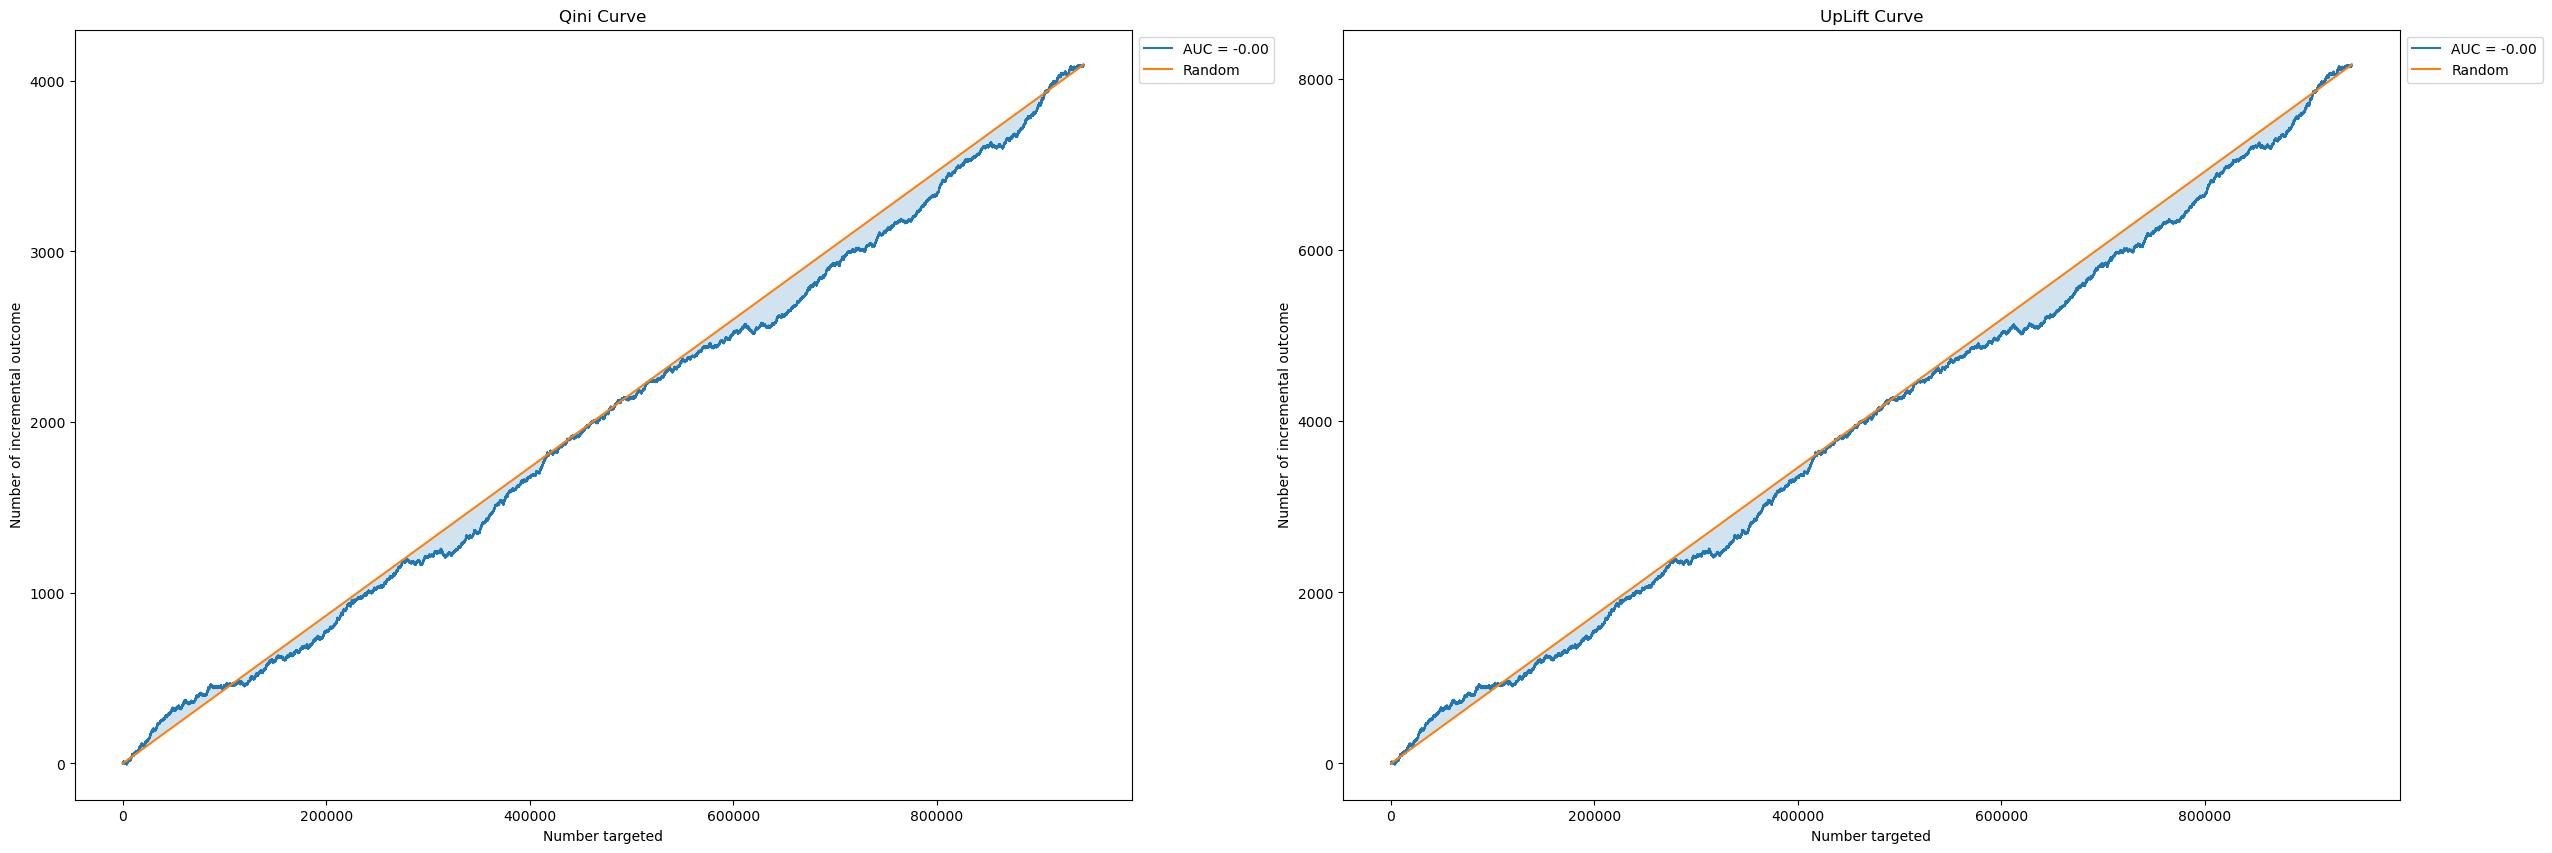

In [15]:
treat = Y_data.treat.values
y = Y_data.target.values

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
uplift_overall, uplift_group, qini_score, uplift_score = get_report(y, treat, y_pred, 'Plots/Base model Split.png')










In [16]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

7121

# Метод одной модели

In [17]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
#X_data = pd.concat([X_data, pd.get_dummies(Y_data.treat)], axis= 1)
treat = Y_data.treat.values
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()

var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

0

UpLift at 30%: overall - 0.01339, grouped - 0.014668.
Qini AUC Score: 0.018916; UpLift AUC Score: 0.004655
UpLift at 30%: overall - 0.017239, grouped - 0.018235.
Qini AUC Score: 0.021431; UpLift AUC Score: 0.005311
UpLift at 30%: overall - 0.017476, grouped - 0.018319.
Qini AUC Score: 0.024499; UpLift AUC Score: 0.006084
UpLift at 30%: overall - 0.016237, grouped - 0.016848.
Qini AUC Score: 0.02351; UpLift AUC Score: 0.00585
UpLift at 30%: overall - 0.014695, grouped - 0.015951.
Qini AUC Score: 0.023355; UpLift AUC Score: 0.005778
UpLift at 30%: overall - 0.0158, grouped - 0.0168.
Qini AUC Score: 0.0223; UpLift AUC Score: 0.0055


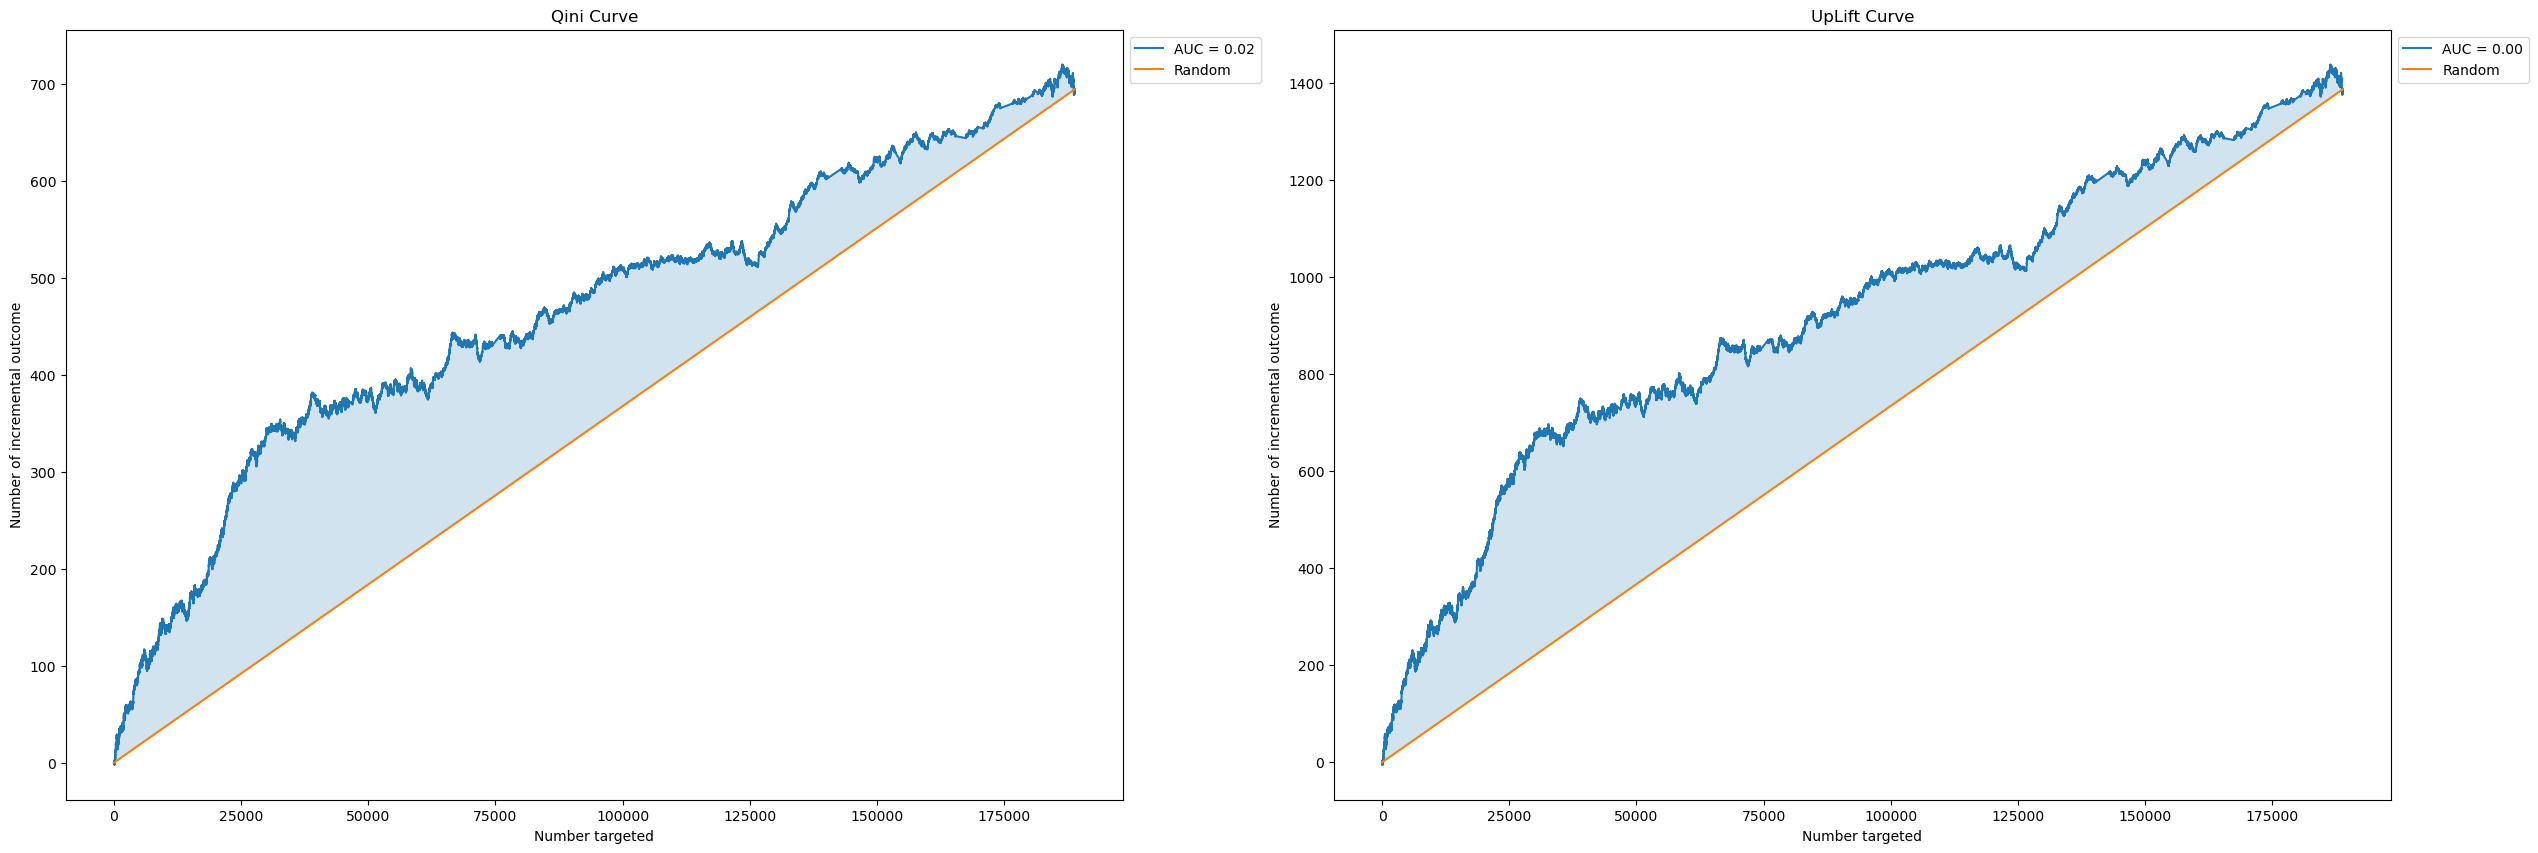

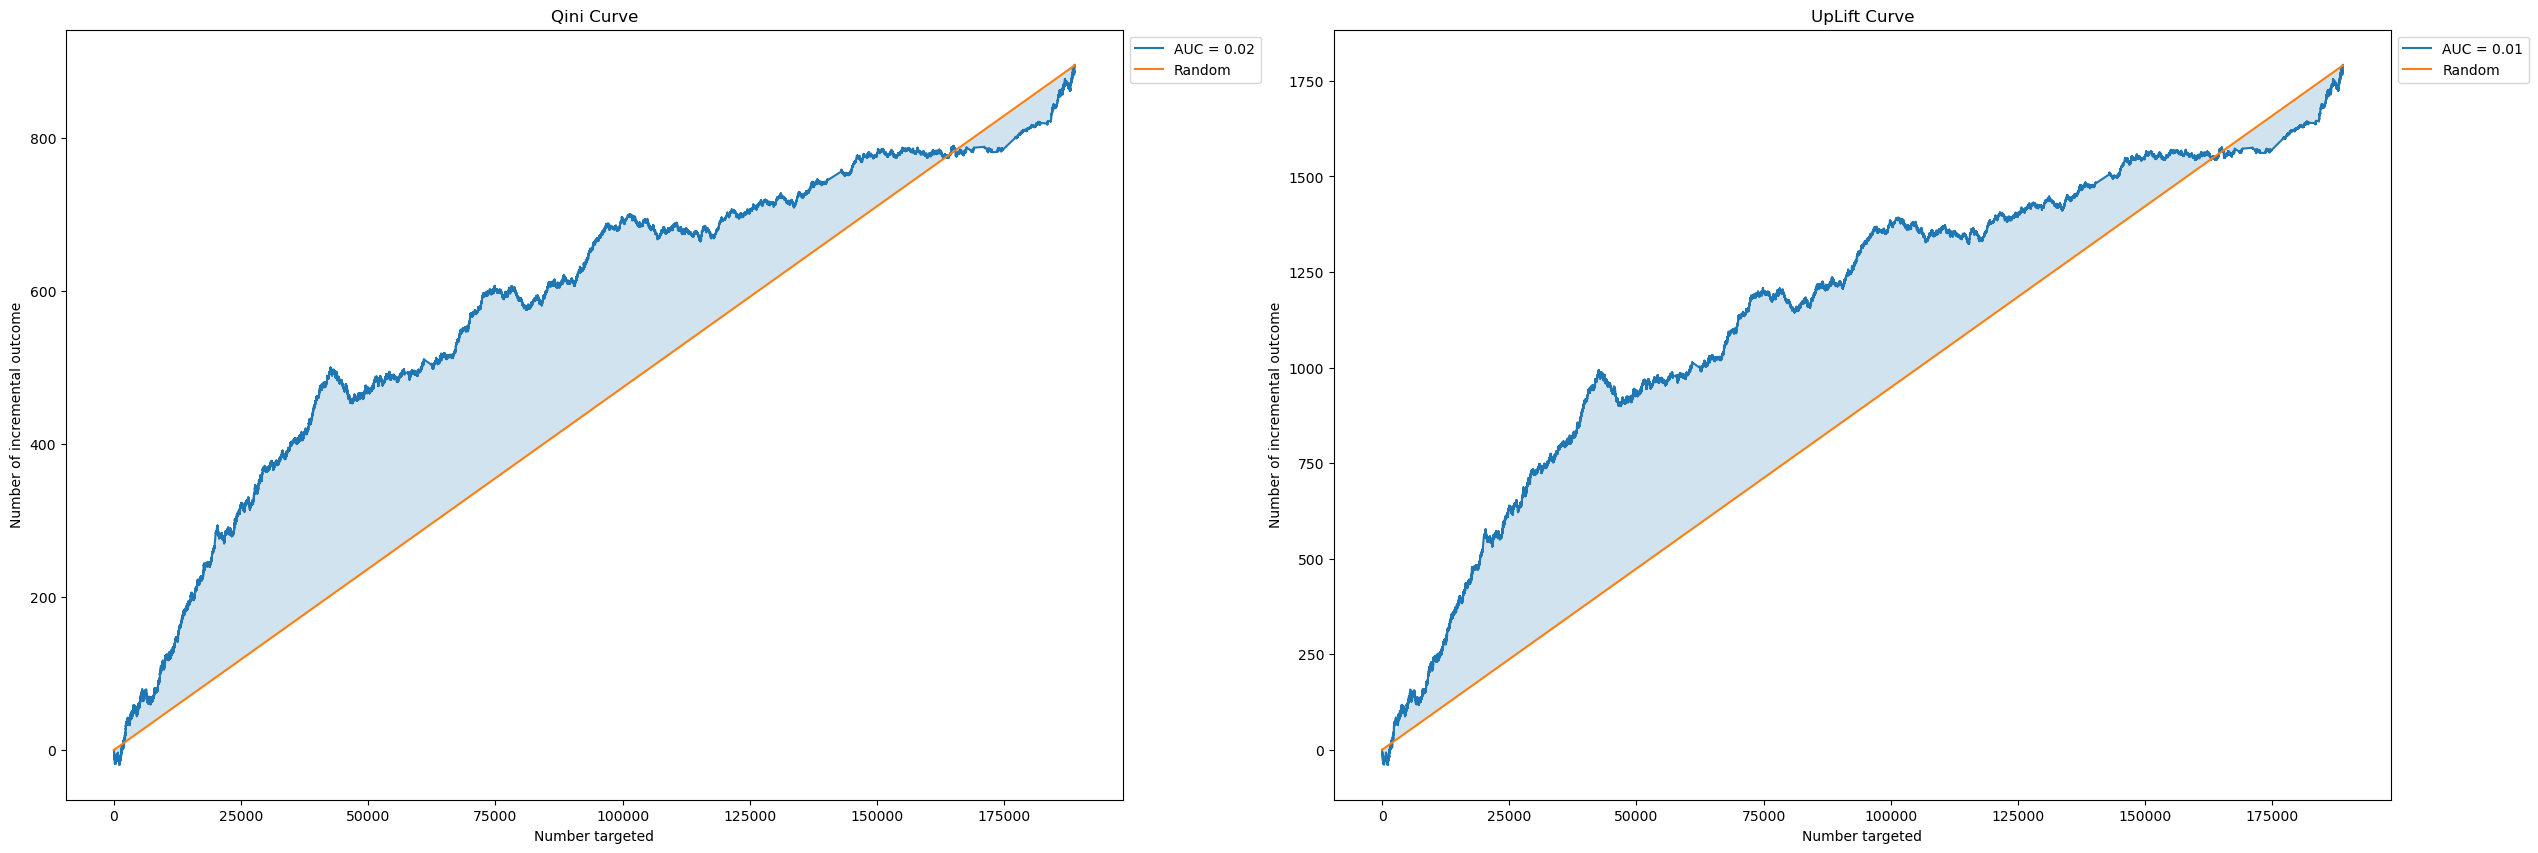

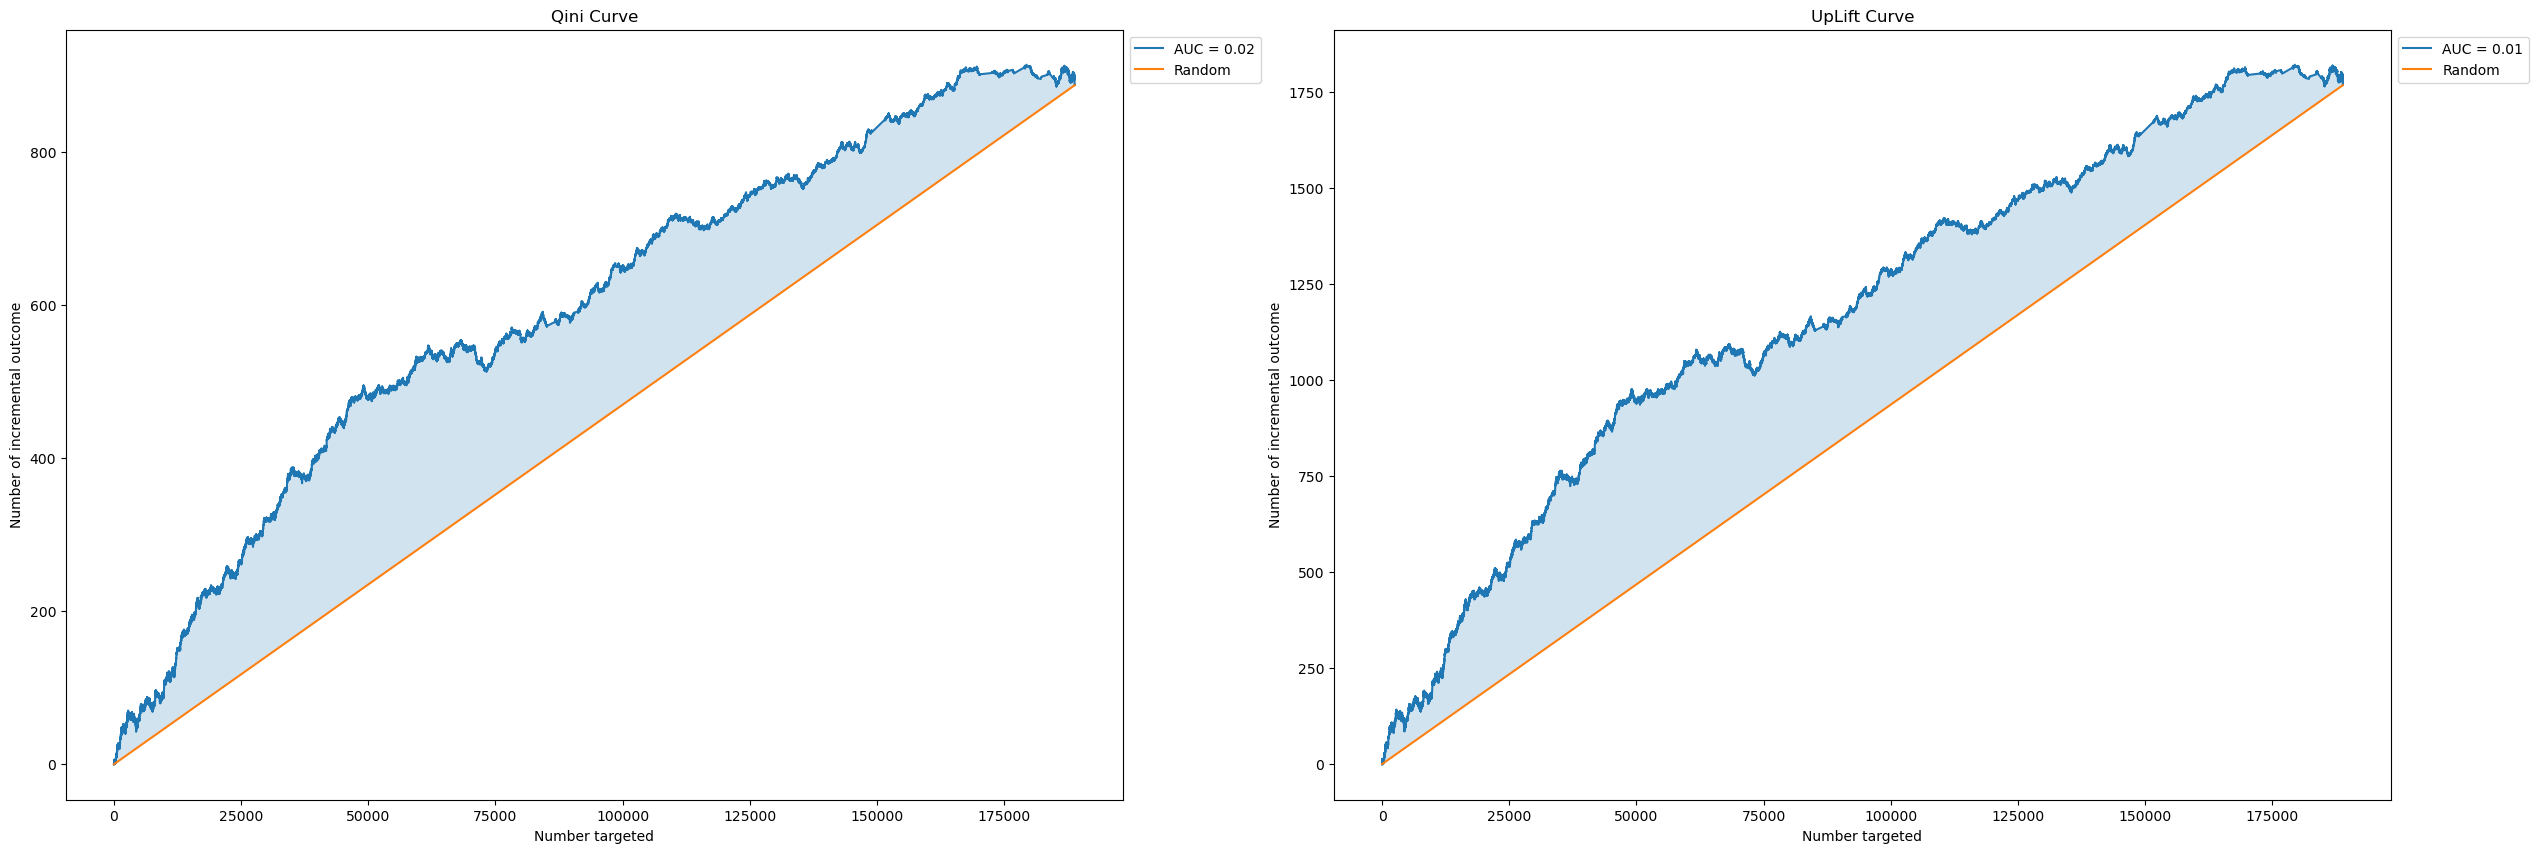

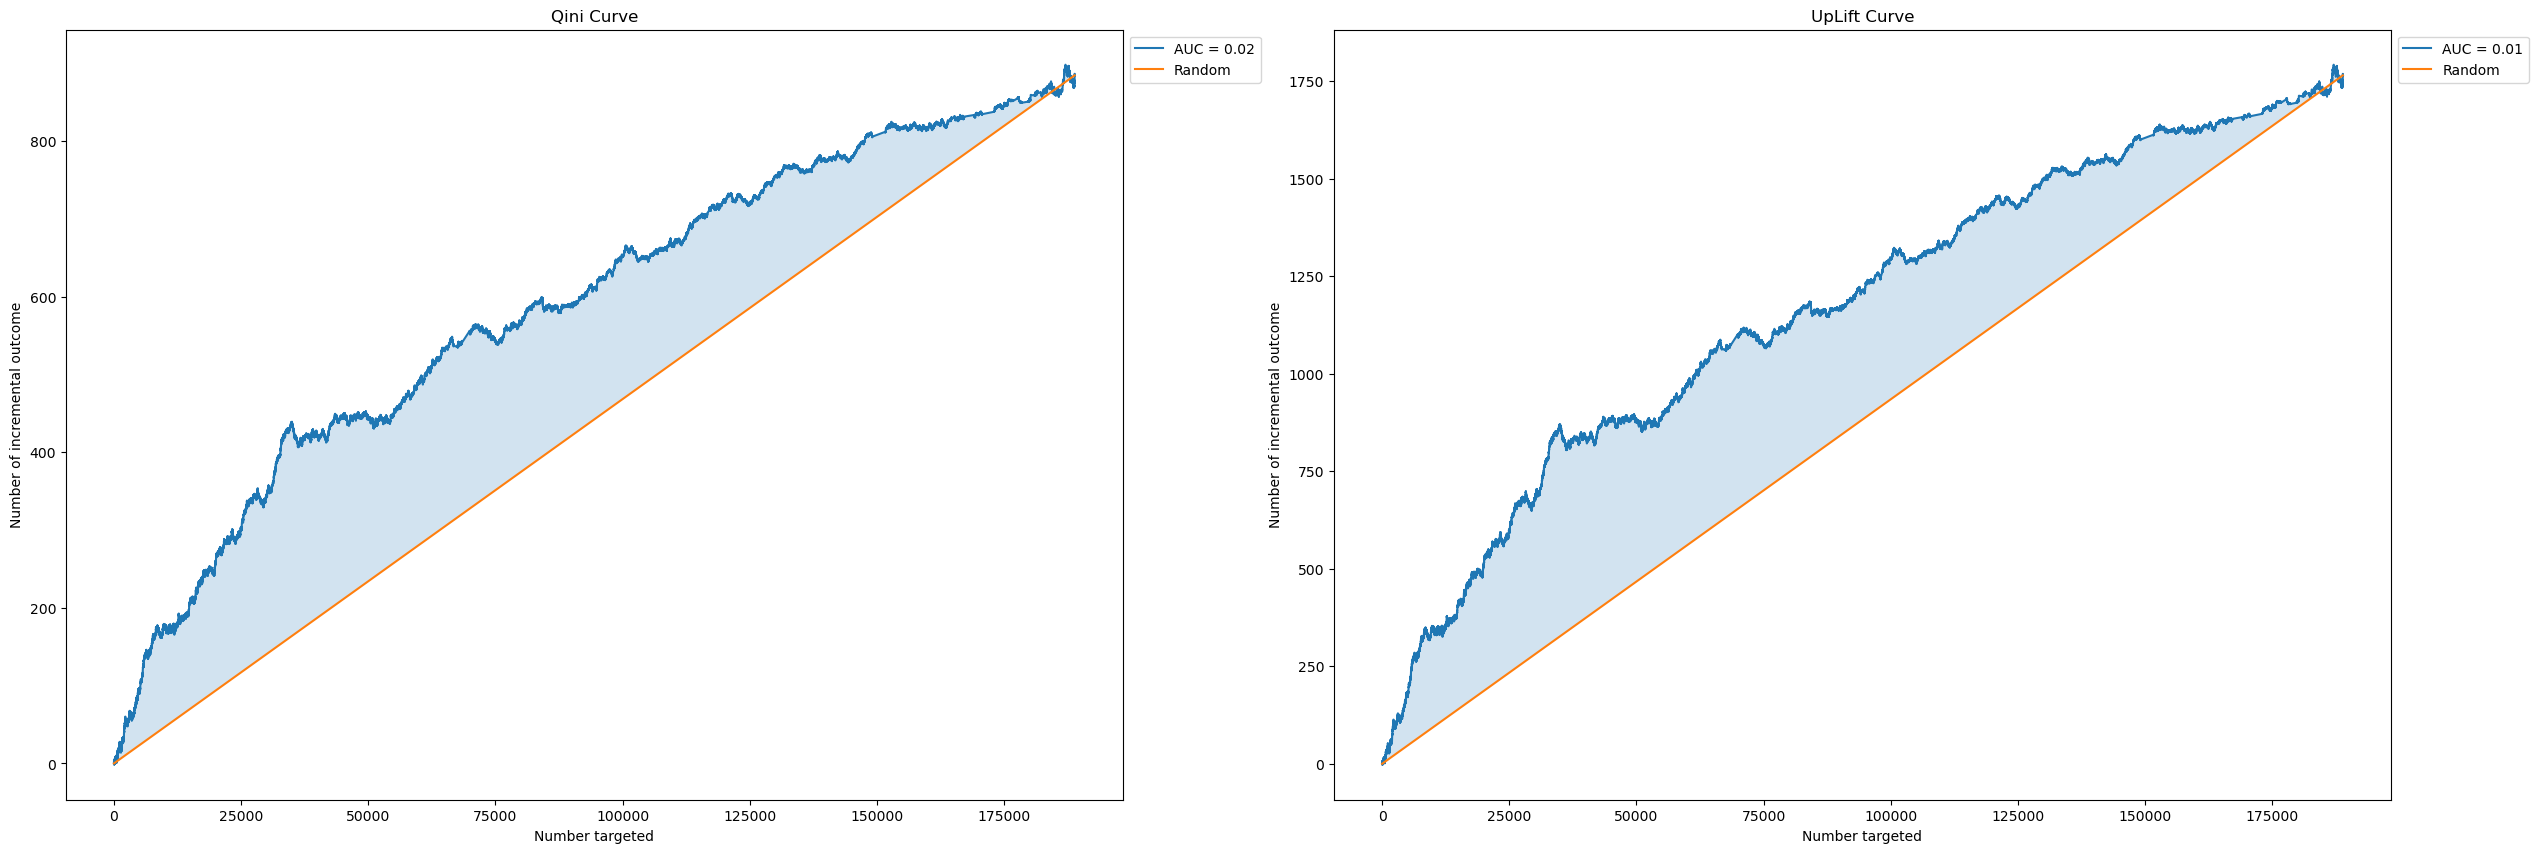

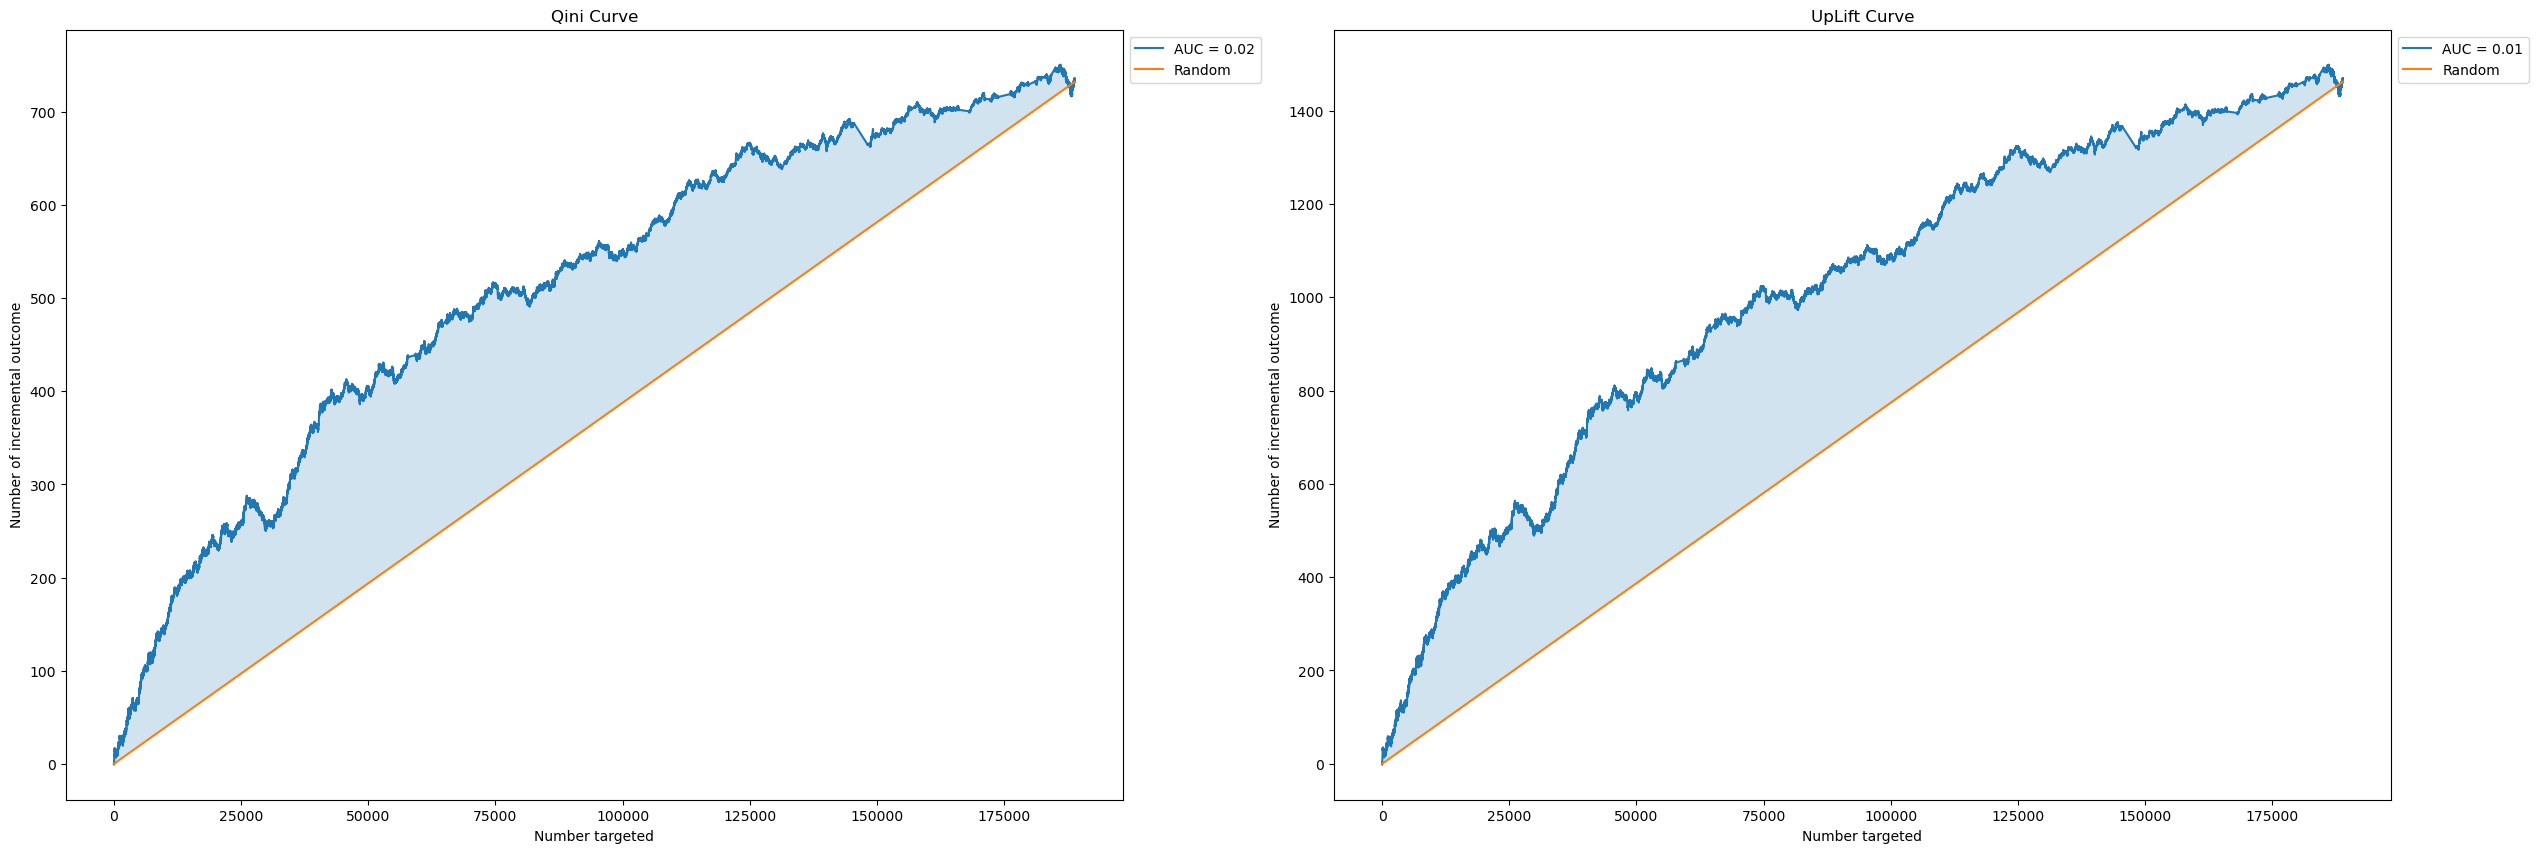

In [18]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf = CatBoostClassifier(verbose = 0)
      clf = SoloModel(estimator=catboost_clf)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/One model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
    
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [19]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0158, grouped - 0.0168.
Qini AUC Score: 0.0223; UpLift AUC Score: 0.0055


In [20]:
gc.collect()

40148

In [21]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

0

# Метод двух моделей

In [22]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

UpLift at 30%: overall - 0.012469, grouped - 0.013625.
Qini AUC Score: 0.012981; UpLift AUC Score: 0.003237
UpLift at 30%: overall - 0.012924, grouped - 0.01251.
Qini AUC Score: 0.015241; UpLift AUC Score: 0.003896
UpLift at 30%: overall - 0.018024, grouped - 0.018187.
Qini AUC Score: 0.026689; UpLift AUC Score: 0.006796
UpLift at 30%: overall - 0.014672, grouped - 0.014602.
Qini AUC Score: 0.012894; UpLift AUC Score: 0.003287
UpLift at 30%: overall - 0.013964, grouped - 0.01489.
Qini AUC Score: 0.015447; UpLift AUC Score: 0.003841
UpLift at 30%: overall - 0.0144, grouped - 0.0148.
Qini AUC Score: 0.0167; UpLift AUC Score: 0.0042


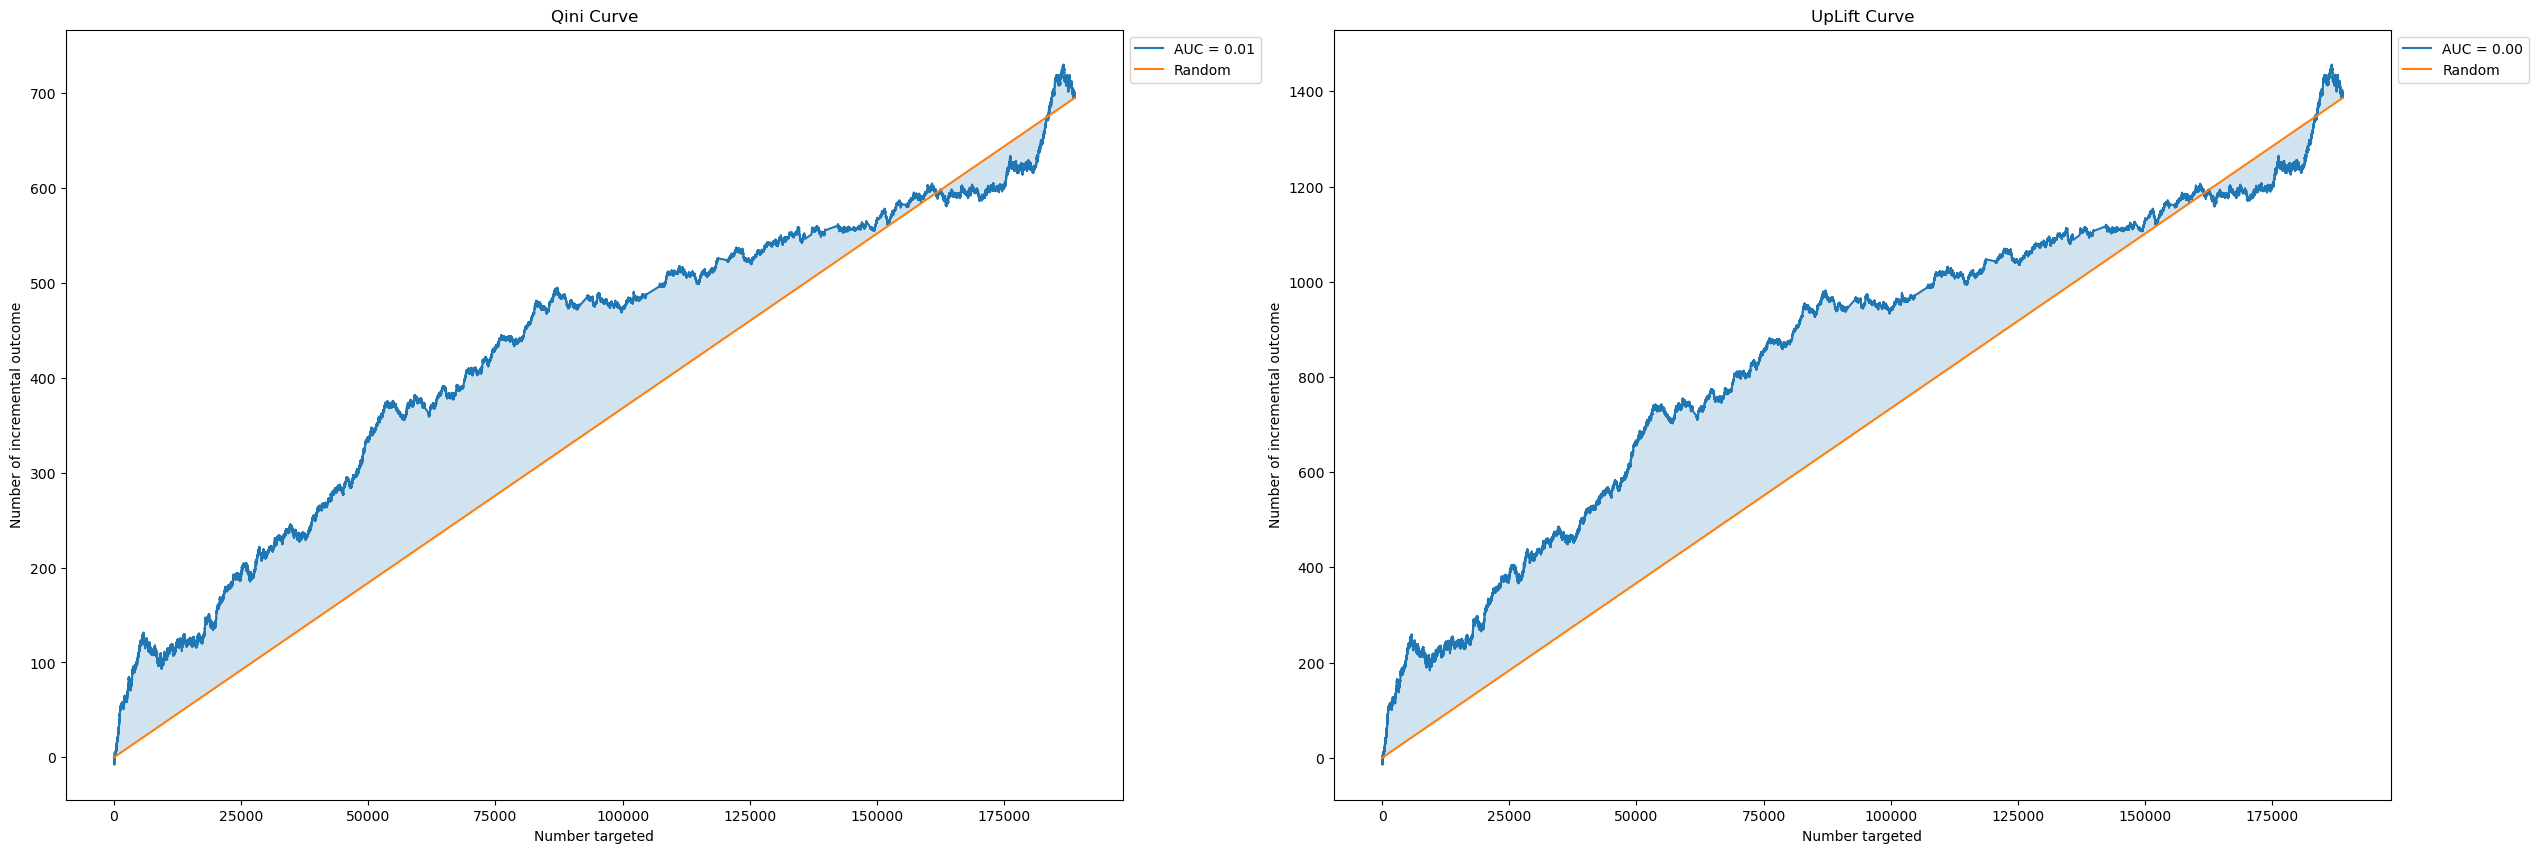

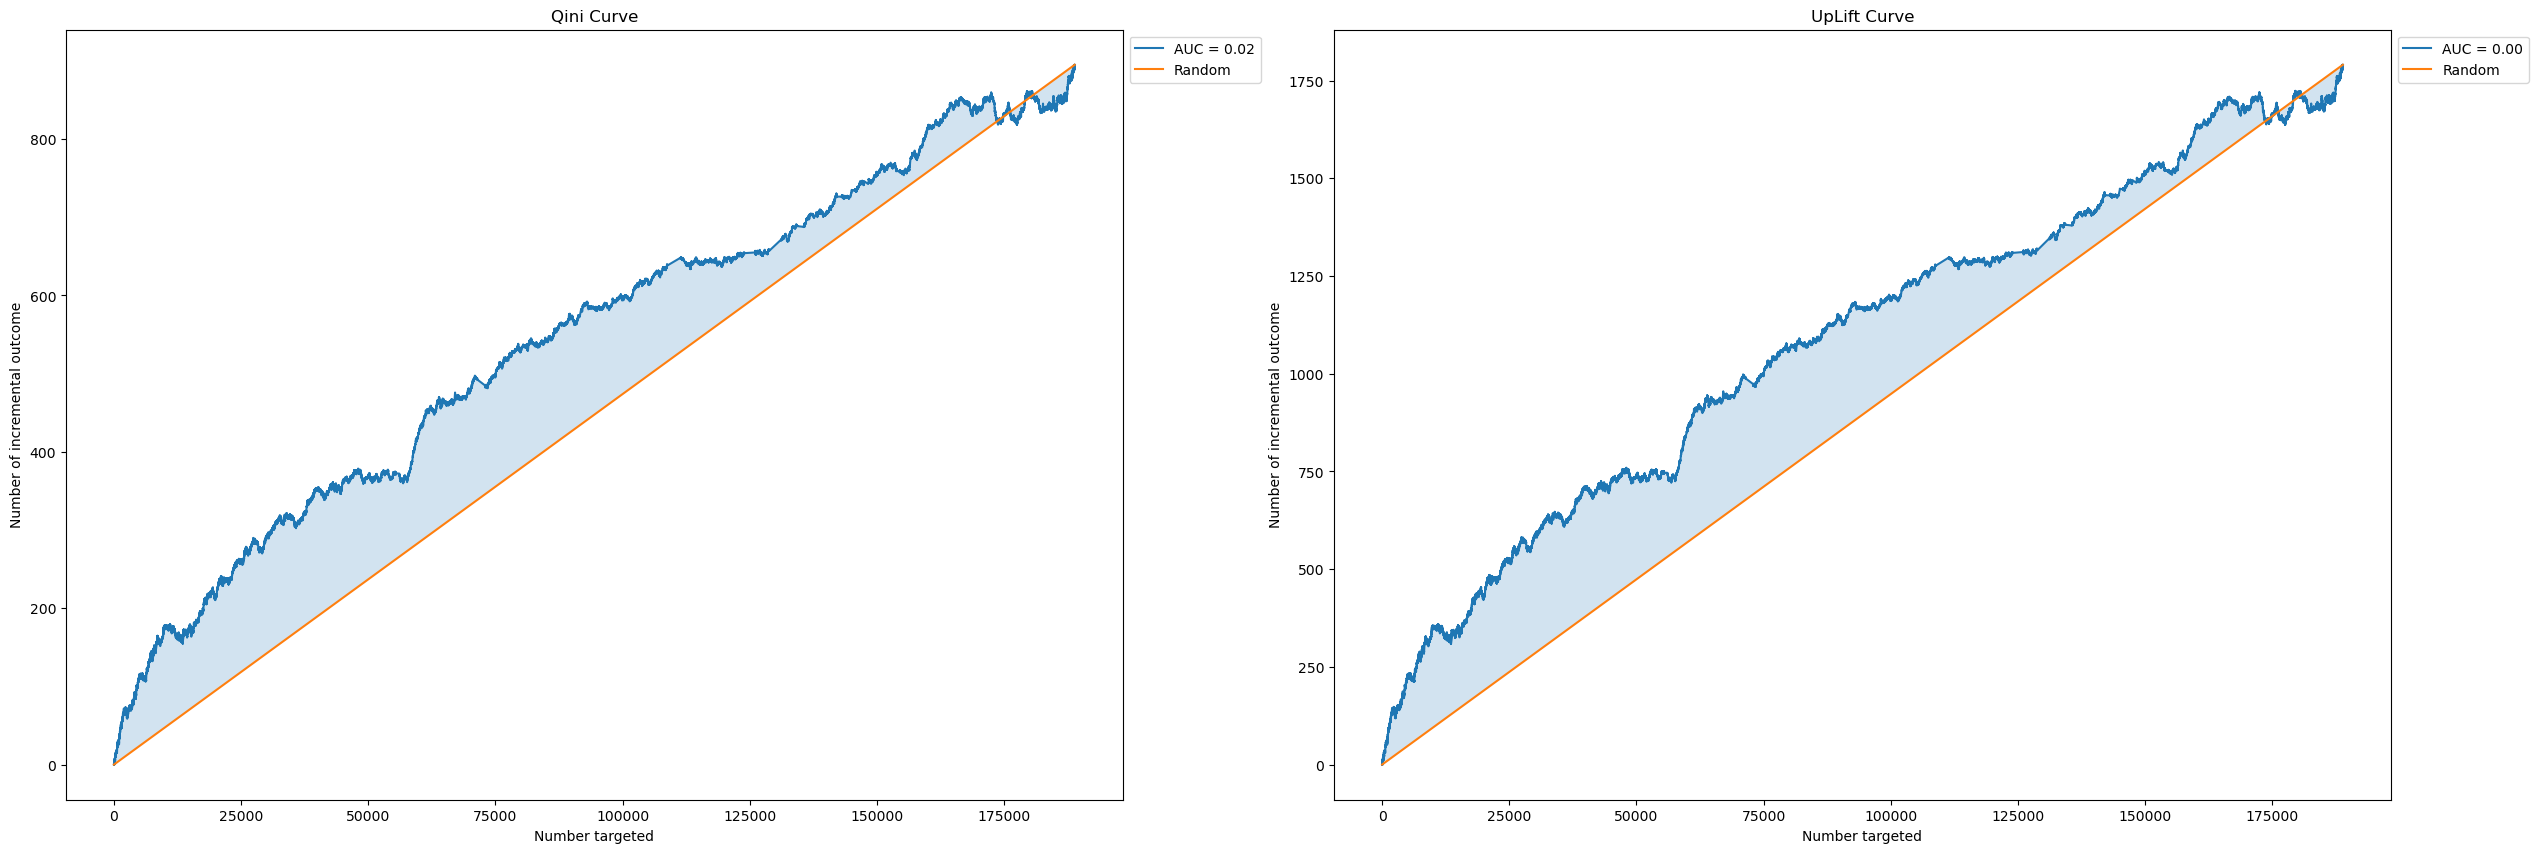

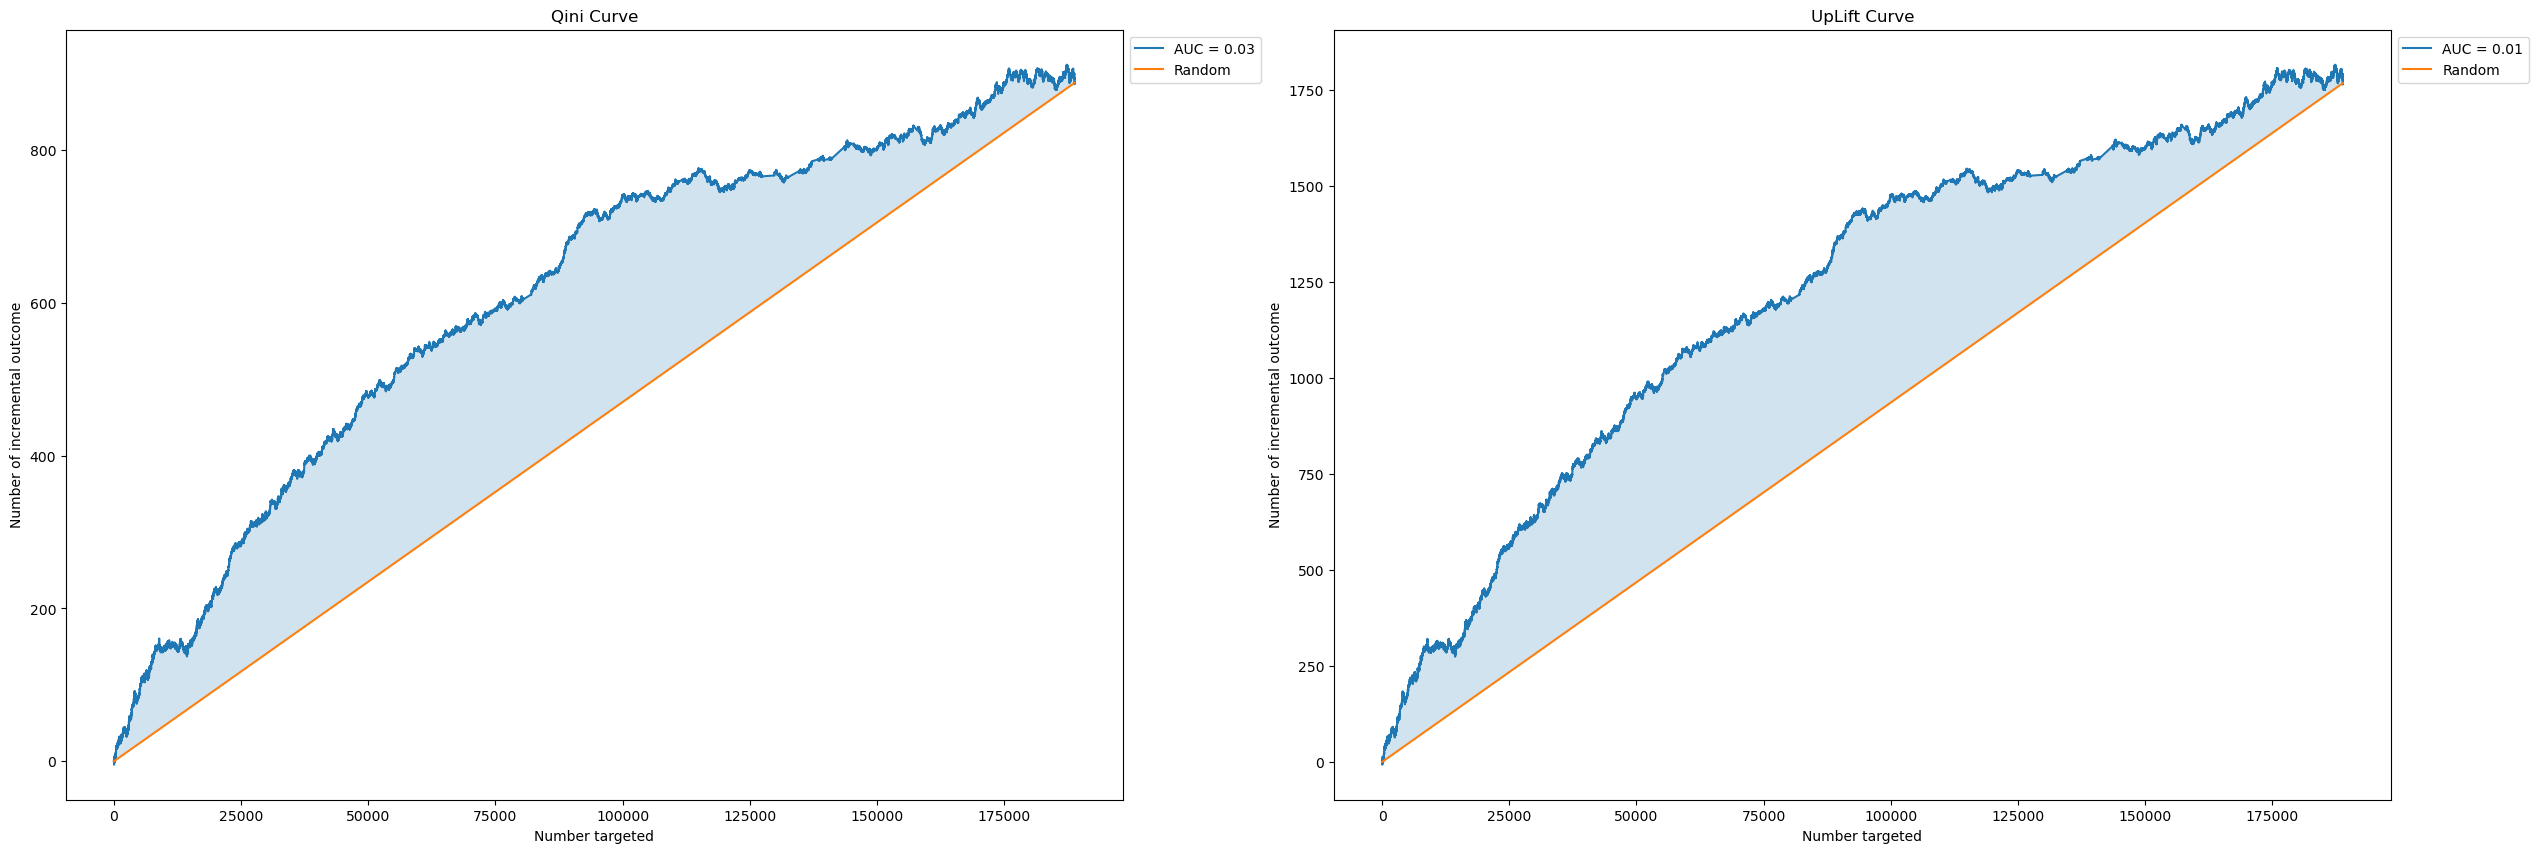

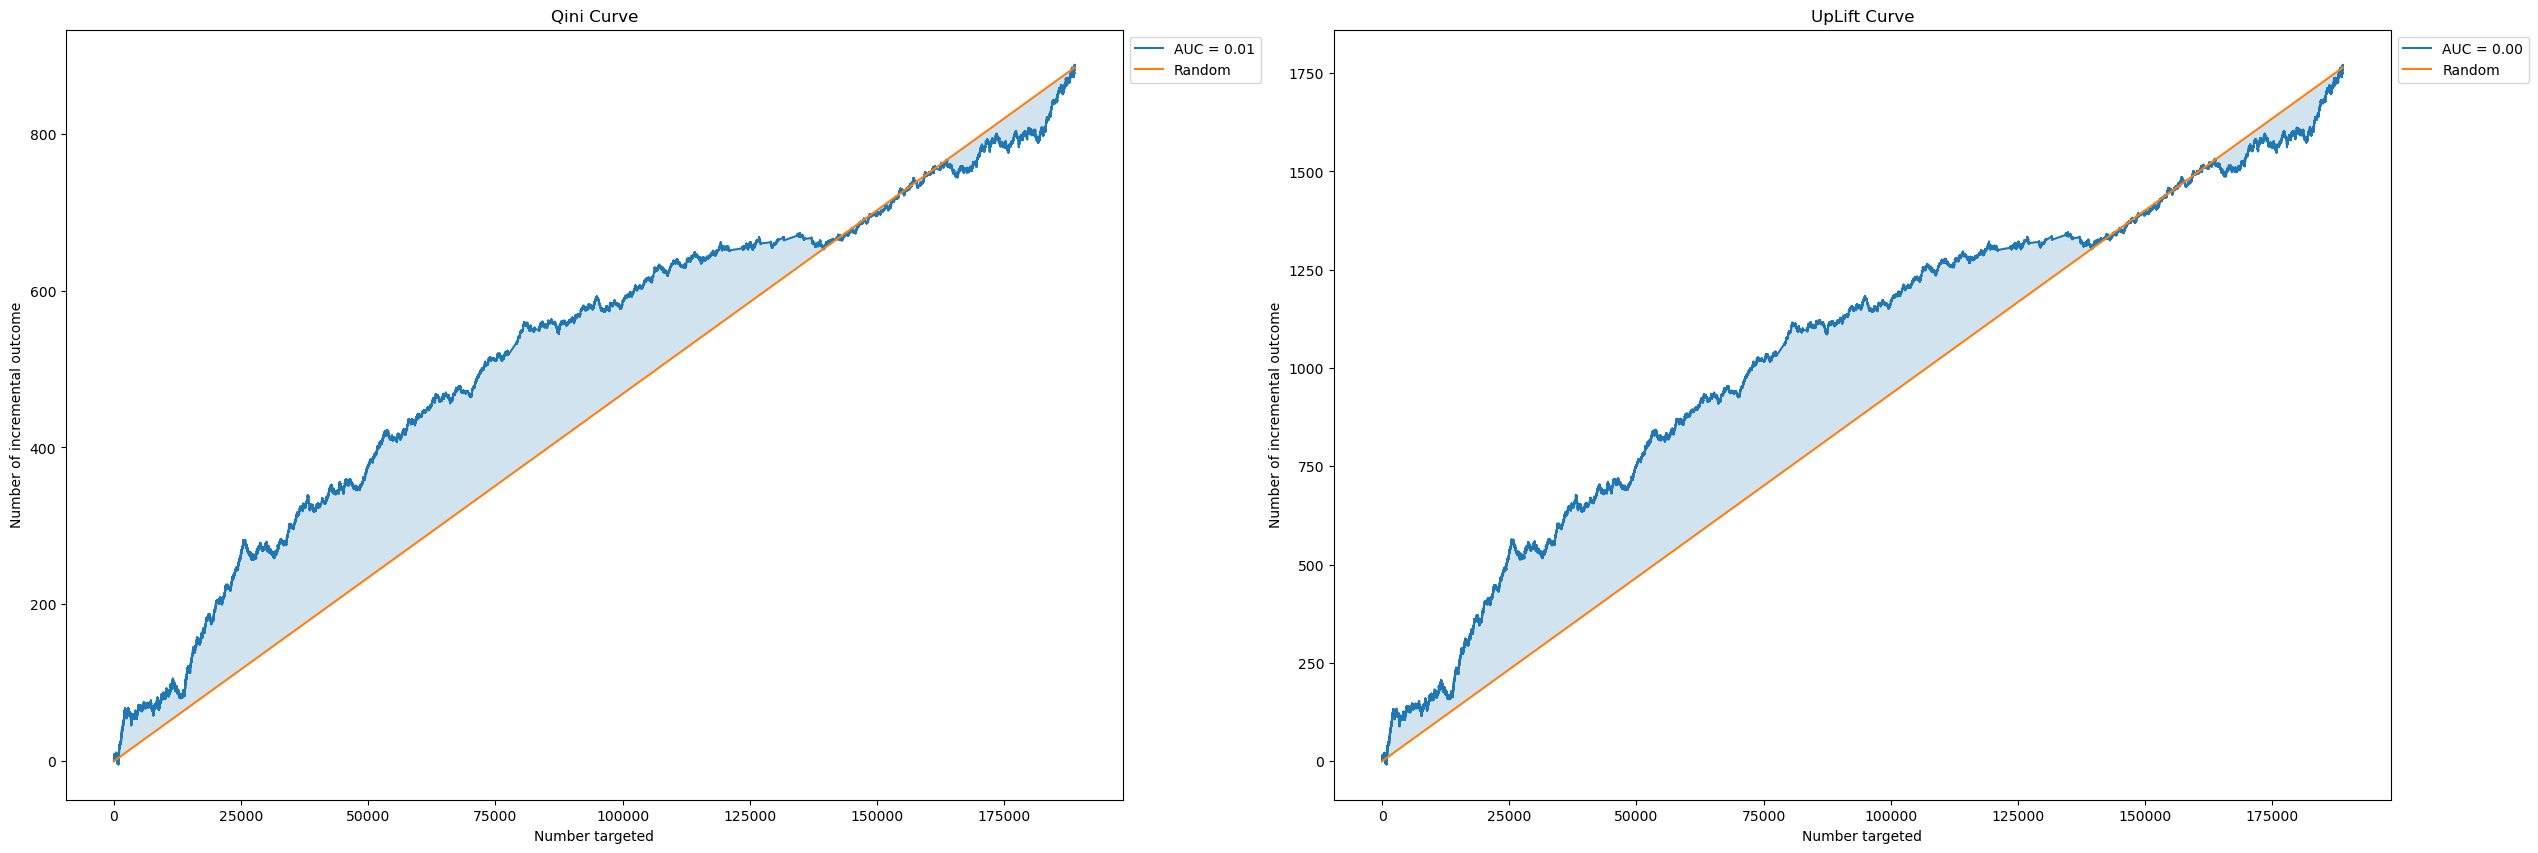

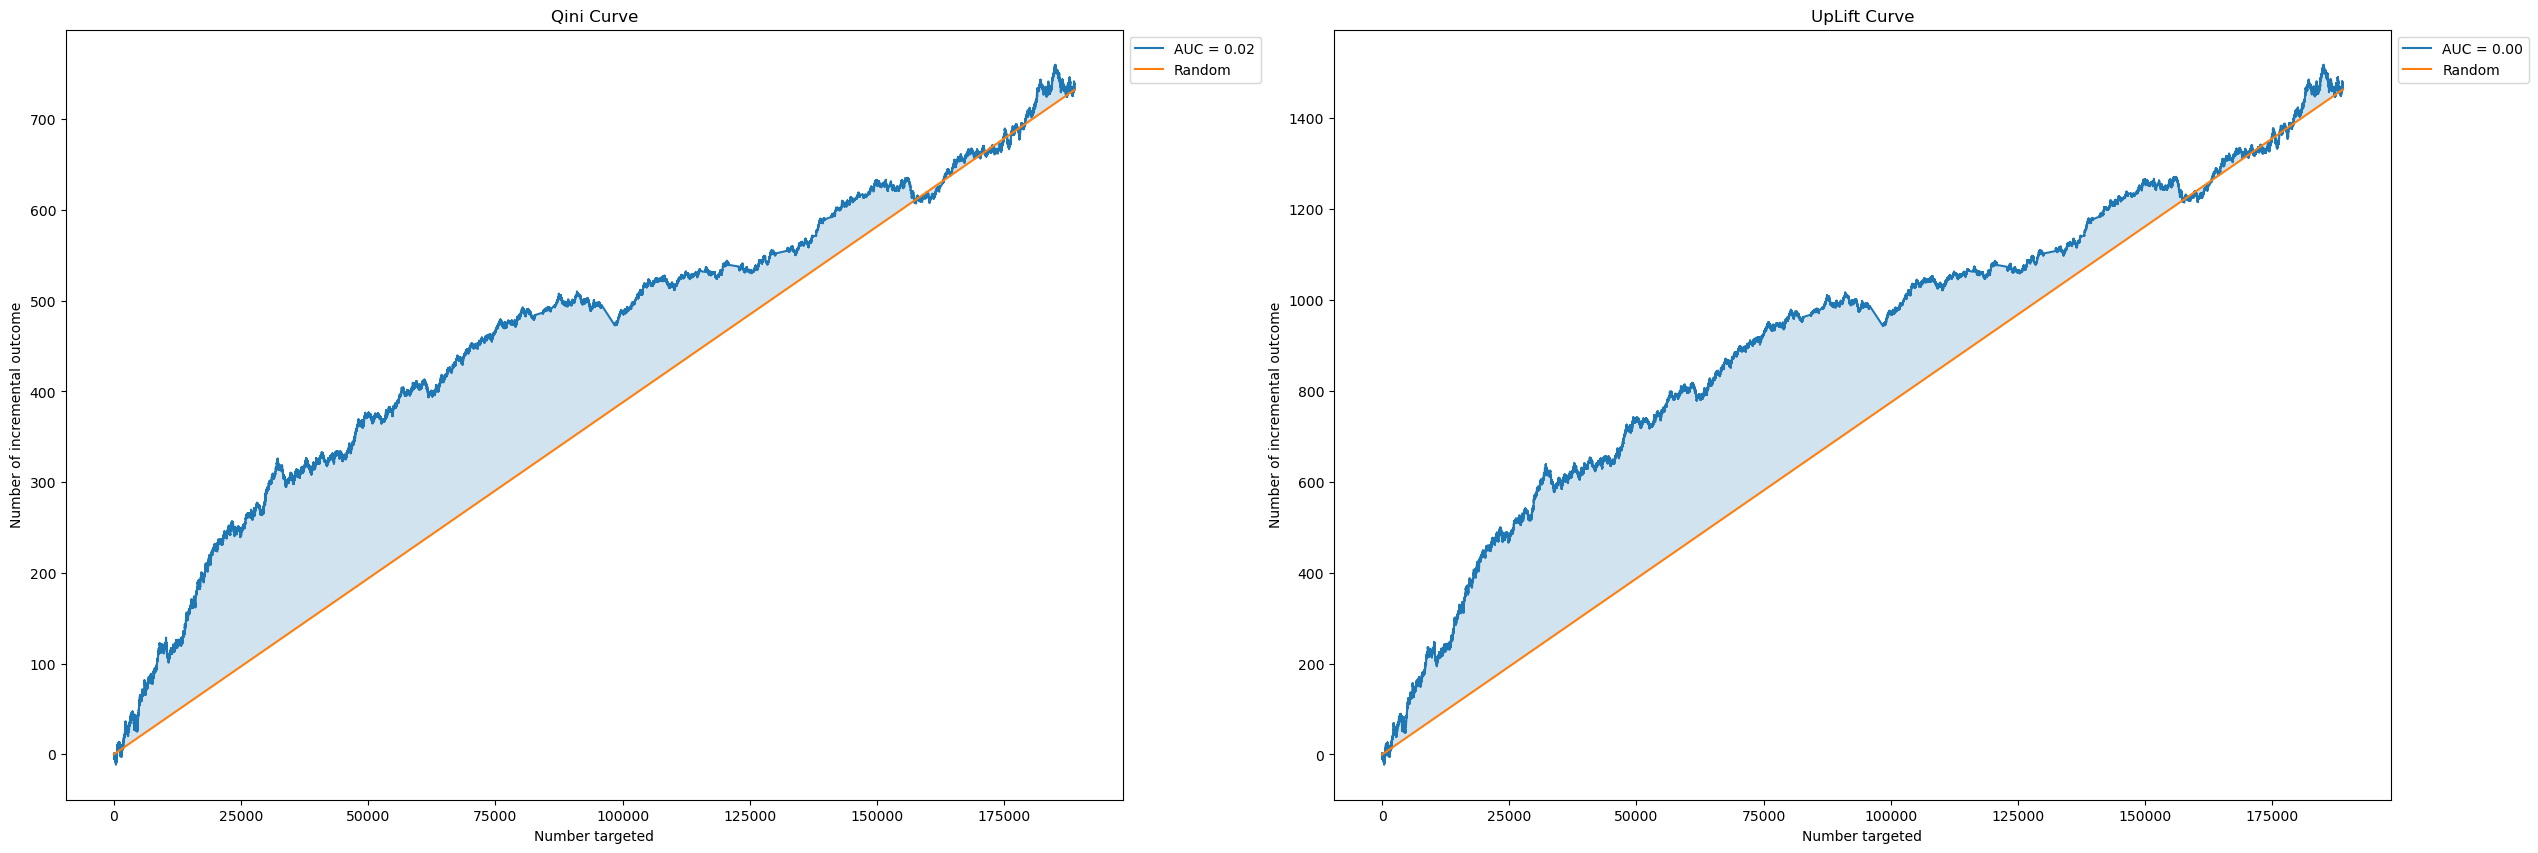

In [23]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf0 = CatBoostClassifier(verbose = 0)
      catboost_clf1 = CatBoostClassifier(verbose = 0)
      clf = TwoModels(estimator_ctrl= catboost_clf0, estimator_trmnt=catboost_clf1)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del catboost_clf0
      del catboost_clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/Two models Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1



uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [24]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0144, grouped - 0.0148.
Qini AUC Score: 0.0167; UpLift AUC Score: 0.0042


In [25]:
del X_data
del Y_data
del treat
del y
gc.collect()

40148

# Метод трансформации класса (Классификация)

In [26]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X)
print(y)
print(p)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[0 0 0 ... 0 0 0]
0.5011176183452472


UpLift at 30%: overall - 0.01193, grouped - 0.01022.
Qini AUC Score: 0.008302; UpLift AUC Score: 0.002256
UpLift at 30%: overall - 0.012346, grouped - 0.012143.
Qini AUC Score: 0.005326; UpLift AUC Score: 0.001568
UpLift at 30%: overall - 0.012177, grouped - 0.011831.
Qini AUC Score: 0.006822; UpLift AUC Score: 0.001958
UpLift at 30%: overall - 0.01444, grouped - 0.013625.
Qini AUC Score: 0.010313; UpLift AUC Score: 0.002853
UpLift at 30%: overall - 0.011251, grouped - 0.010329.
Qini AUC Score: 0.009642; UpLift AUC Score: 0.002564
UpLift at 30%: overall - 0.0124, grouped - 0.0116.
Qini AUC Score: 0.0081; UpLift AUC Score: 0.0022


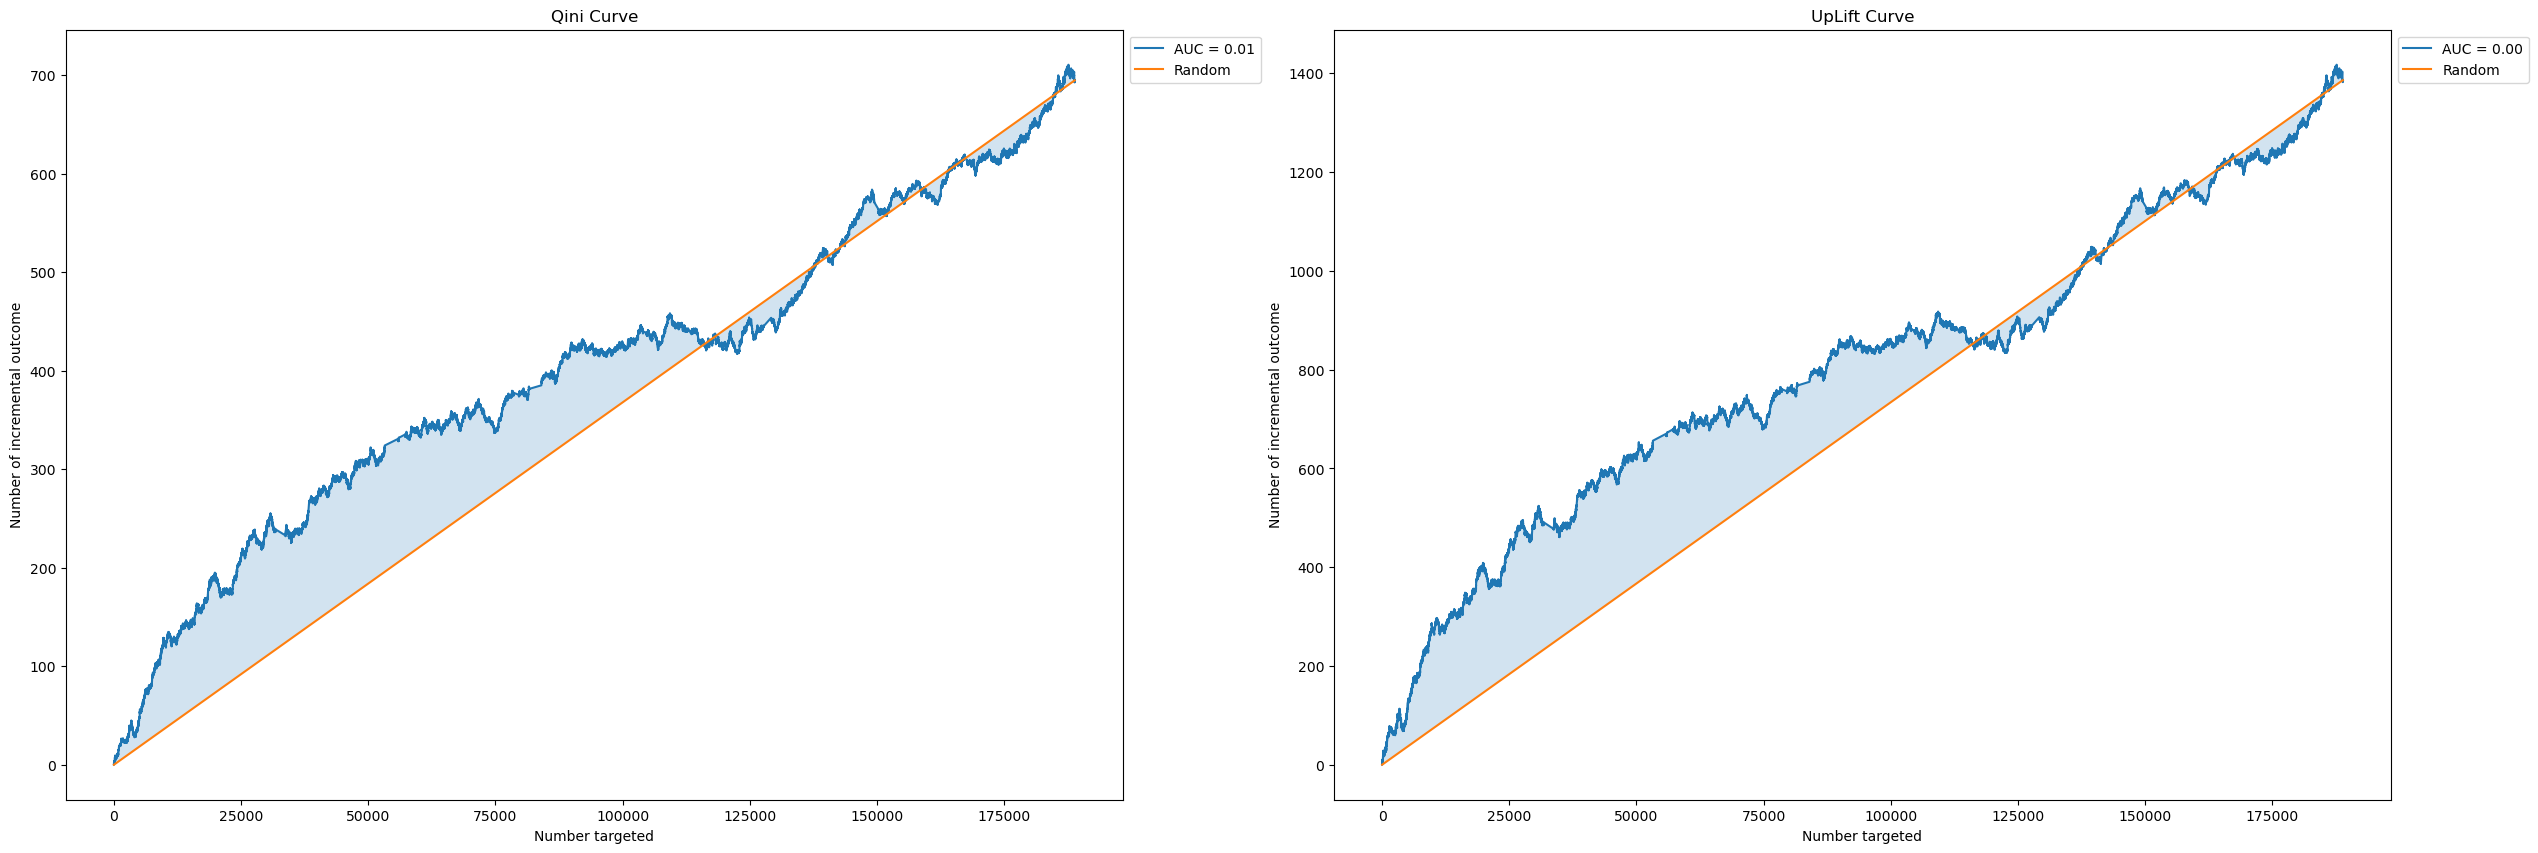

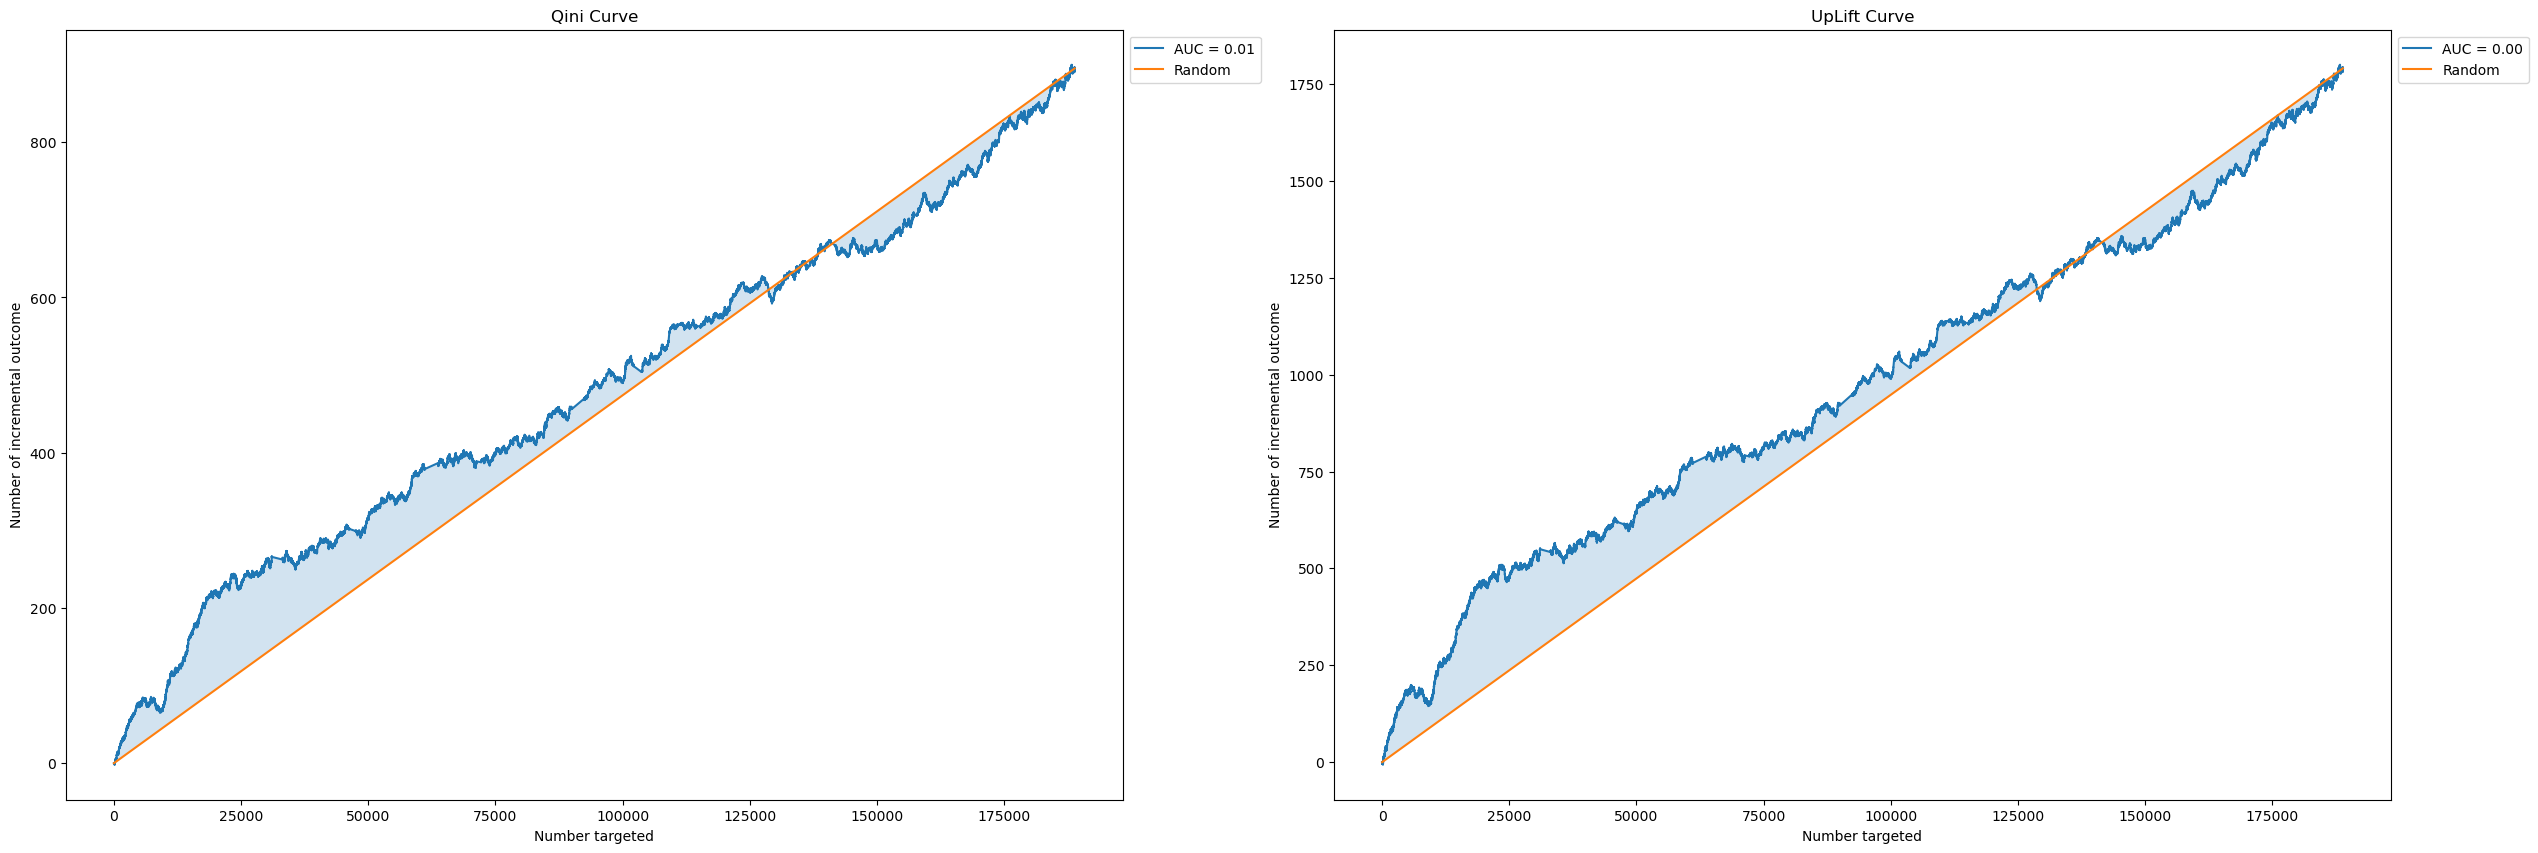

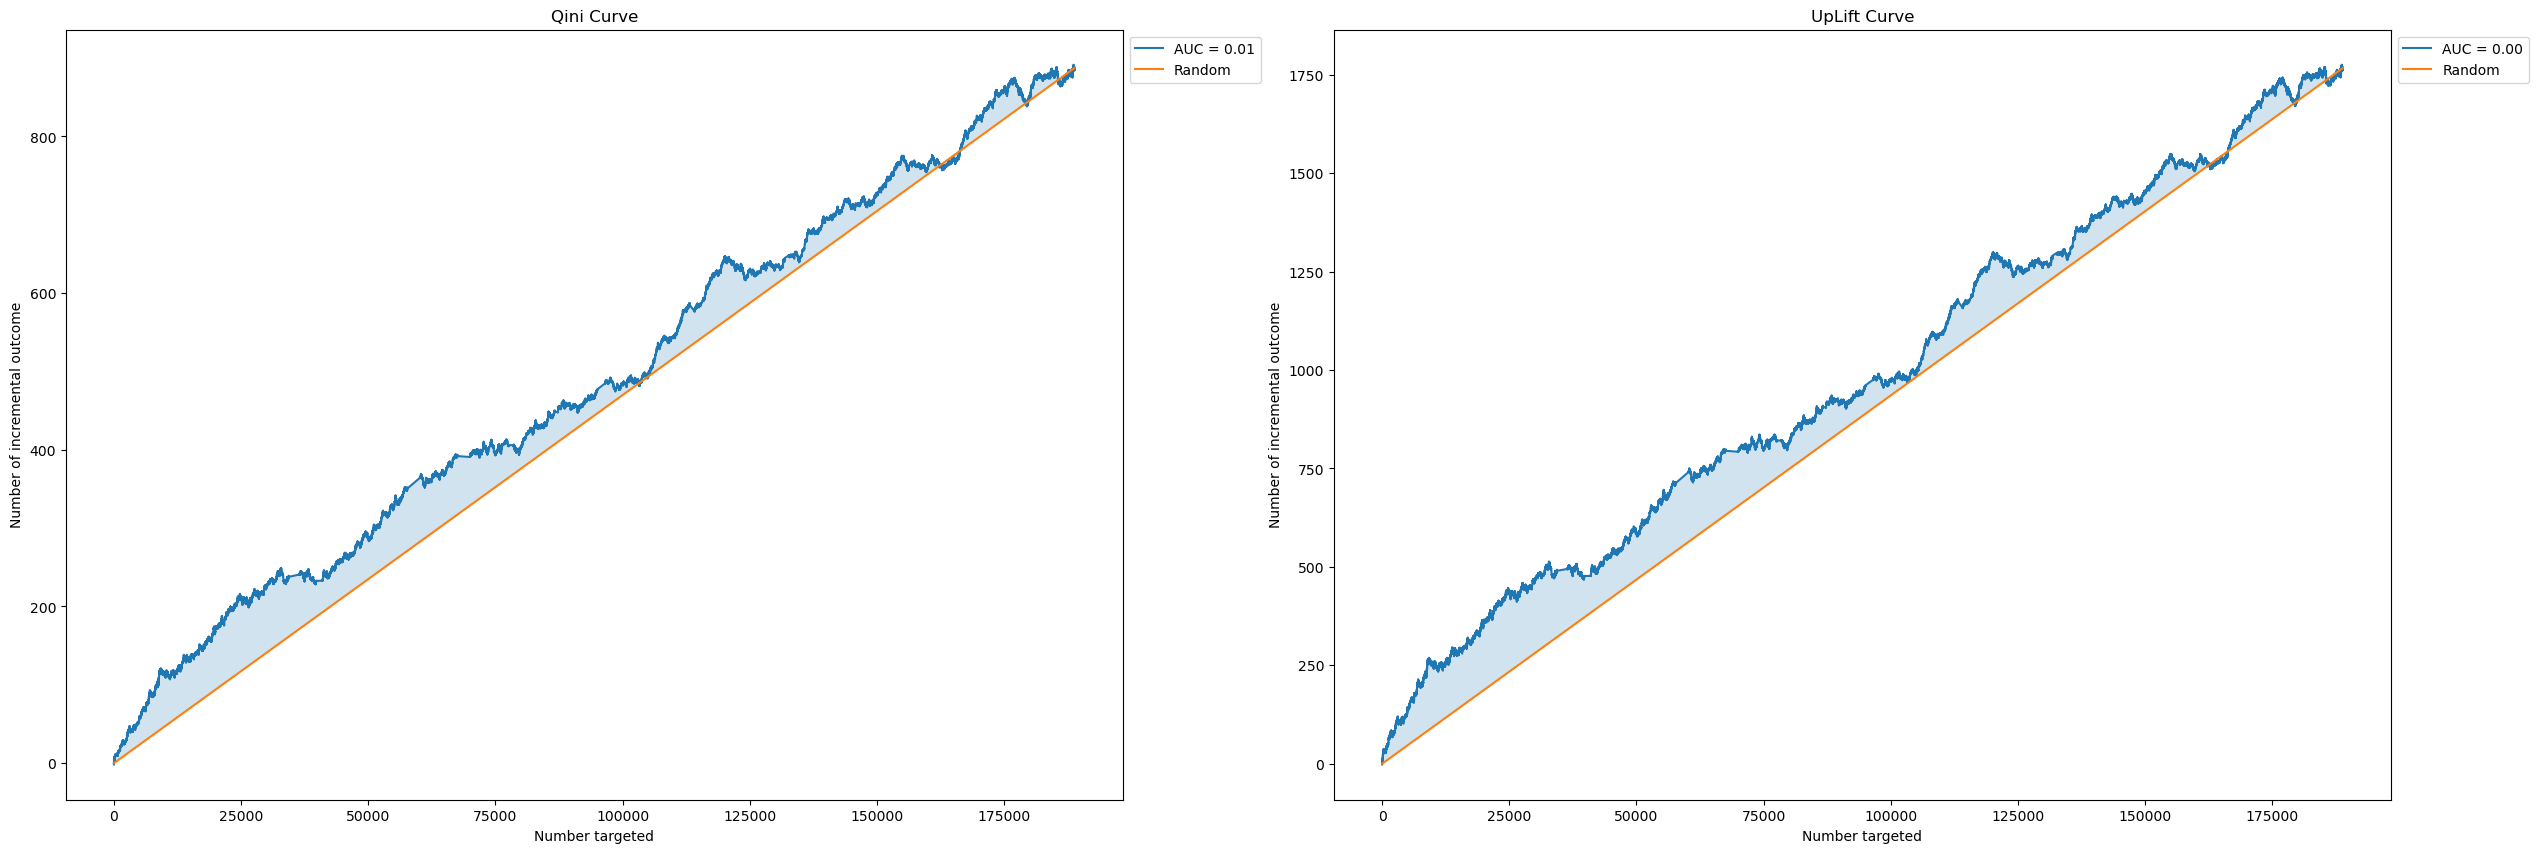

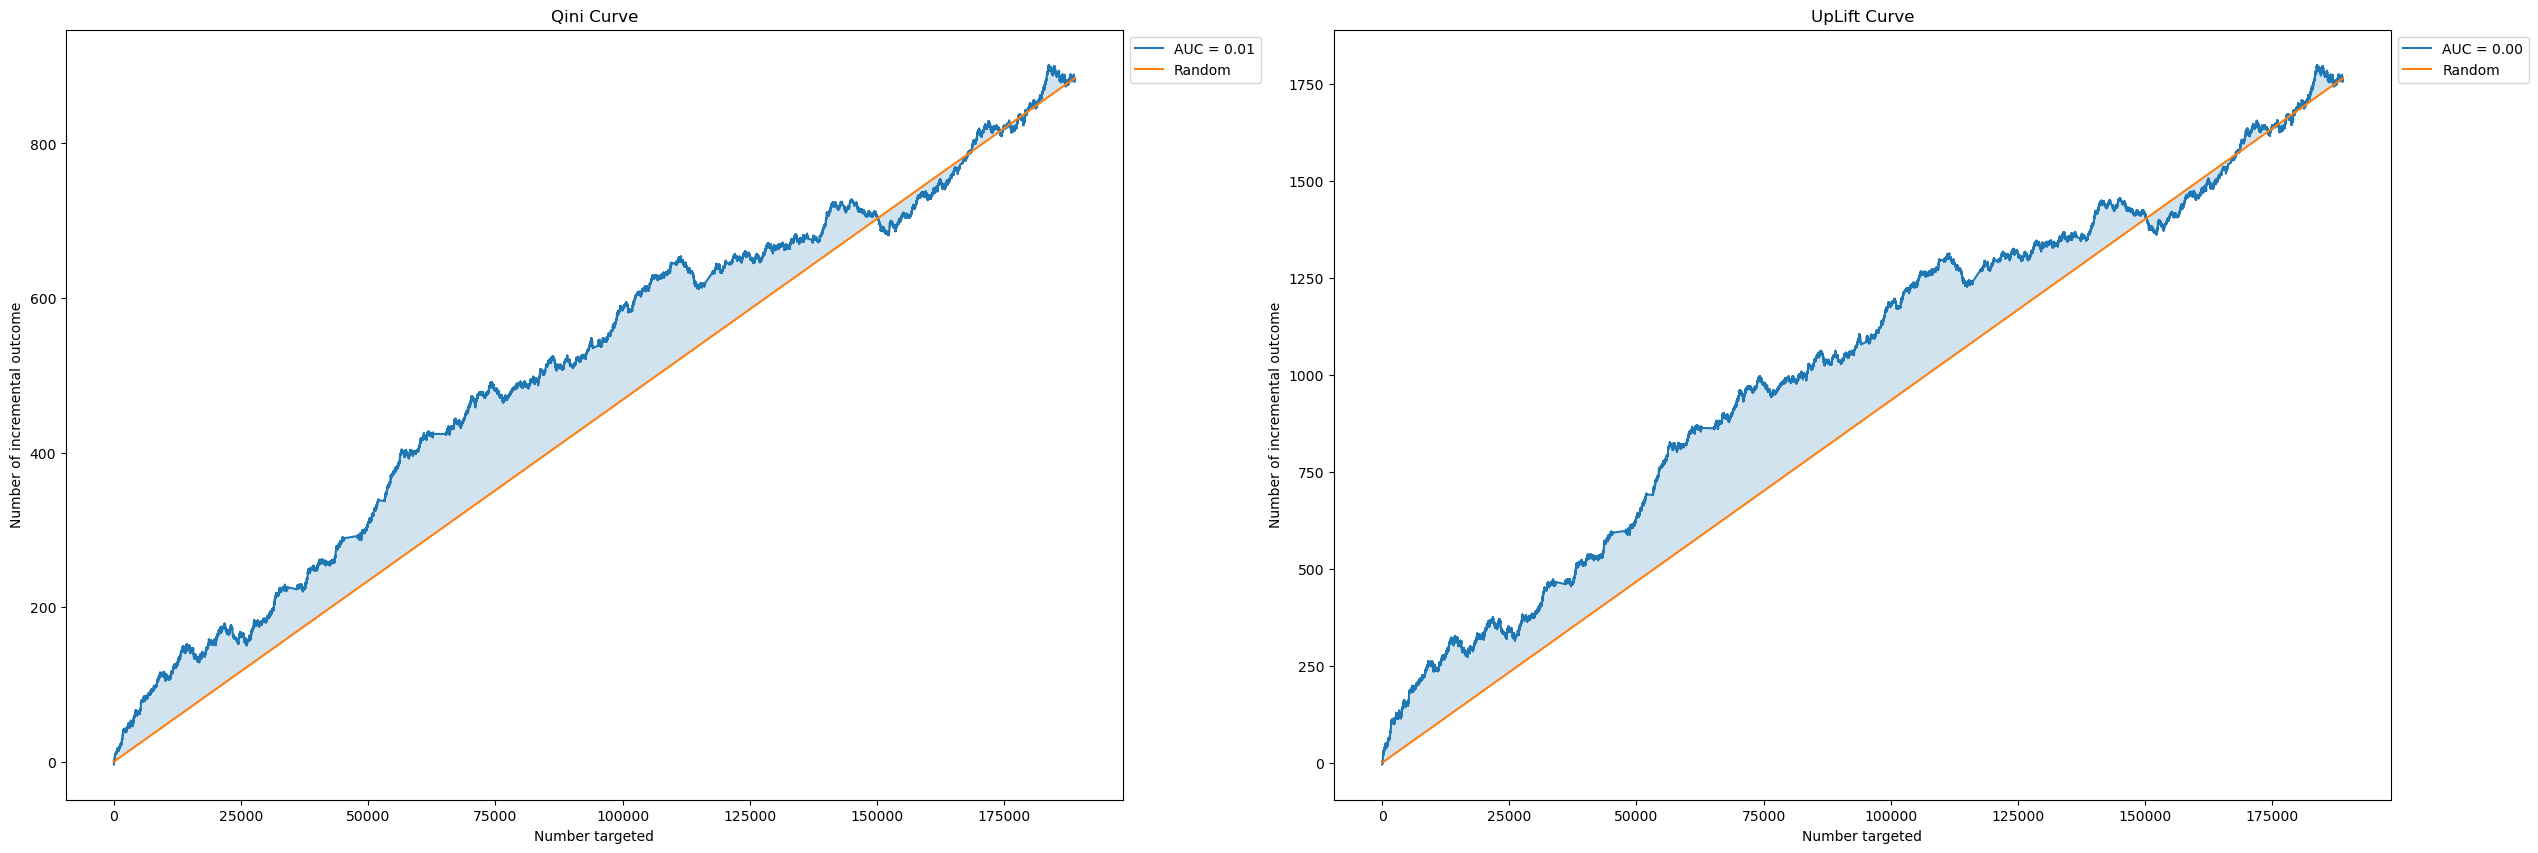

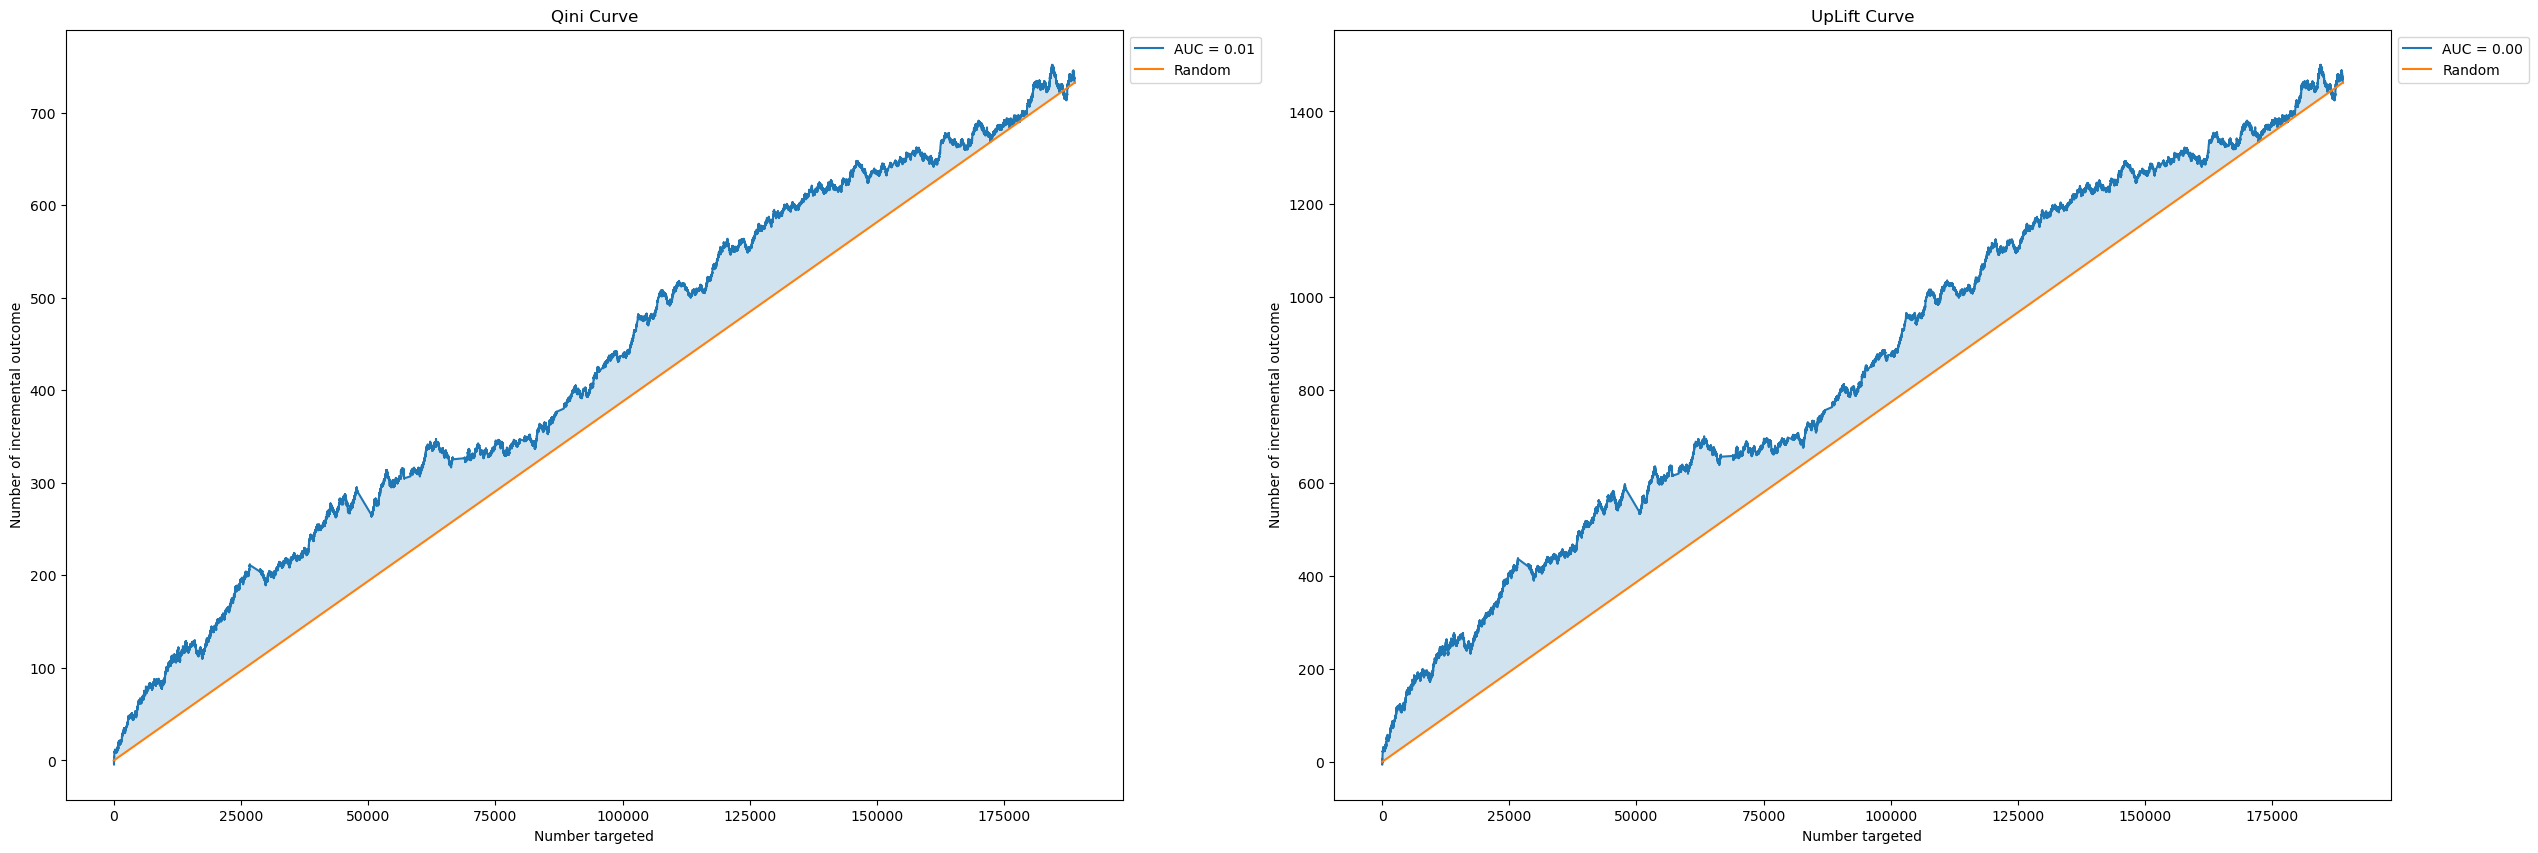

In [27]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf = CatBoostClassifier(verbose = 0)
      clf = ClassTransformation(estimator=catboost_clf)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/Trasnform Class model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [28]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0124, grouped - 0.0116.
Qini AUC Score: 0.0081; UpLift AUC Score: 0.0022


In [29]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

40148

# Метод трансформации класса (Регрессия)

In [30]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X)
print(y)
print(p)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[0 0 0 ... 0 0 0]
0.5011176183452472


UpLift at 30%: overall - 0.011467, grouped - 0.012777.
Qini AUC Score: 0.008684; UpLift AUC Score: 0.002094
UpLift at 30%: overall - 0.015657, grouped - 0.015898.
Qini AUC Score: 0.016163; UpLift AUC Score: 0.004003
UpLift at 30%: overall - 0.014812, grouped - 0.015137.
Qini AUC Score: 0.01853; UpLift AUC Score: 0.004625
UpLift at 30%: overall - 0.014284, grouped - 0.014918.
Qini AUC Score: 0.014748; UpLift AUC Score: 0.003612
UpLift at 30%: overall - 0.012913, grouped - 0.01337.
Qini AUC Score: 0.019573; UpLift AUC Score: 0.004846
UpLift at 30%: overall - 0.0138, grouped - 0.0144.
Qini AUC Score: 0.0155; UpLift AUC Score: 0.0038


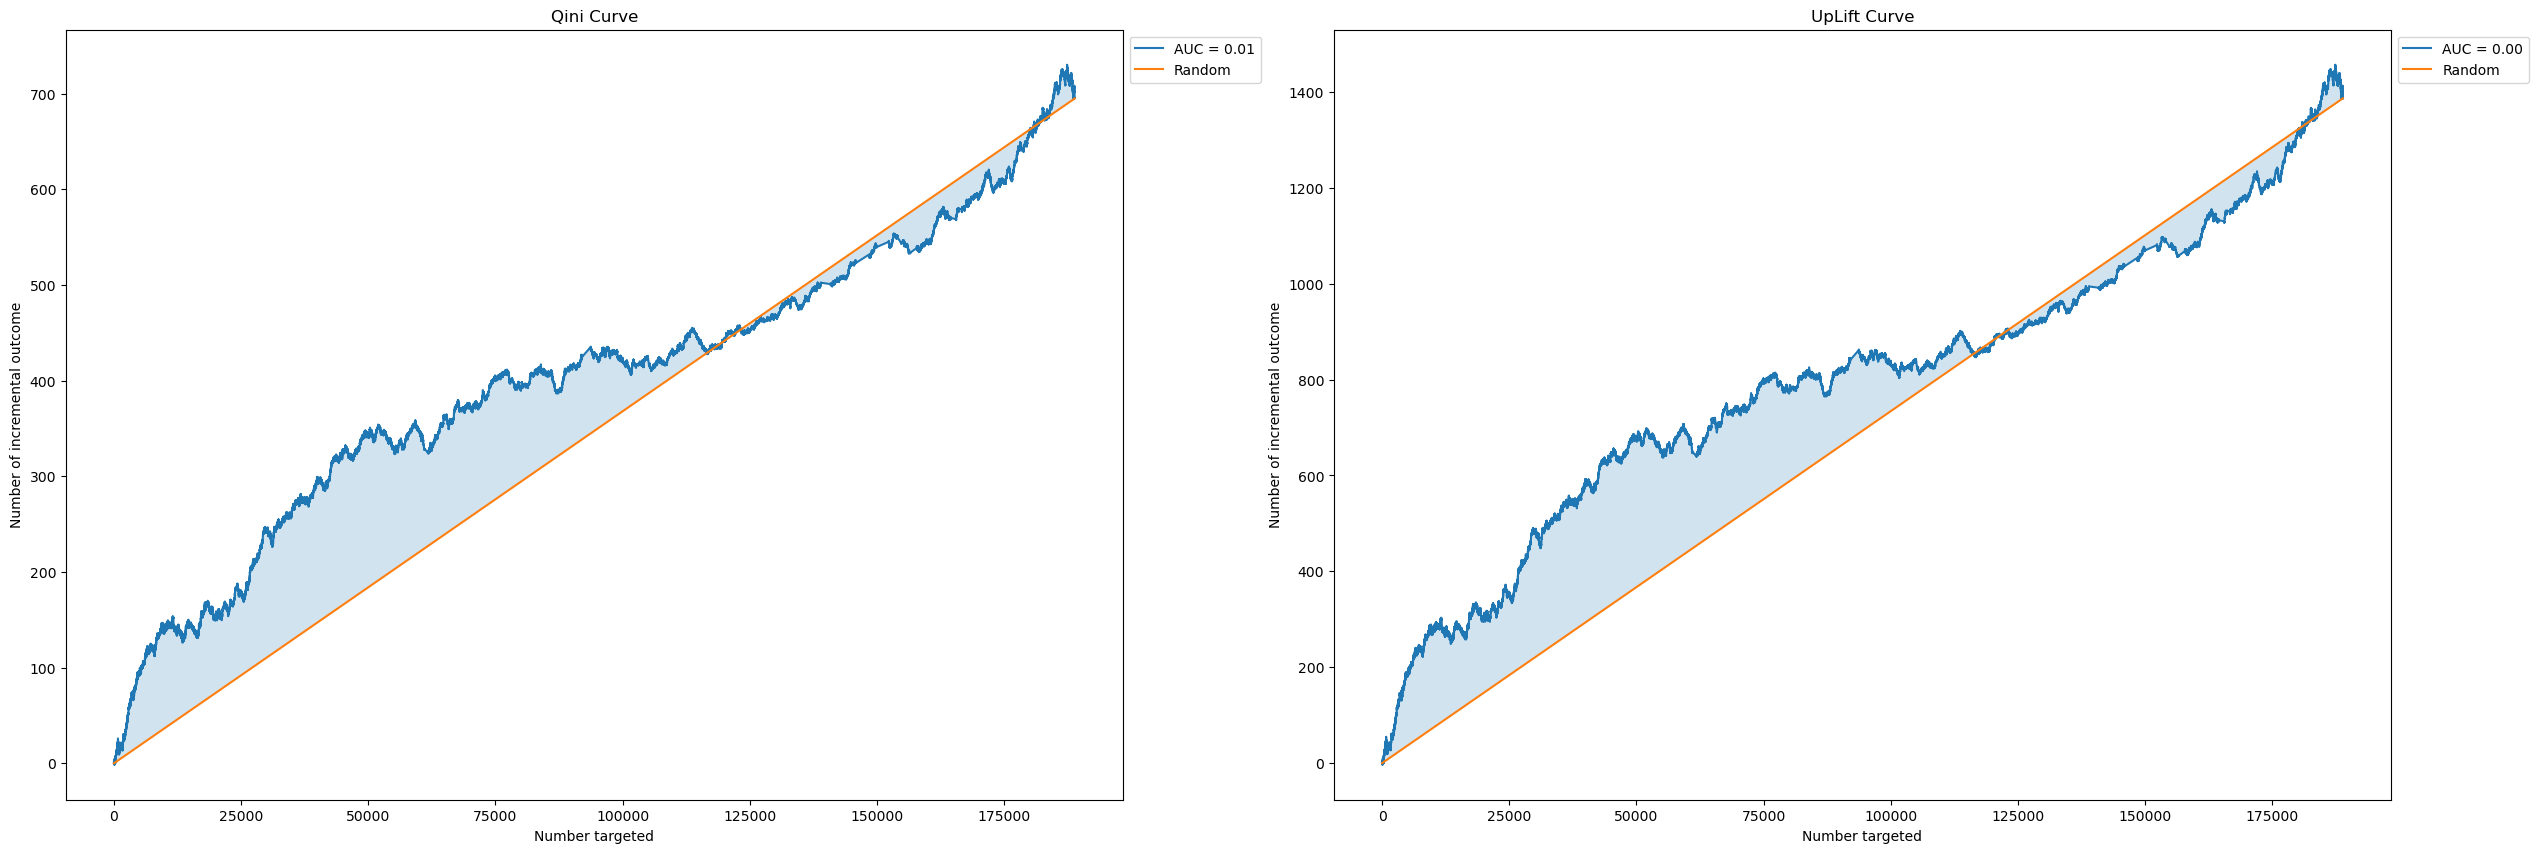

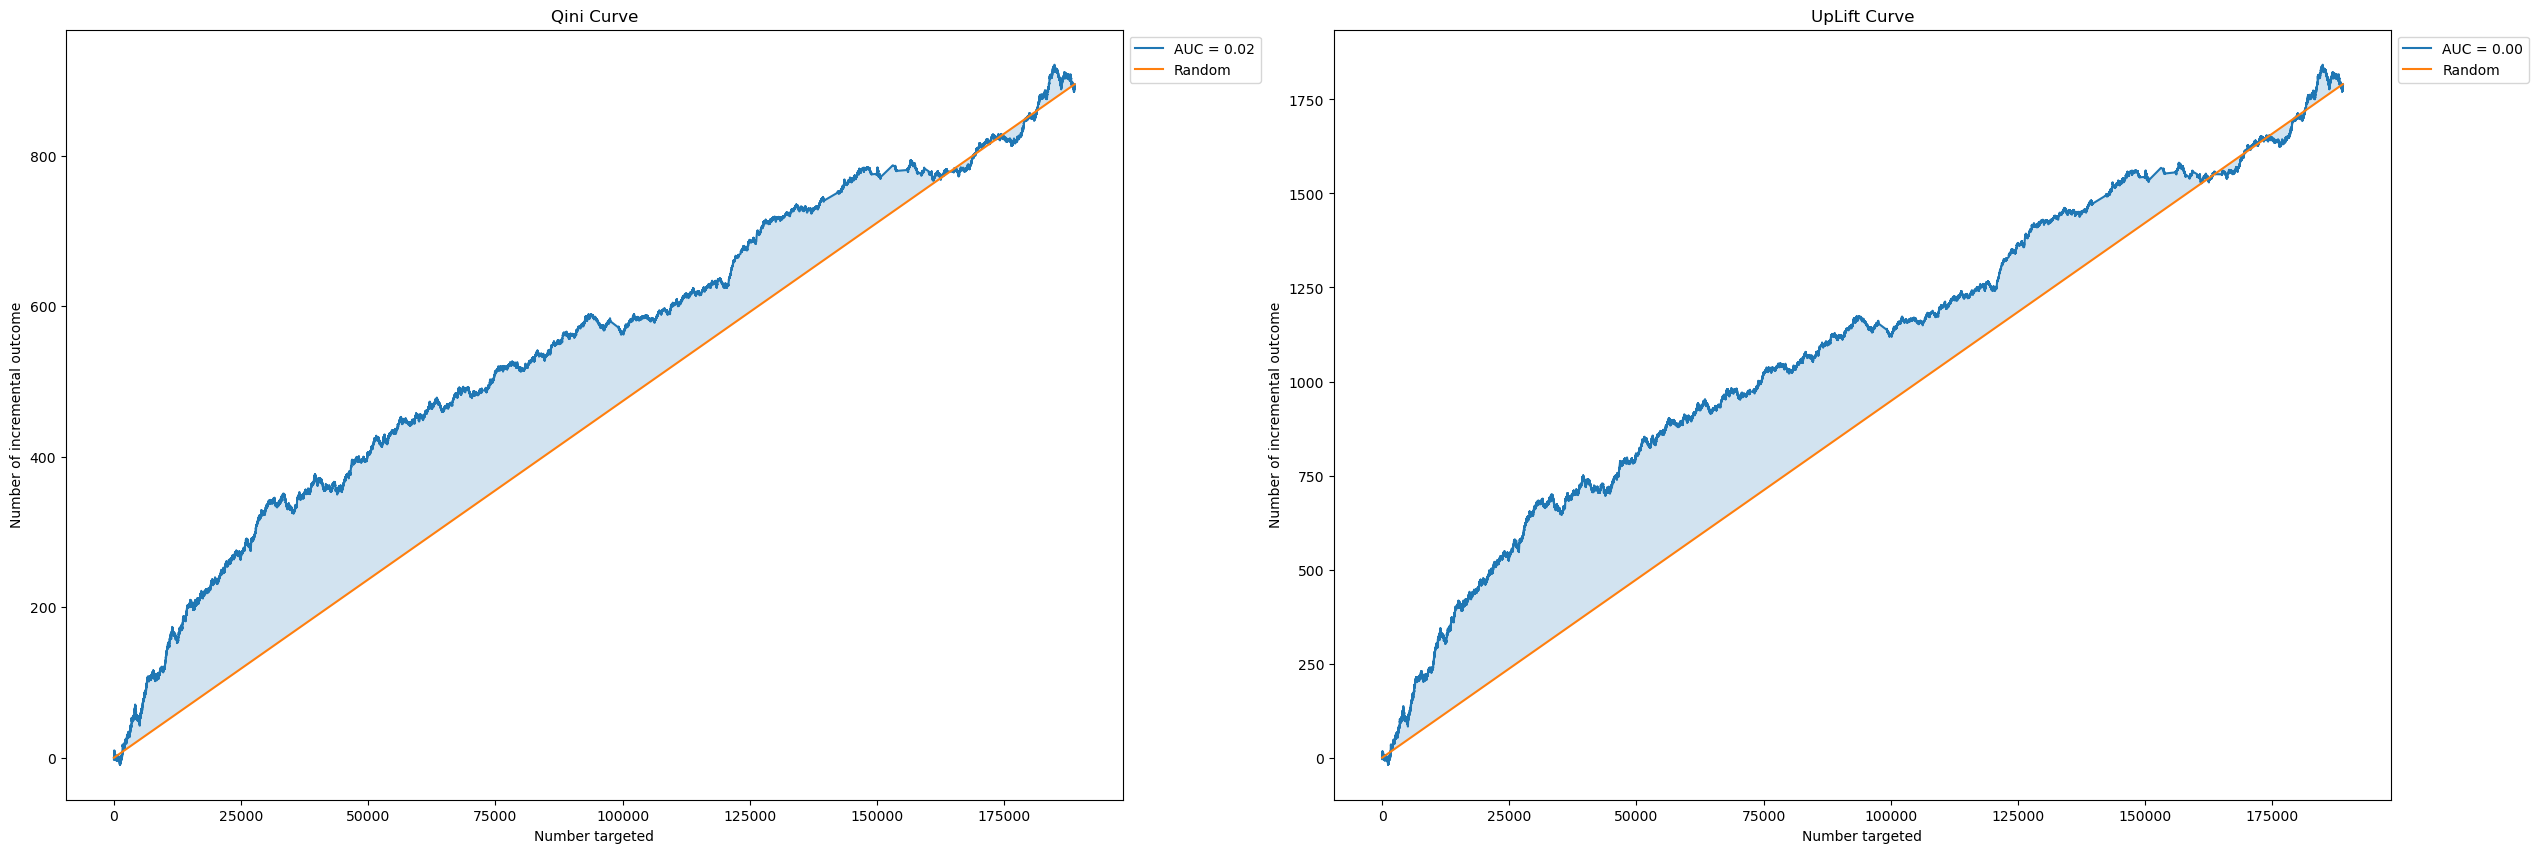

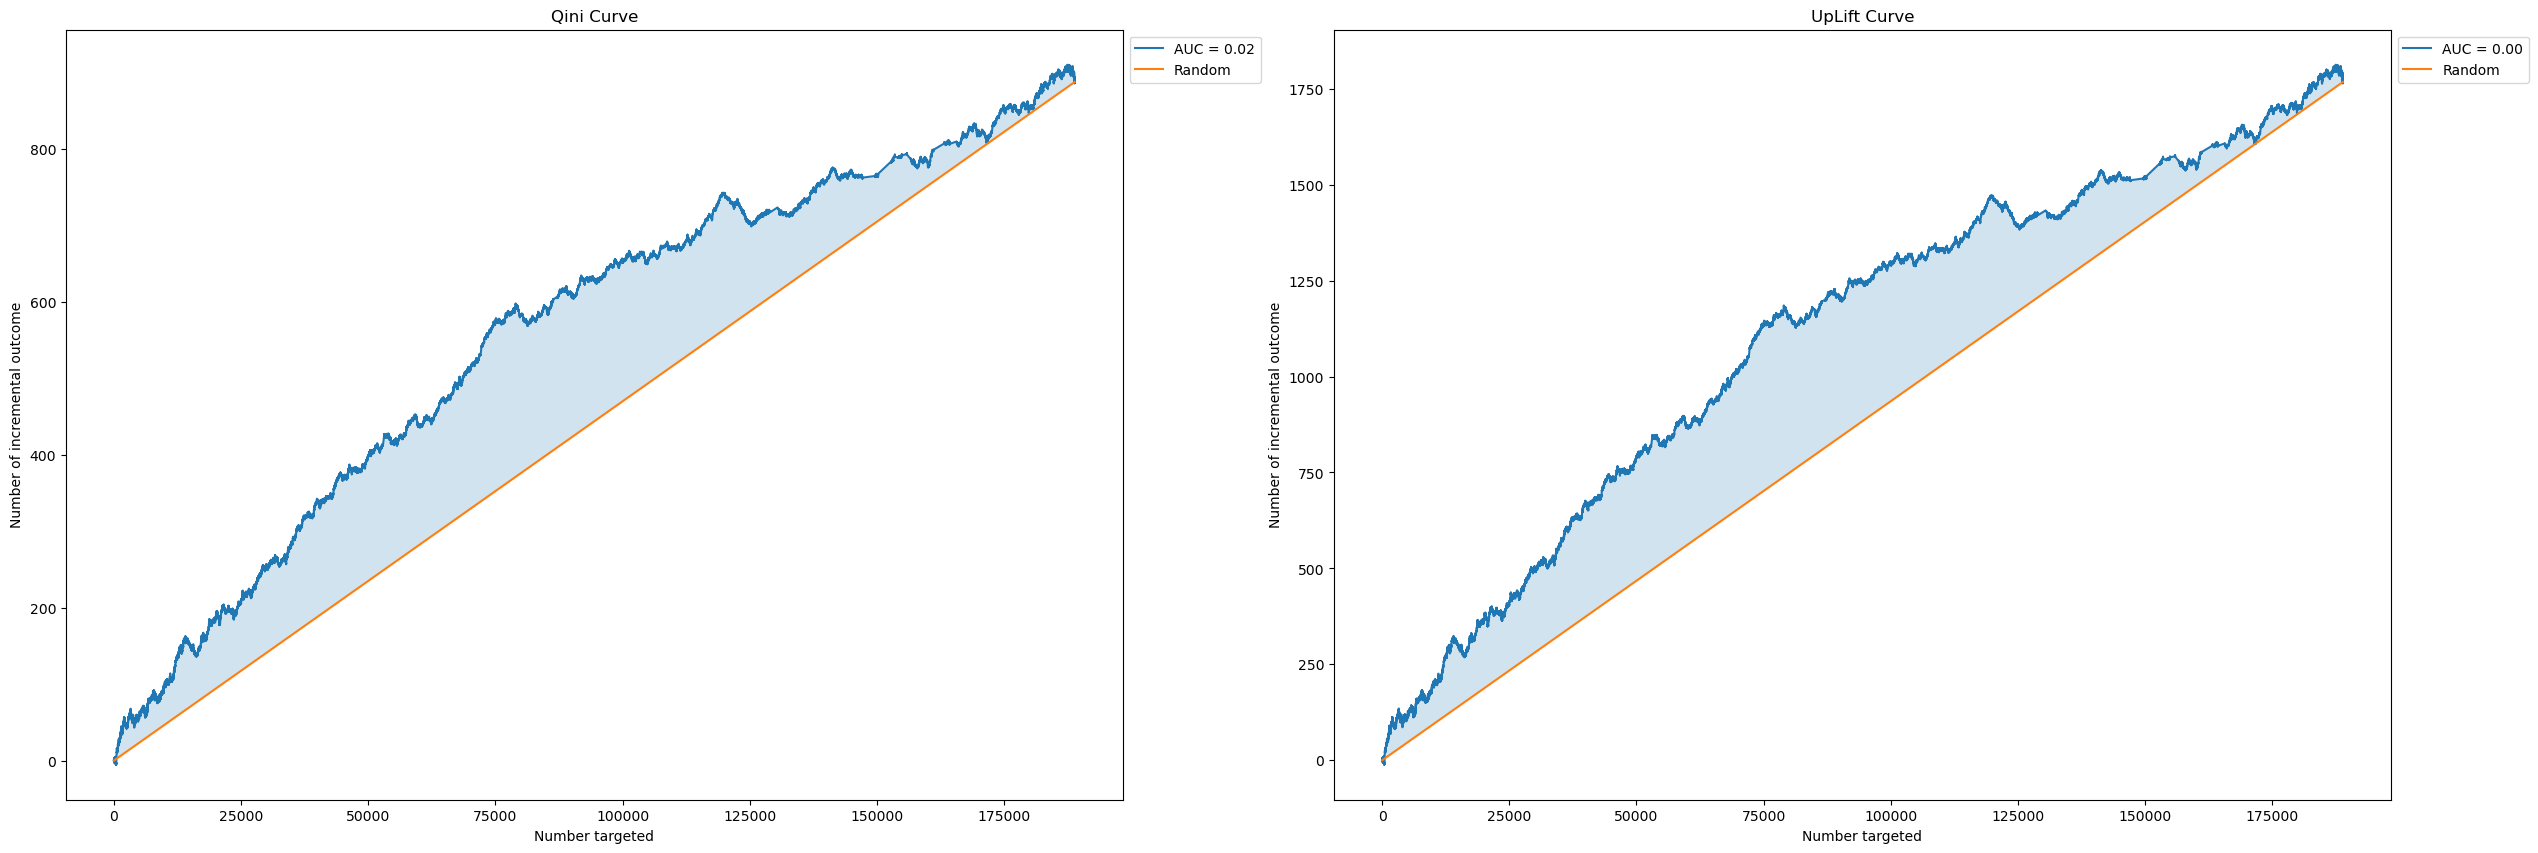

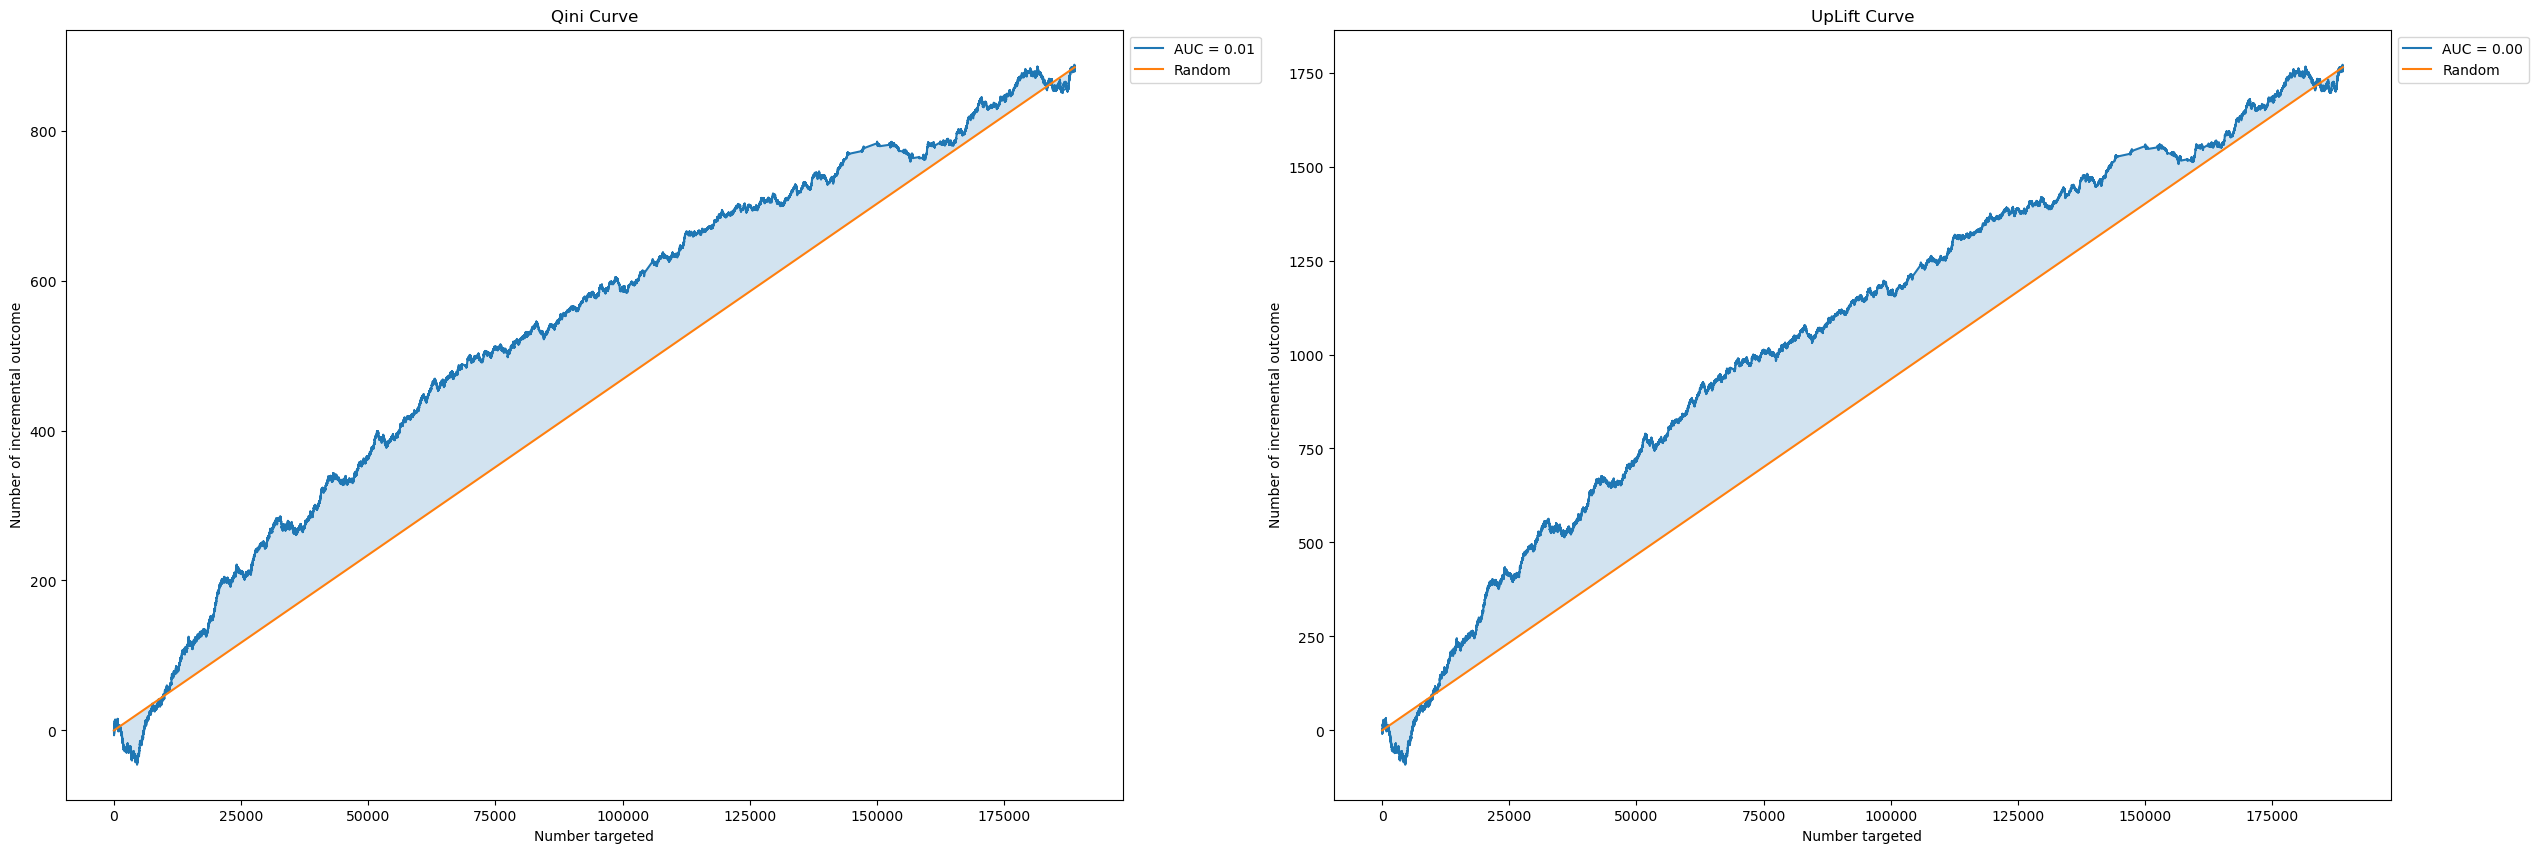

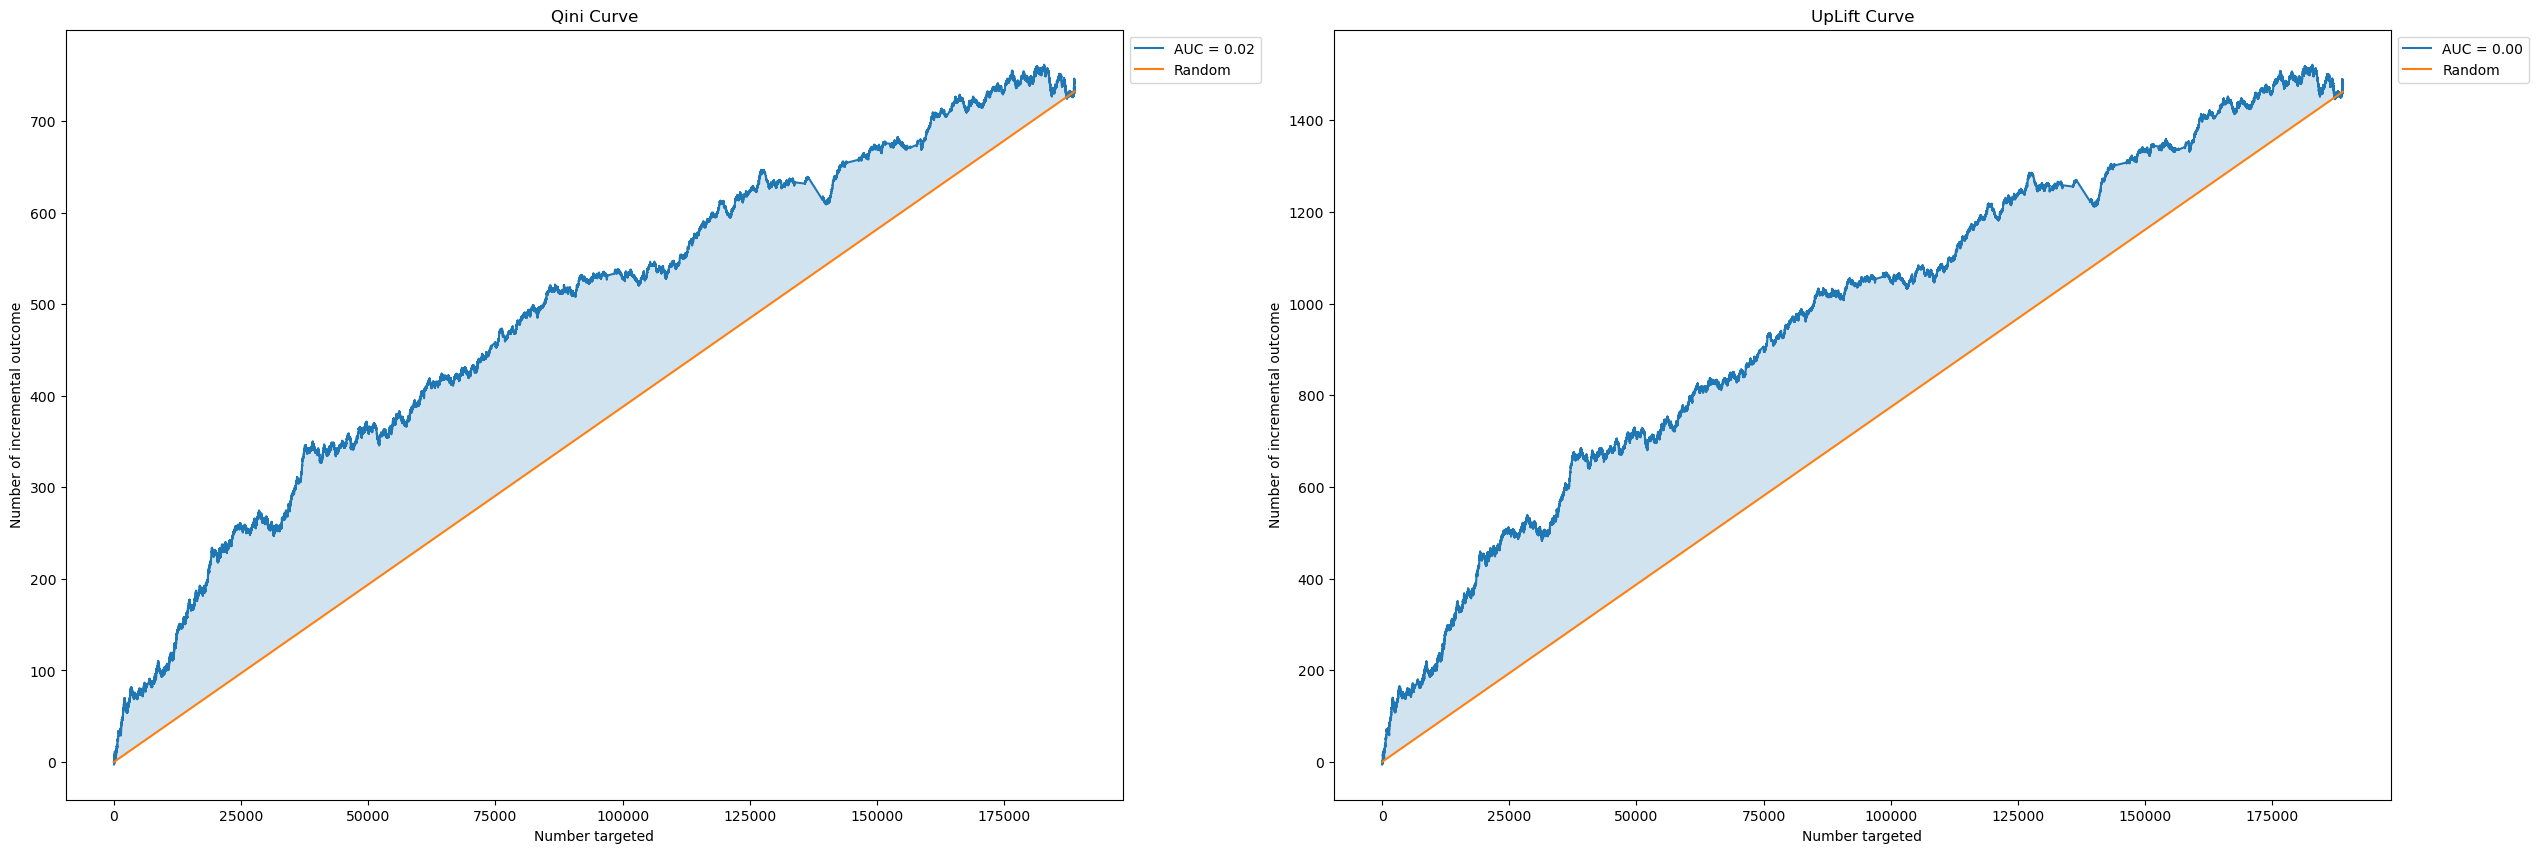

In [31]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_reg = CatBoostRegressor(verbose = 0)
      clf = ClassTransformationReg(estimator=catboost_reg, propensity_val=p)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/Trasnform Regression model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
      gc.collect()


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [32]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0138, grouped - 0.0144.
Qini AUC Score: 0.0155; UpLift AUC Score: 0.0038


In [33]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

39941

# AutoML Class

## Search PipeLine

In [34]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
proc_data = PrepocessingDataSetLetu()
proc_data.remove_colls(colls_to_drop)
X_data, Y_data = proc_data.preprocessing_data_solomodel(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X.shape)
print(y.shape)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  var_51  var_52  
7727314307  0.133248  0.000612  0.132788     1.0     0.0  
7721696179  0.000000  0.000000  0.000000     1.0     0.0  
7727261180  0.999200  0.000000  0.999200     1.0     0.0  
7725642339  0.000000  0.000000  0.000000     0.0     1.0  
7720389215  0.000000  0.000000  0.000000     0.0     1.0

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

(944419, 53)
(944419,)


In [35]:
import evalml
from evalml import AutoMLSearch

In [36]:
from evalml.objectives import get_optimization_objectives
from evalml.problem_types import ProblemTypes

for objective in get_optimization_objectives(ProblemTypes.BINARY):
    print(objective.name)

MCC Binary
Log Loss Binary
Gini
AUC
Precision
F1
Balanced Accuracy Binary
Accuracy Binary


In [37]:
X_train,X_test,y_train,y_test = evalml.preprocessing.utils.split_data(X, y, problem_type="binary")

In [38]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='binary'
                    , patience= 20
                    , verbose = True
                    , tolerance= 1e-12
                    , allow_long_running_models = True
                    , max_batches = 50
                    , objective = 'Gini'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 50
                    , holdout_set_size= 0
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Gini. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 50 batches for a total of 50 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Gini: 0.000

*****************************
* Evaluating Batch Number 1 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Gini: 0.391
Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler:
	Starting cross validation
	Finished cross validation - mean Gini: 0.415

*****************************
* Evaluating Batch Number 2 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler + RF Classifier Select From Model:
	Starting cross validation
	Finished cross validation - mean Gini: 0.322
Random

{1: {'Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler': '00:22',
  'Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler': '00:11',
  'Total time of batch': '00:34'},
 2: {'Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler + RF Classifier Select From Model': '00:17',
  'Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + RF Classifier Select From Model': '00:11',
  'Total time of batch': '00:30'},
 3: {'Decision Tree Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Select Columns Transformer': '00:09',
  'LightGBM Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Select Columns Transformer': '00:09',
  'Extra Trees Classifier w/ Label Encoder +

In [39]:
automl.save('automl_big_searching_class.cloudpickle')

## Train Best Pipeline

In [40]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching_class.cloudpickle')


In [41]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [42]:
ranks.to_csv('evalml_class_res.csv', index = False)

In [43]:
ranks.head()

pipeline_name  ranking_score  \
0            Stacked Ensemble Classification Pipeline       0.414692   
16  Random Forest Classifier w/ Label Encoder + Re...       0.414609   
17  LightGBM Classifier w/ Label Encoder + Replace...       0.406470   
18  XGBoost Classifier w/ Label Encoder + Replace ...       0.401770   
19  Random Forest Classifier w/ Label Encoder + Re...       0.394976   

    percent_better_than_baseline  \
0                            inf   
16                           inf   
17                           inf   
18                           inf   
19                           inf   

                                           parameters  
0   {'Label Encoder': {'positive_label': None}, 'L...  
16  {'Label Encoder': {'positive_label': None}, 'I...  
17  {'Label Encoder': {'positive_label': None}, 'I...  
18  {'Label Encoder': {'positive_label': None}, 'I...  
19  {'Label Encoder': {'positive_label': None}, 'I...

In [44]:
ranks.shape

(13, 4)

In [45]:

ranks.head(10).to_excel('class_res.xlsx')

In [46]:
ranks.iloc[0, :].parameters

{'Label Encoder': {'positive_label': None},
 'Linear Pipeline - Label Encoder': {'positive_label': None},
 'Linear Pipeline - Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Linear Pipeline - Undersampler': {'sampling_ratio': 0.25,
  'min_samples': 100,
  'min_percentage': 0.1,
  'sampling_ratio_dict': None},
 'Linear Pipeline - Logistic Regression Classifier': {'penalty': 'l2',
  'C': 1.0,
  'n_jobs': -1,
  'multi_class': 'auto',
  'solver': 'lbfgs'},
 'Random Forest Pipeline - Label Encoder': {'positive_label': None},
 'Random Forest Pipeline - Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Random Forest Pip

In [47]:
best_clf = automl.best_pipeline
type(best_clf)

evalml.pipelines.binary_classification_pipeline.BinaryClassificationPipeline

In [48]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
proc_data = PrepocessingDataSetLetu()
proc_data.remove_colls(colls_to_drop)
X_data, Y_data = proc_data.preprocessing_data_solomodel(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X.shape)
print(y.shape)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  var_51  var_52  
7727314307  0.133248  0.000612  0.132788     1.0     0.0  
7721696179  0.000000  0.000000  0.000000     1.0     0.0  
7727261180  0.999200  0.000000  0.999200     1.0     0.0  
7725642339  0.000000  0.000000  0.000000     0.0     1.0  
7720389215  0.000000  0.000000  0.000000     0.0     1.0

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

(944419, 53)
(944419,)


UpLift at 30%: overall - 0.023816, grouped - 0.024121.
Qini AUC Score: 0.057379; UpLift AUC Score: 0.01446
UpLift at 30%: overall - 0.023447, grouped - 0.023931.
Qini AUC Score: 0.052497; UpLift AUC Score: 0.012992
UpLift at 30%: overall - 0.022487, grouped - 0.023531.
Qini AUC Score: 0.054177; UpLift AUC Score: 0.013604
UpLift at 30%: overall - 0.023688, grouped - 0.023867.
Qini AUC Score: 0.052274; UpLift AUC Score: 0.013063
UpLift at 30%: overall - 0.022835, grouped - 0.023635.
Qini AUC Score: 0.054999; UpLift AUC Score: 0.013925
UpLift at 30%: overall - 0.0233, grouped - 0.0238.
Qini AUC Score: 0.0543; UpLift AUC Score: 0.0136


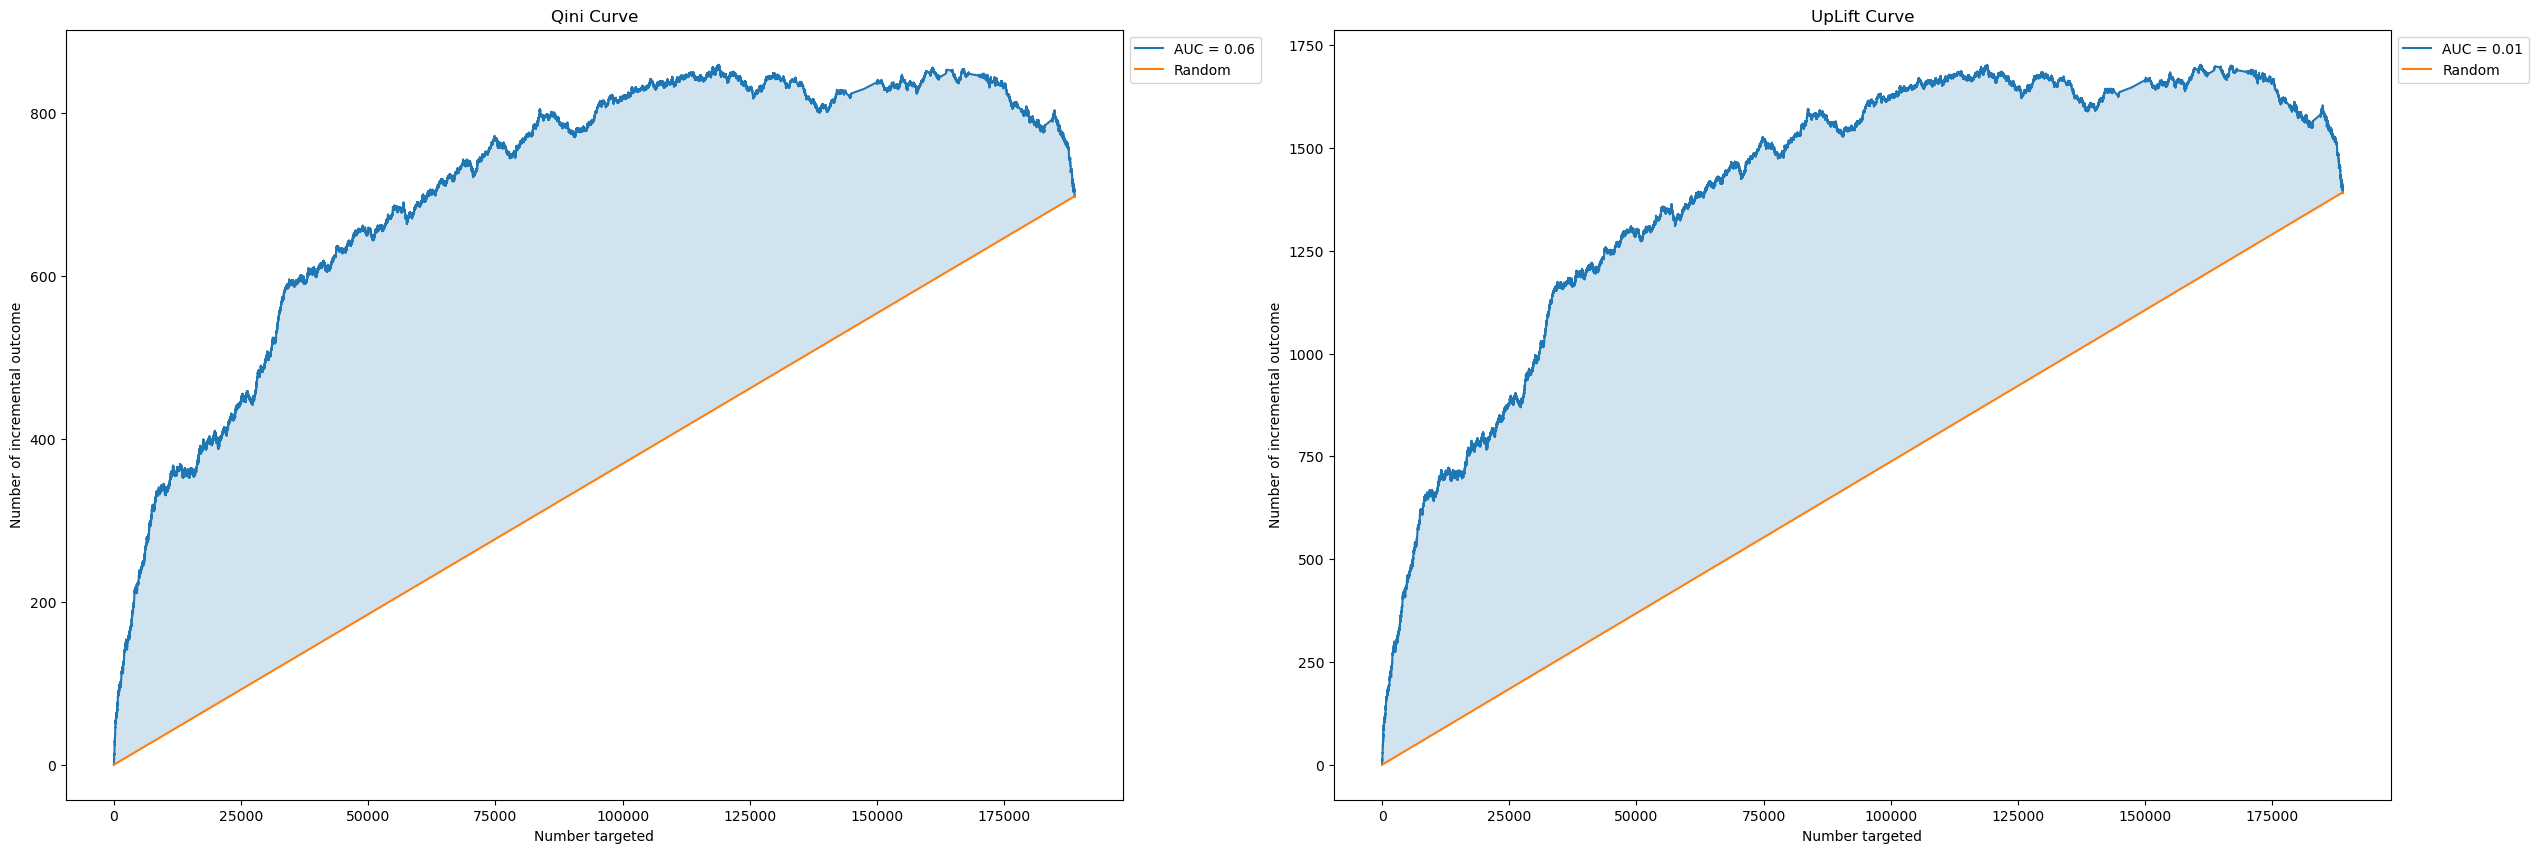

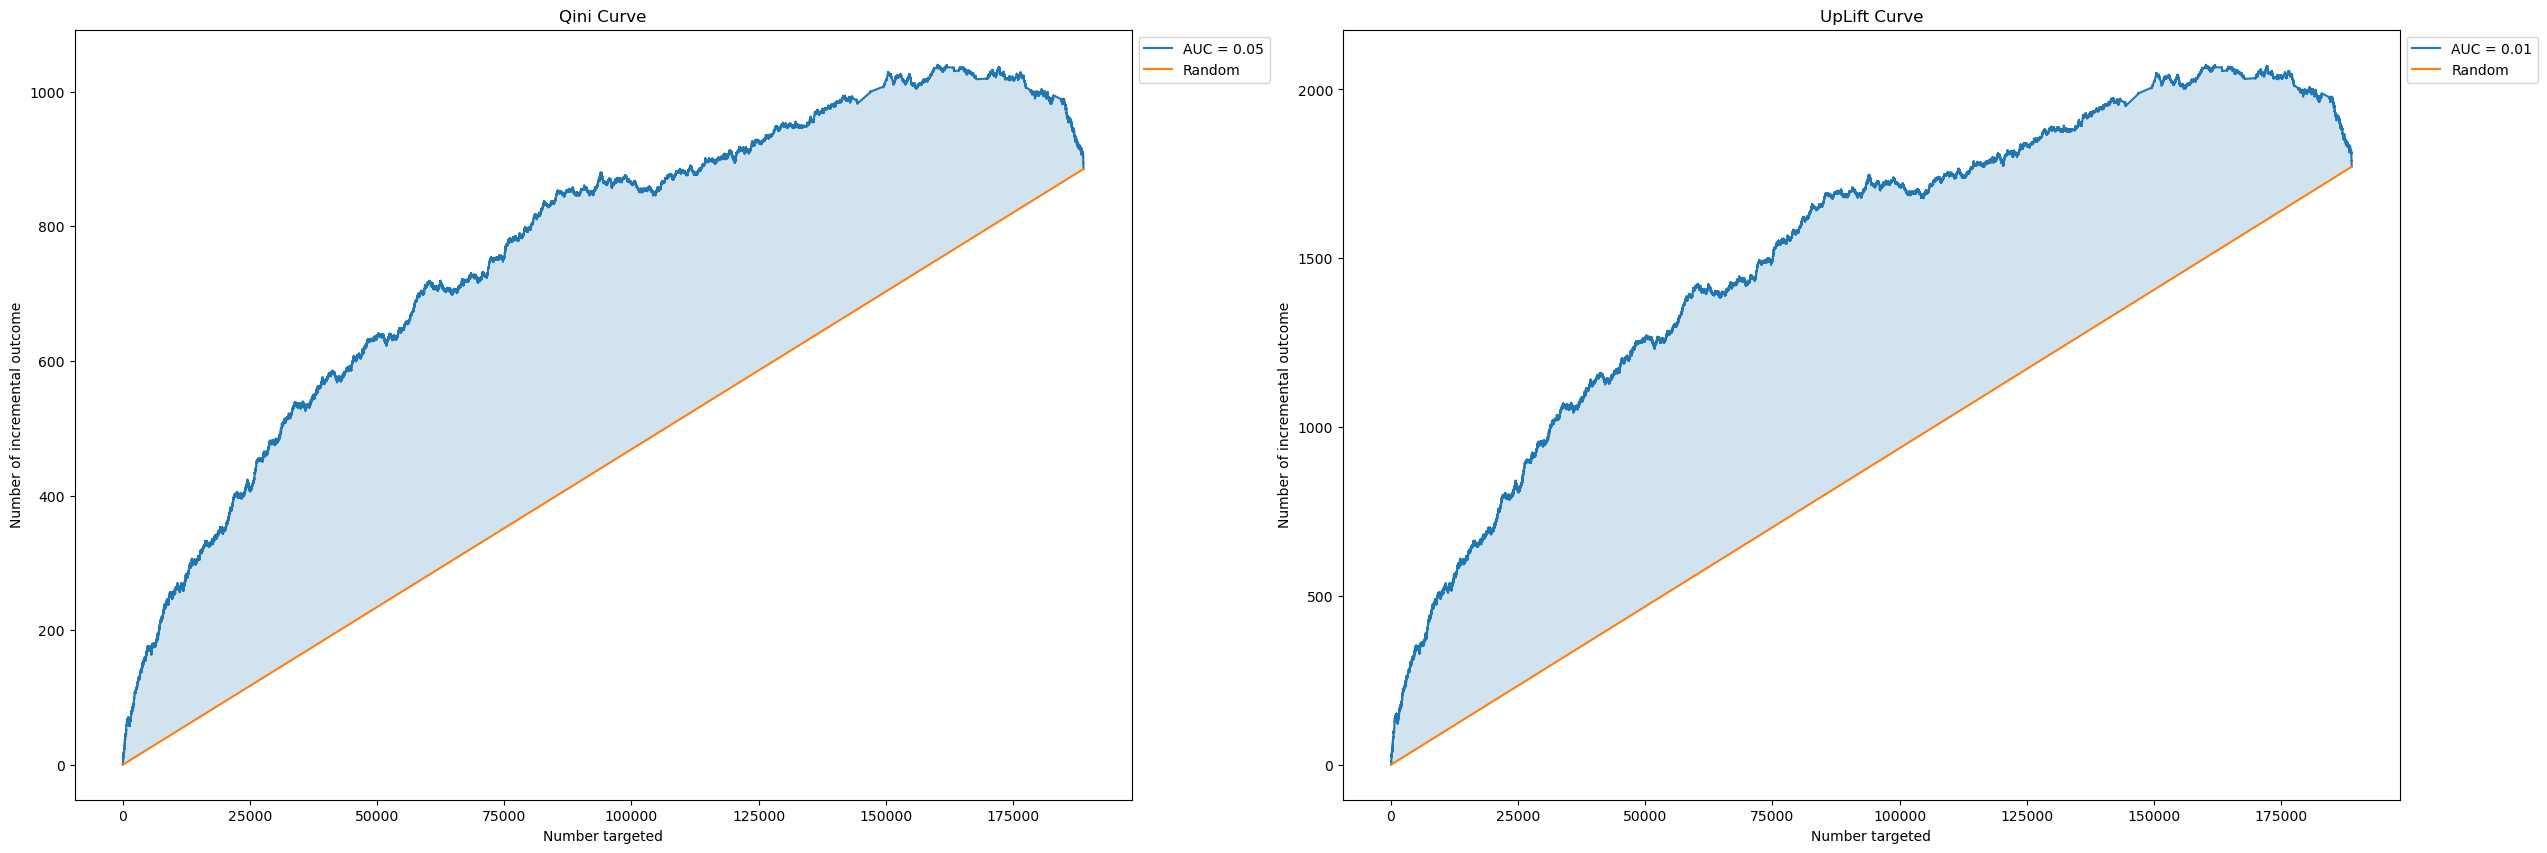

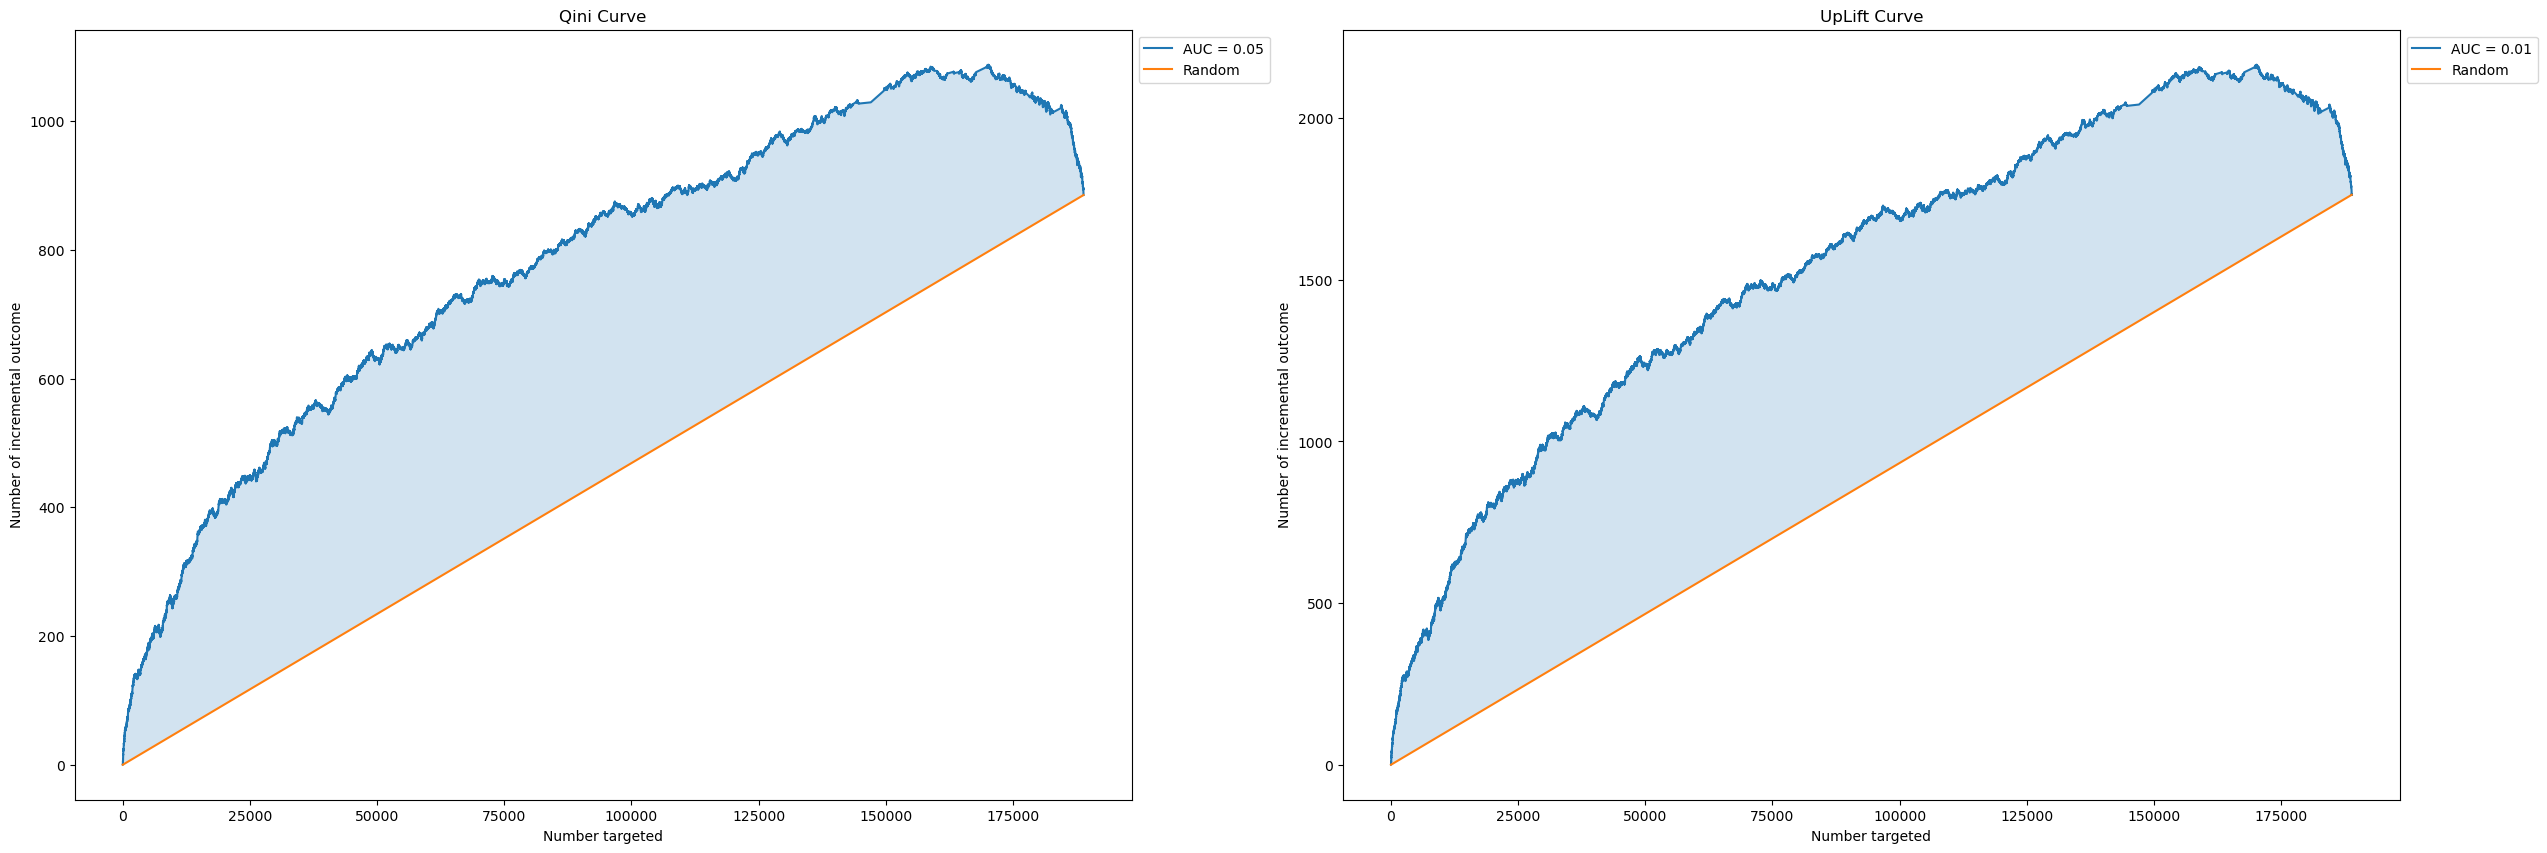

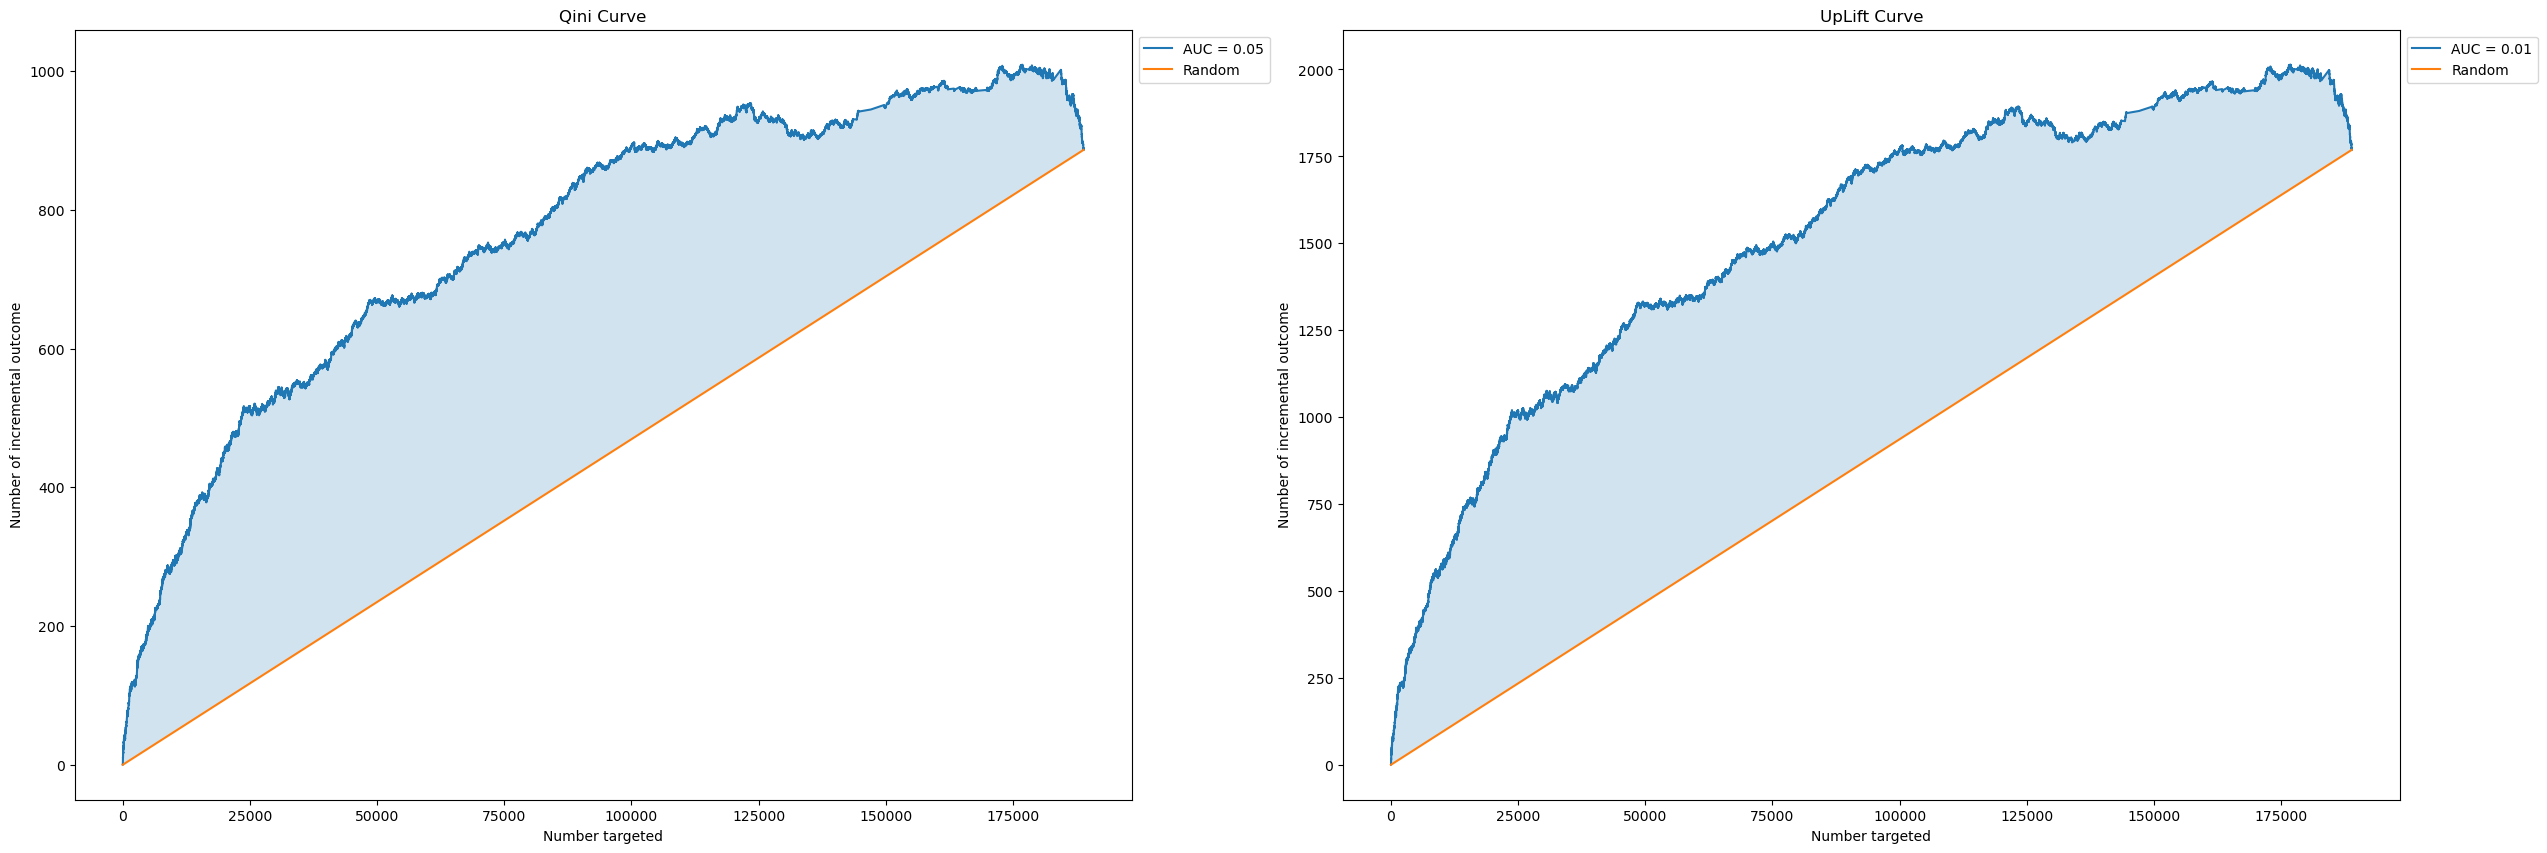

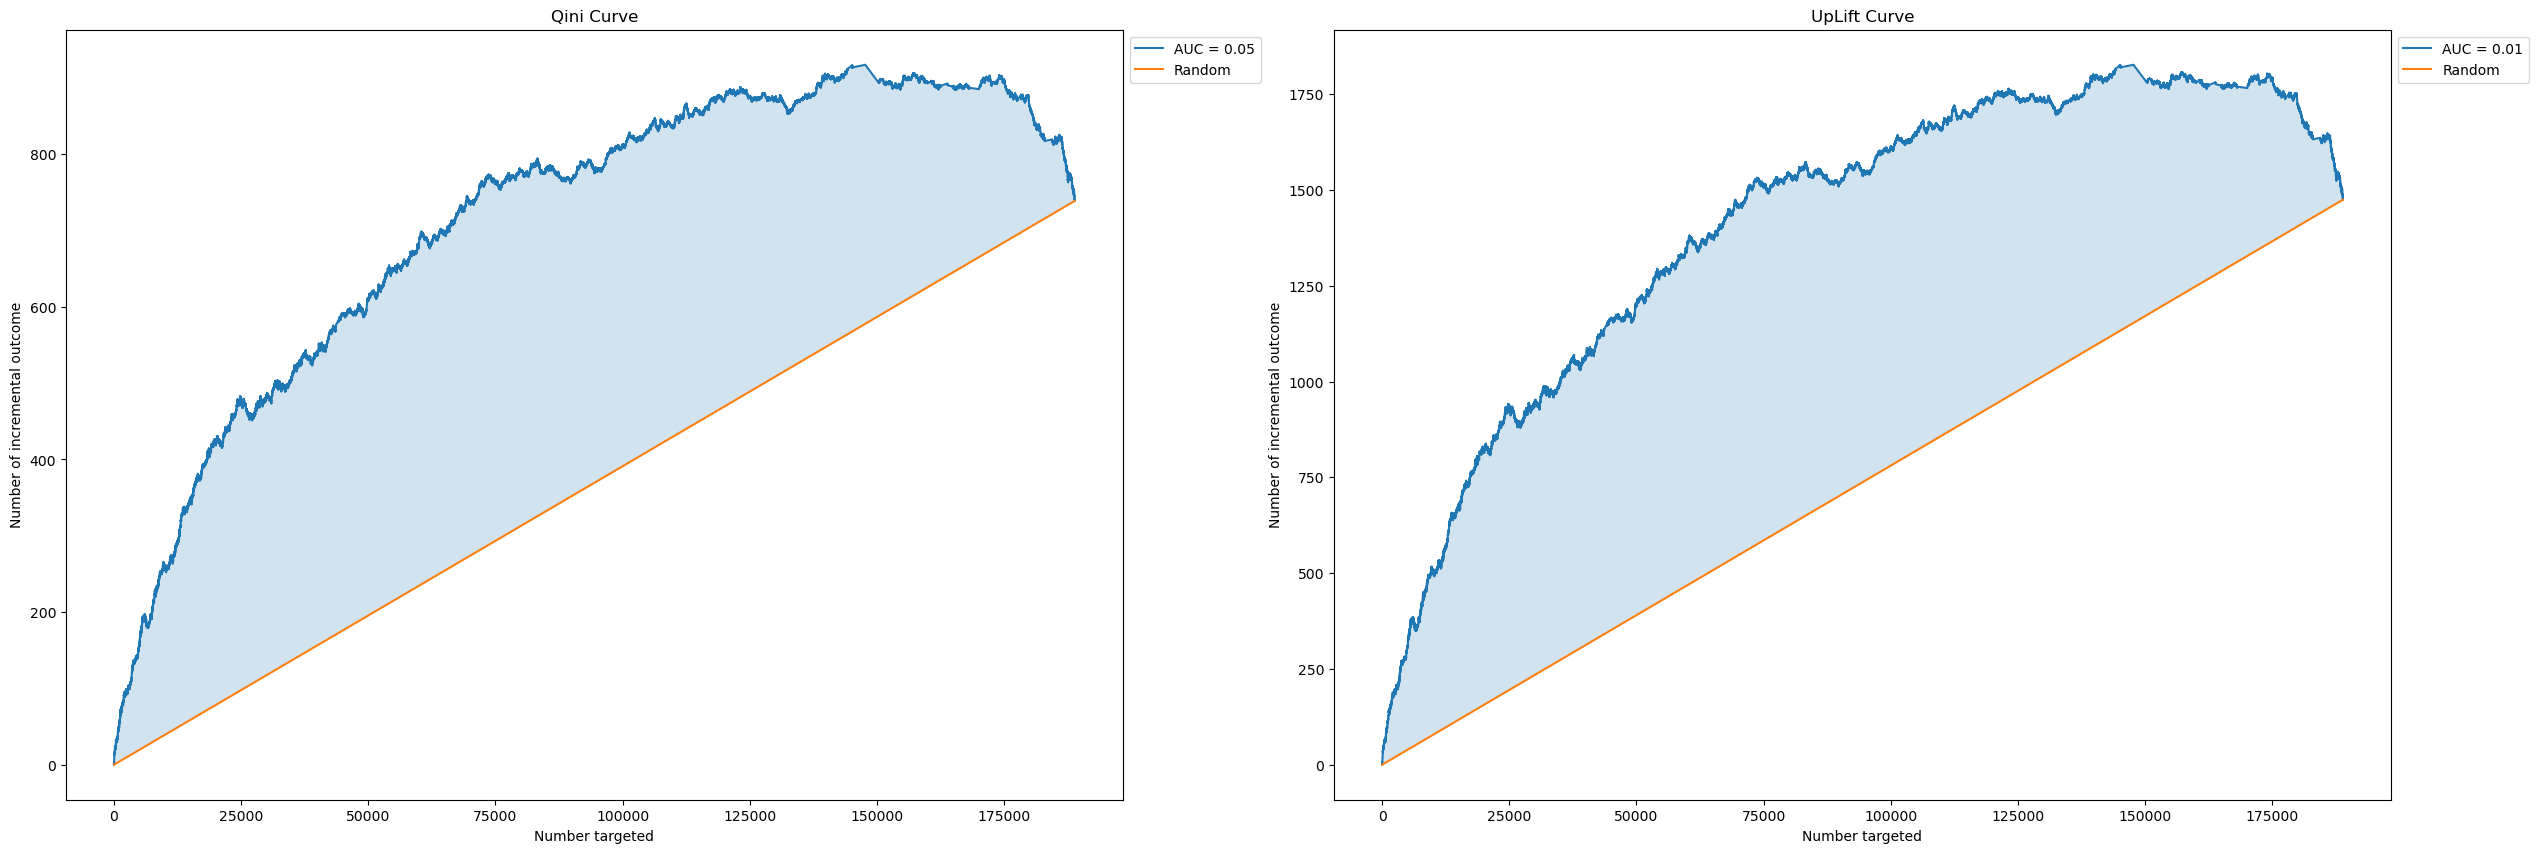

In [49]:
import copy
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      best_clf  = copy.deepcopy(automl.best_pipeline)
      best_clf.fit(X_train_, y_train_)
      X_test_[:, -2:] = proc_data.ohe_solomodel.transform(np.zeros(shape = treat[test_index].shape).reshape(-1, 1)).toarray()
      y_pred0 = best_clf.predict_proba(X_test_)[[1]]
      X_test_[:, -2:] = proc_data.ohe_solomodel.transform(np.ones(shape = treat[test_index].shape).reshape(-1, 1)).toarray()
      y_pred1 = best_clf.predict_proba(X_test_)[[1]]
      y_pred = np.squeeze(y_pred1 - y_pred0).tolist()
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/CLassification EvalML model Procentile Split Overall {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
      gc.collect()


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [50]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0233, grouped - 0.0238.
Qini AUC Score: 0.0543; UpLift AUC Score: 0.0136


# AutoML Reg

## Search PipeLine

In [51]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values.astype(float)
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[-0. -0. -0. ...  0. -0.  0.]
0.5011176183452472


In [52]:
import evalml
from evalml import AutoMLSearch

In [53]:
# from evalml.objectives import get_optimization_objectives
# from evalml.problem_types import ProblemTypes

# for objective in get_optimization_objectives(ProblemTypes.REGRESSION):
#     print(objective.name)

In [54]:
X_train,X_test,y_train,y_test= evalml.preprocessing.utils.split_data(X, y, problem_type="regression")

In [55]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , patience= 20
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 20
                    , objective = 'MSE'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 20
                    , holdout_set_size= 0
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for MSE. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 20 batches for a total of 20 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271

*****************************
* Evaluating Batch Number 1 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.180e+03, tolerance: 5.104e+00



Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271

*****************************
* Evaluating Batch Number 2 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271

*****************************
* Evaluating Batch Number 3 *
*****************************

Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer:
	Starting cross validation
	Finished

{1: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler': '00:18',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer': '00:34',
  'Total time of batch': '00:53'},
 2: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model': '00:32',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model': '00:44',
  'Total time of batch': '01:17'},
 3: {'Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:06',
  'Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:16',
  'XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:13',
  'CatBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:06',
  'LightGBM Regressor w/ Replace

In [56]:
automl.save('automl_big_searching.cloudpickle')

## Train Best Pipeline

In [57]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching.cloudpickle')


In [58]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [59]:
ranks.to_csv('evalml_res.csv', index = False)

In [60]:
ranks.head()

pipeline_name  ranking_score  \
0  CatBoost Regressor w/ Replace Nullable Types T...       0.270921   
1  Elastic Net Regressor w/ Replace Nullable Type...       0.270925   
2                  Mean Baseline Regression Pipeline       0.270931   
3  Elastic Net Regressor w/ Replace Nullable Type...       0.270931   
6  Random Forest Regressor w/ Replace Nullable Ty...       0.270952   

   percent_better_than_baseline  \
0                      0.003873   
1                      0.002225   
2                      0.000000   
3                      0.000000   
6                     -0.007626   

                                          parameters  
0  {'Imputer': {'categorical_impute_strategy': 'm...  
1  {'Imputer': {'categorical_impute_strategy': 'm...  
2       {'Baseline Regressor': {'strategy': 'mean'}}  
3  {'Imputer': {'categorical_impute_strategy': 'm...  
6  {'Imputer': {'categorical_impute_strategy': 'm...

In [61]:
ranks.shape

(13, 4)

In [62]:

ranks.head(10).to_excel('res.xlsx')

In [63]:
ranks.iloc[0, :].parameters

{'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Select Columns Transformer': {'columns': [3,
   5,
   11,
   14,
   18,
   19,
   20,
   22,
   23,
   25,
   26,
   27,
   28,
   30,
   33,
   35,
   36,
   37,
   40,
   43,
   45,
   46,
   47,
   48,
   49,
   50]},
 'CatBoost Regressor': {'n_estimators': 10,
  'eta': 0.03,
  'max_depth': 6,
  'bootstrap_type': None,
  'silent': False,
  'allow_writing_files': False,
  'n_jobs': -1}}

In [64]:
ctbst  = automl.best_pipeline
type(ctbst)

evalml.pipelines.regression_pipeline.RegressionPipeline

In [65]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'] + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  \
7727314307    0.0     1.0     0.0     0.0     1.0     0.0     1.0     0.0   
7721696179    0.0     0.0     1.0     1.0     0.0     1.0     0.0     1.0   
7727261180    0.0     1.0     0.0     0.0     1.0     1.0     0.0     0.0   
7725642339    0.0     0.0     1.0     0.0     1.0     1.0     0.0     1.0   
7720389215    0.0     0.0     1.0     1.0     0.0     0.0     1.0     1.0   

            var_17  var_18    var_19    var_20    var_21    var_22    var_23  \
7727314307     1.0    0.36  0.375158  0.061079  0.485123 -0.117576  0.061079   
7721696179     0.0    0.51 -1.139324 -0.596416 -0.959642 -0.688107 -0.596416   
7727261180     1.0    0.32 -0.897007 -0.596416  1.929889 -0.688107 -0.596416   
7725642339     0.0    0.36  0.920371 -0.411111 -0.237259 -0.366515 -0.411111   
7720389215     0.0    0.36  2.041088 -0.286736 -0.237259 -0.150667 -0.286736   

              var_24    var_25    var_26    var_27    var_28    var_29  \
7727314307  0.485123 -0.366343  1.189951 -0.350021 -0.044128 -0.101755   
7721696179 -0.959642  1.809404 -0.578192 -0.497771 -0.401348 -0.130310   
7727261180  1.929889  9.498559  8.227301  6.020620 -0.401348 -0.130310   
7725642339 -0.237259 -0.440387 -0.578192 -0.497771 -0.302121 -0.130310   
7720389215 -0.237259 -0.420452 -0.578192 -0.497771 -0.232661 -0.130310   

               var_30    var_31    var_32    var_33    var_34    var_35  \
7727314307  -0.372036  1.315213 -0.079914  0.079069 -0.079914  0.079069   
7721696179   2.024490 -0.591057 -0.079914 -0.607844 -0.079914 -0.607844   
7727261180  10.112767  8.940291 -0.079914 -0.607844 -0.079914 -0.607844   
7725642339  -0.372036 -0.591057 -0.079914 -0.417034 -0.079914 -0.417034   
7720389215  -0.372036 -0.591057 -0.079914 -0.283468 -0.079914 -0.283468   

              var_36    var_37    var_38    var_39    var_40    var_41  \
7727314307  1.770311  0.832397  0.715997 -0.104949  1.869892  2.017748   
7721696179 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7727261180  5.367603 -0.376713  2.040167 -0.150001 -0.176325 -0.285620   
7725642339 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   
7720389215 -0.643915 -0.376713 -0.608174 -0.150001 -0.176325 -0.285620   

              var_42    var_43    var_44    var_45    var_46    var_47  \
7727314307  1.705137  1.068648  0.979353  0.161937 -0.010406  0.077401   
7721696179 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7727261180  5.236338 -0.387464  2.593746 -1.620882  0.332533 -0.376318   
7725642339 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   
7720389215 -0.648998 -0.387464 -0.635040  0.432061  0.332533  0.401486   

              var_48    var_49    var_50  
7727314307  0.133248  0.000612  0.132788  
7721696179  0.000000  0.000000  0.000000  
7727261180  0.999200  0.000000  0.999200  
7725642339  0.000000  0.000000  0.000000  
7720389215  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[-0. -0. -0. ...  0. -0.  0.]
0.5011176183452472


UpLift at 30%: overall - 0.016557, grouped - 0.01746.
Qini AUC Score: 0.02929; UpLift AUC Score: 0.007248
UpLift at 30%: overall - 0.01731, grouped - 0.018289.
Qini AUC Score: 0.030196; UpLift AUC Score: 0.007338
UpLift at 30%: overall - 0.021437, grouped - 0.022352.
Qini AUC Score: 0.037427; UpLift AUC Score: 0.009247
UpLift at 30%: overall - 0.018562, grouped - 0.01868.
Qini AUC Score: 0.027598; UpLift AUC Score: 0.006739
UpLift at 30%: overall - 0.015856, grouped - 0.017442.
Qini AUC Score: 0.032303; UpLift AUC Score: 0.008043
UpLift at 30%: overall - 0.0179, grouped - 0.0188.
Qini AUC Score: 0.0314; UpLift AUC Score: 0.0077


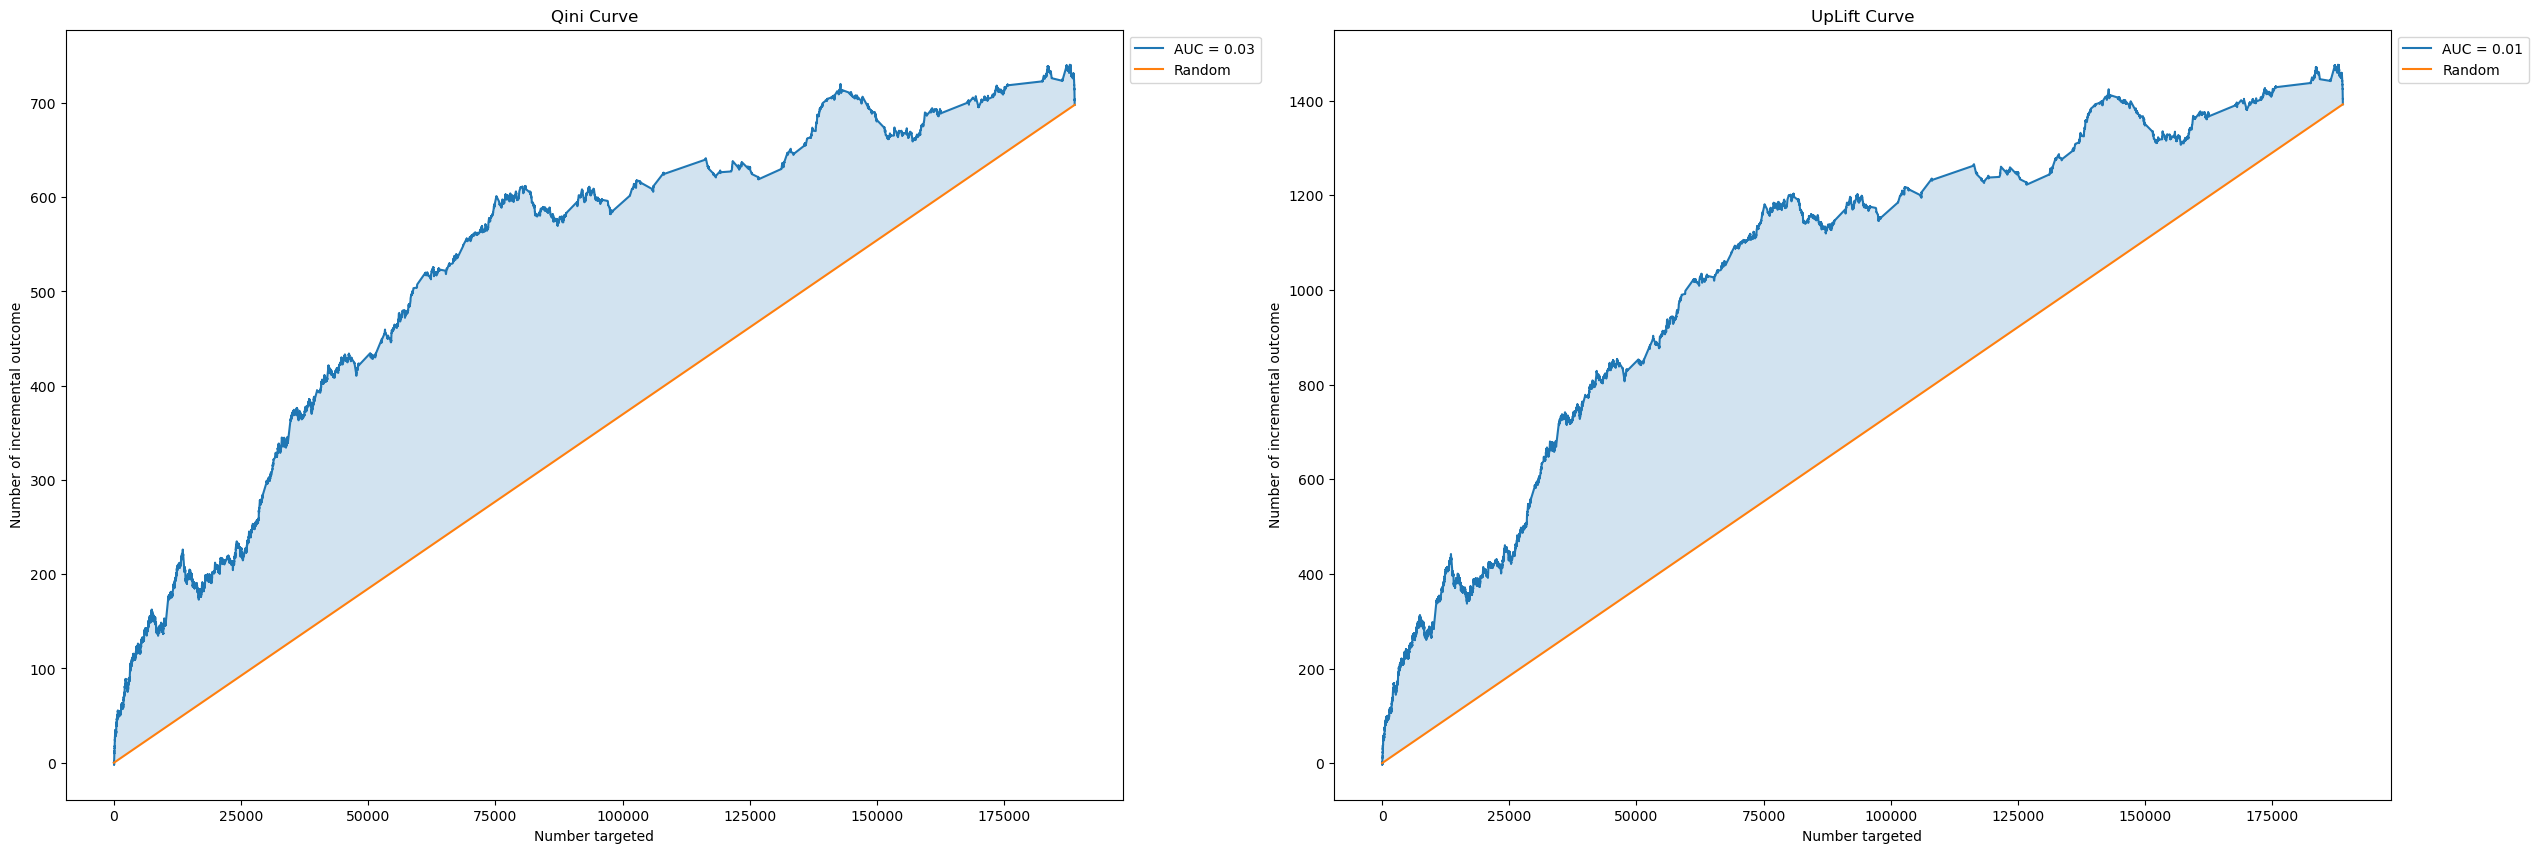

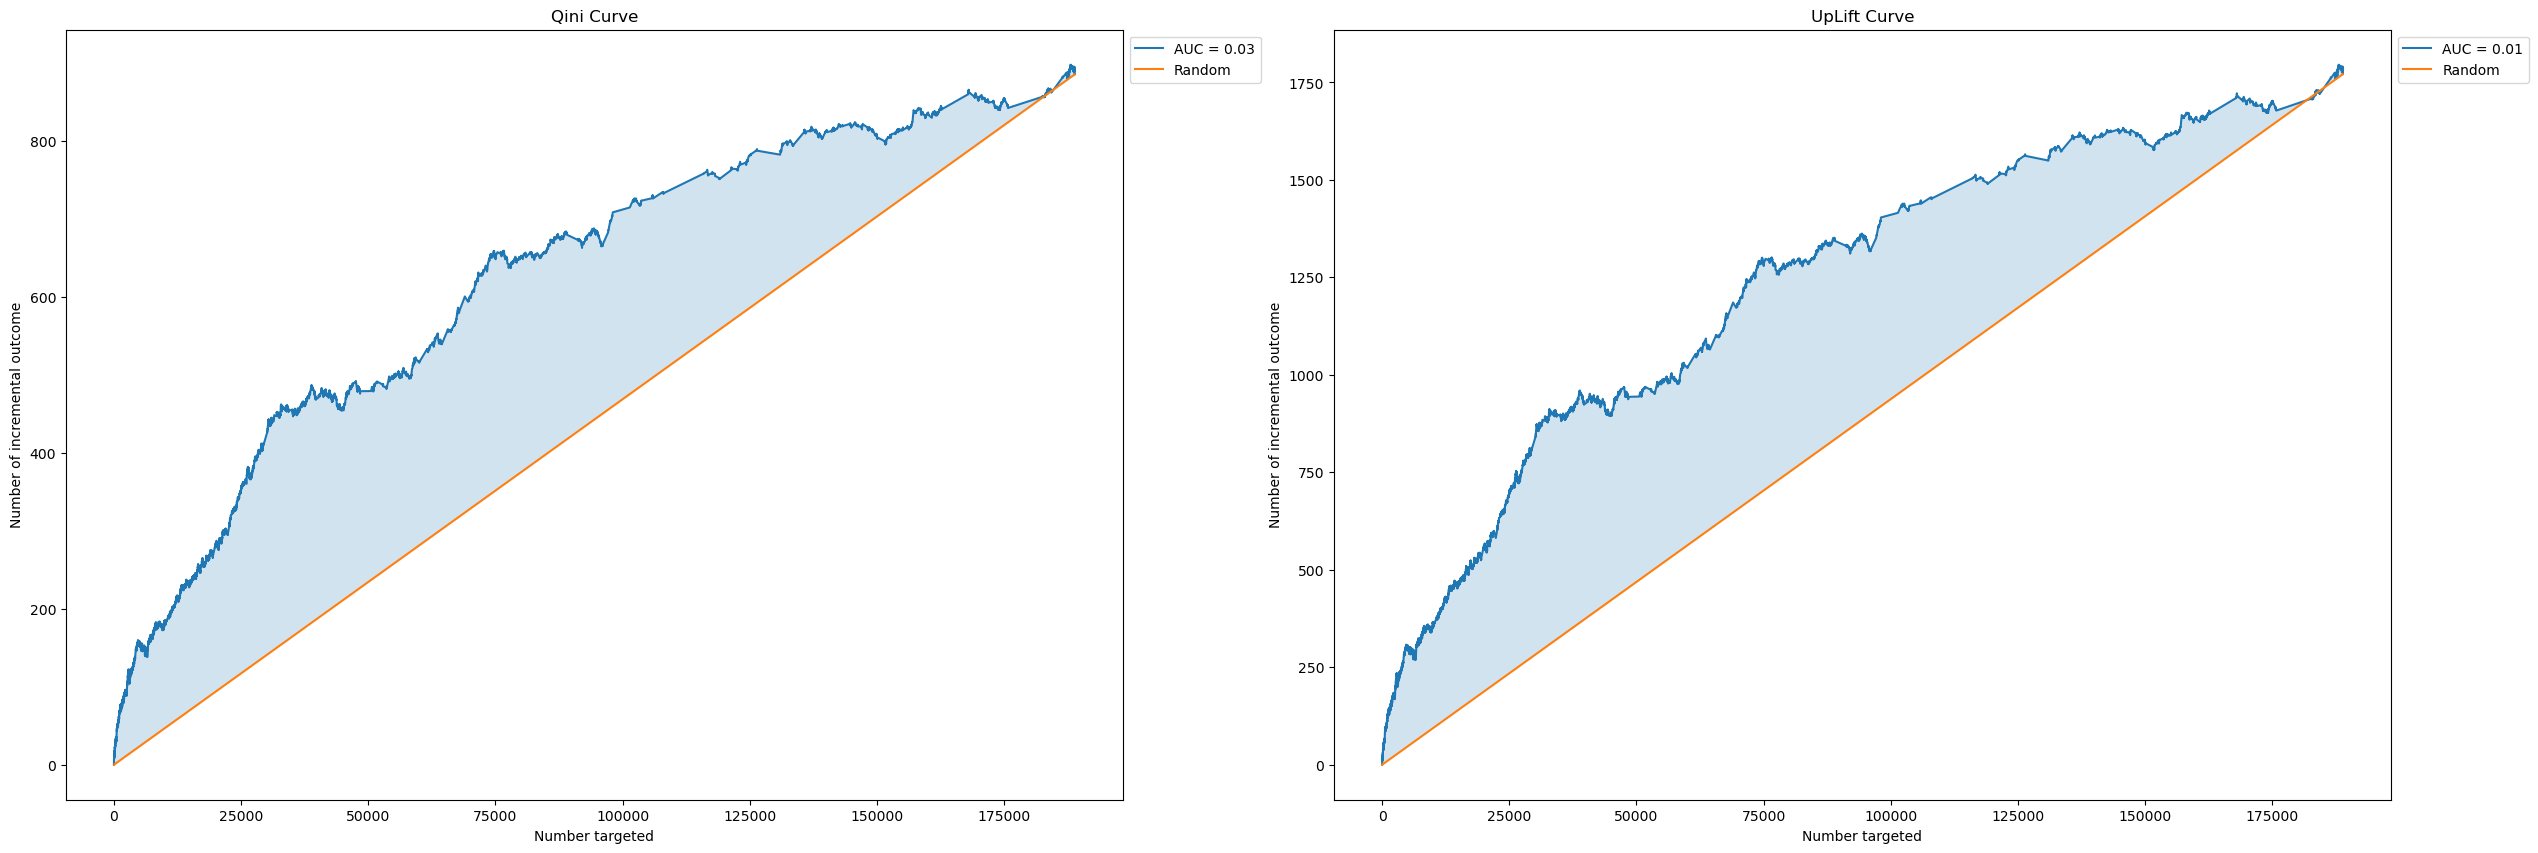

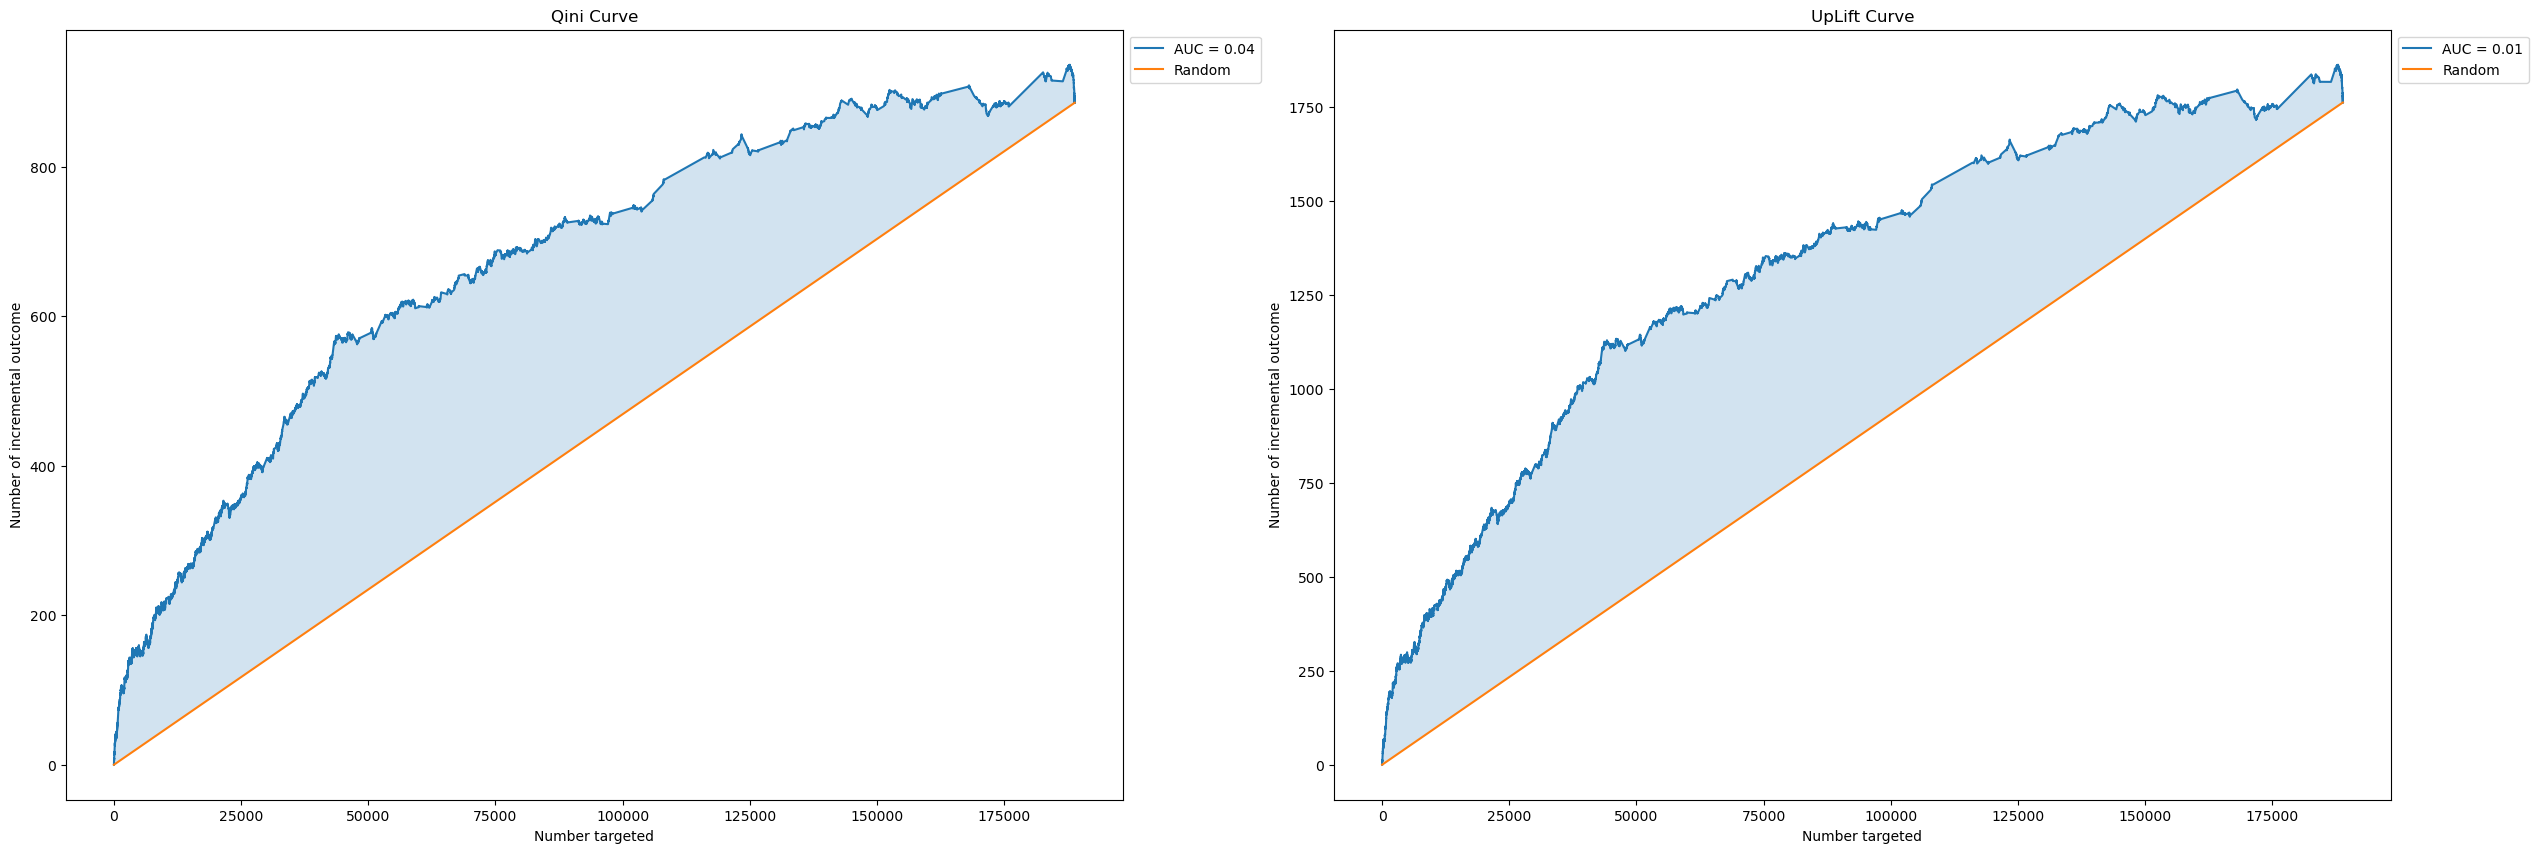

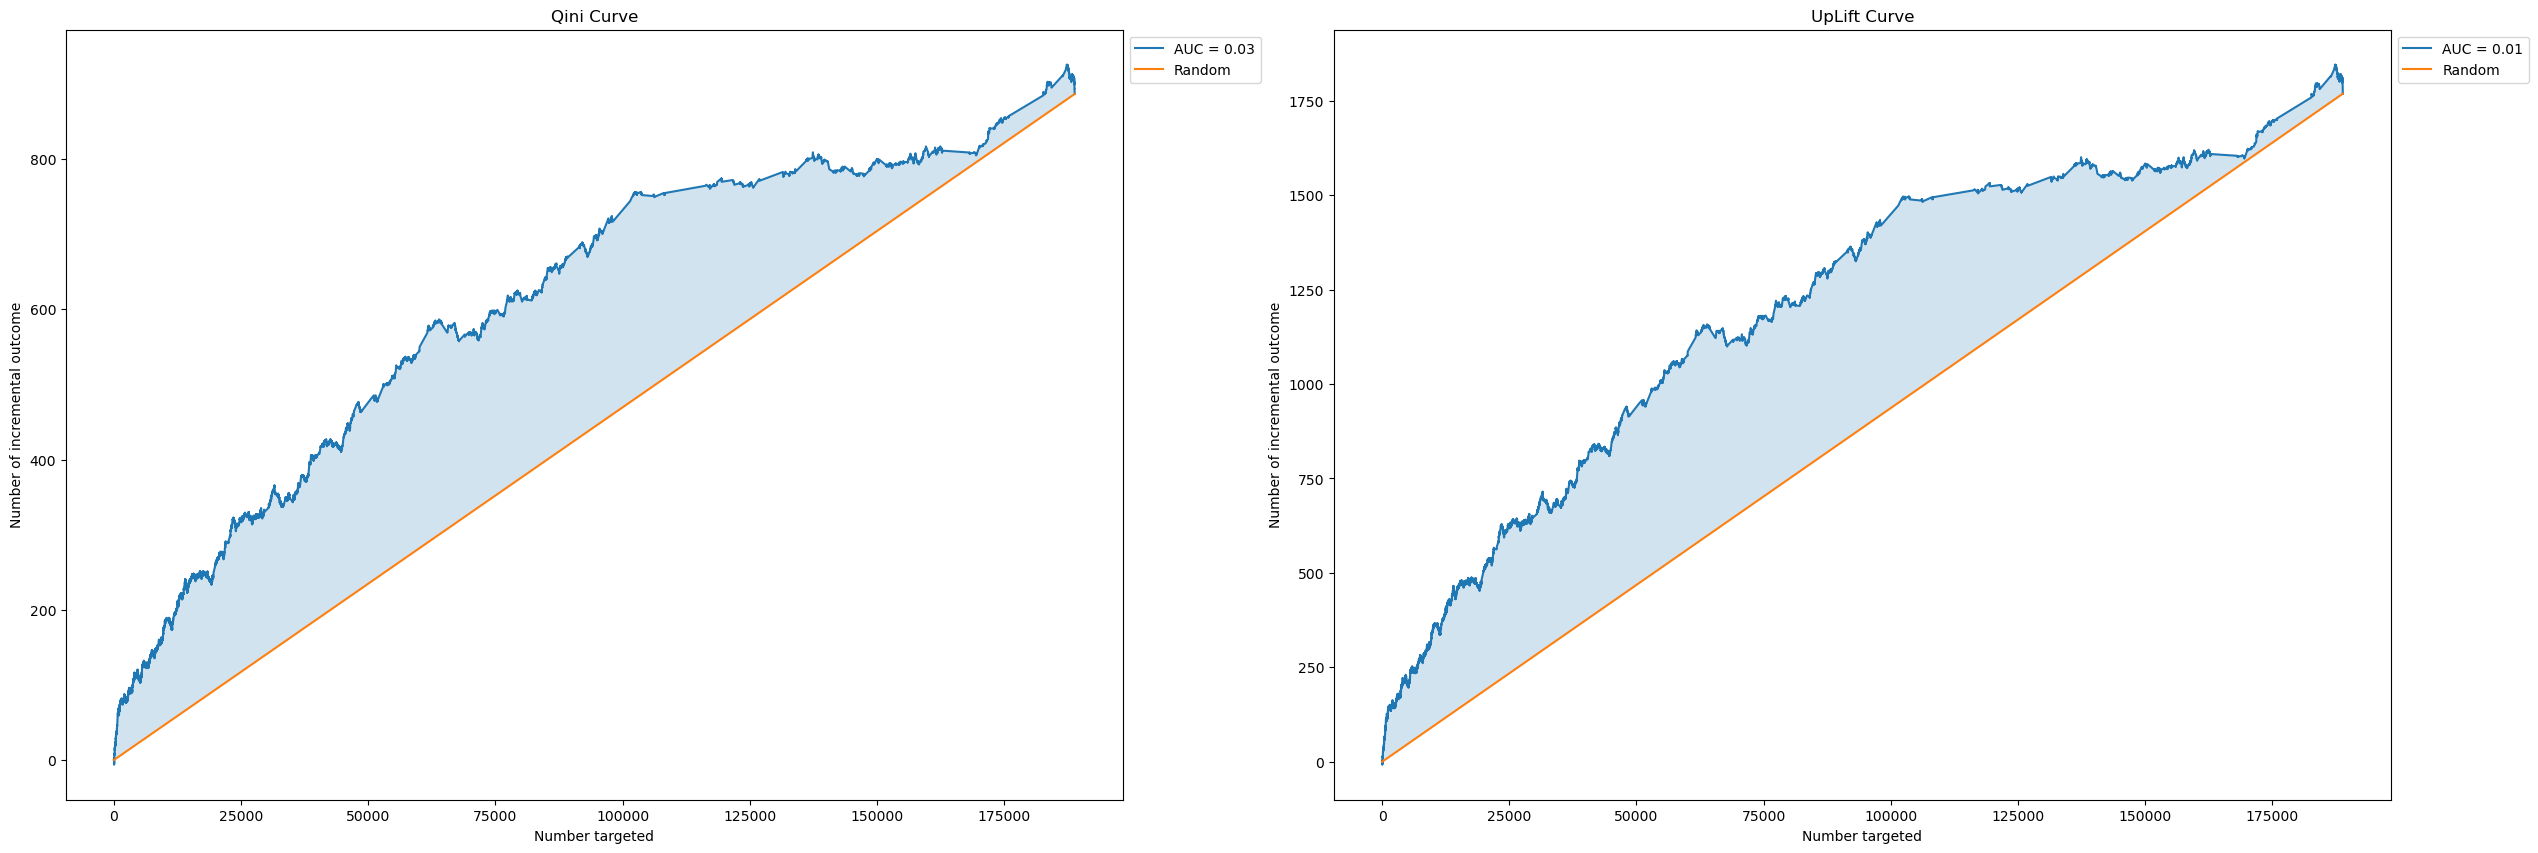

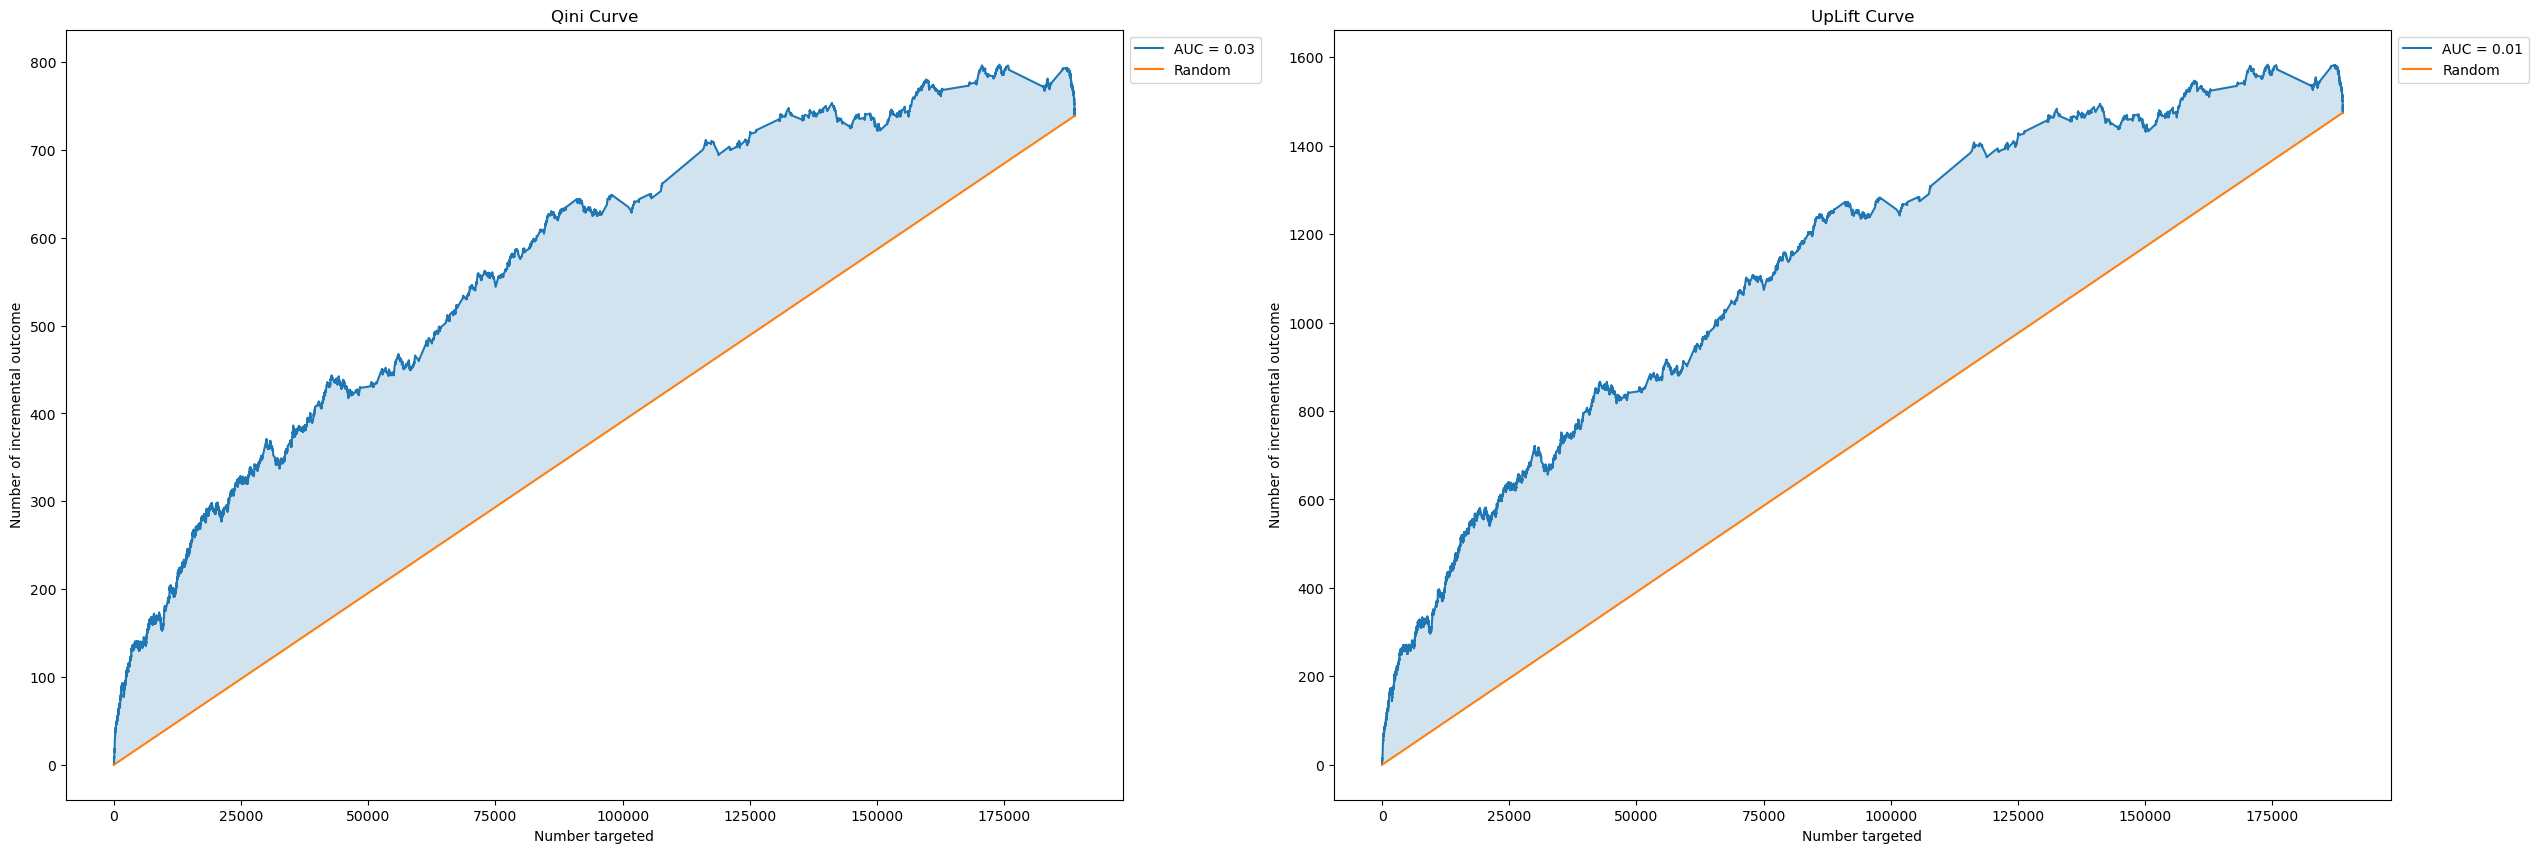

In [66]:
import copy
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst.fit(X_train_, y_train_)
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_ 
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(targ[test_index], treat[test_index], y_pred, f"Plots/Trasnform Regression EvalML model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics['qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
      gc.collect()


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [67]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0179, grouped - 0.0188.
Qini AUC Score: 0.0314; UpLift AUC Score: 0.0077
